# 2. approach on deep learning
2025-02-14

Let's try to make a samplier model. One, that only tries to predict proper amino acid bindings

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import numpy as np
import time
import re
from matplotlib.axes._axes import Axes as matplotlib_Axis

atom_vector_dict = {x:i for i, x in enumerate(["H", "C", "N", "O", "S"])}
residue_vector_dict = {x:i for i, x in enumerate(["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"])}

rescode_dict = {
    "ALA" : "A",
    "ARG" : "R",
    "ASN" : "N",
    "ASP" : "D",
    "CYS" : "C",
    "GLN" : "Q",
    "GLU" : "E",
    "GLY" : "G",
    "HIS" : "H",
    "ILE" : "I",
    "LEU" : "L",
    "LYS" : "K",
    "MET" : "M",
    "PHE" : "F",
    "PRO" : "P",
    "SER" : "S",
    "THR" : "T",
    "TRP" : "W",
    "TYR" : "Y",
    "VAL" : "V"
}

vector_size = 1 + len(residue_vector_dict)*2 + len(atom_vector_dict)*2
vector_offset_r1 = 1
vector_offset_r2 = vector_offset_r1 + len(residue_vector_dict)
vector_offset_a1 = vector_offset_r2 + len(residue_vector_dict) 
vector_offset_a2 = vector_offset_a1 + len(atom_vector_dict)
print(f"Vector size: {vector_size}; Atom 1 offset: {vector_offset_a1}")

Vector size: 51; Atom 1 offset: 41


In [2]:
AF_DMI_structures_folders = [Path("../ressources/AF_DMI_structures").resolve() / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3', "AF_DMI_mutated_structures"]]
solved_DMI_structures_path = Path("../ressources/DMI_solved_structures_hydrogens").resolve()

for p in [solved_DMI_structures_path] + AF_DMI_structures_folders:
    if not p.exists():
        print(f"{p} does not point to a valid path")

In [3]:
libpath = Path("../src").resolve()
print(libpath)
sys.path.insert(0, str(libpath))
import measure_PPI
from measure_PPI import *

D:\Eigene Datein\Programmieren\Git\abrilka\bachelorthesis\src


In [4]:
pathObj = {}
for p in AF_DMI_structures_folders:
    measure_PPI.WalkFolder(basePath=p, pathObj=pathObj, files="ranked_0")
DMI_AF_biopy = {}
for (path, structure_name) in pathObj.values():
    biopy_struc, biotite_struc = measure_PPI.OpenStructure(path=path, structure_name=structure_name)
    if biotite_struc is None or biopy_struc is None:
        continue
    DMI_AF_biopy[structure_name] = biopy_struc

[2025-02-14 16:33:39,166 | measure_PPI | INFO] Found 80 structures
[2025-02-14 16:33:39,176 | measure_PPI | INFO] Found 105 structures
[2025-02-14 16:33:39,184 | measure_PPI | INFO] Found 89 structures
[2025-02-14 16:33:39,208 | measure_PPI | INFO] Found 268 structures
[2025-02-14 16:33:42,430 | measure_PPI | WARNING] Can't parse structure LIG_MAD2_1GO4 (file ranked_0.pdb) due to the following reason: Empty file.
[2025-02-14 16:33:43,440 | measure_PPI | WARNING] Can't parse structure LIG_Vh1_VBS_1_1SYQ (file ranked_0.pdb) due to the following reason: Empty file.
[2025-02-14 16:33:43,441 | measure_PPI | WARNING] Can't parse structure LIG_WD40_WDR5_VDV_1_4CY2 (file ranked_0.pdb) due to the following reason: Empty file.
[2025-02-14 16:33:46,118 | measure_PPI | WARNING] Can't parse structure MLIG_LYPXL_L_2_2R02.DLIG_PTAP_UEV_1_1M4P (file ranked_0.pdb) due to the following reason: Empty file.
[2025-02-14 16:33:47,808 | measure_PPI | WARNING] Can't parse structure MLIG_WD40_WDR5_WIN_2_4CY3.D

In [5]:
dataAF = pd.DataFrame(columns=("structure_name",))
for structure_name in DMI_AF_biopy.keys():
    dataAF.loc[len(dataAF)] = {"structure_name": structure_name}
regex_paired_DMI = r"^([\w\-]+)_(\w{4})$"
regex_random_DMI = r"^([\w\-]+)_(\w{4})\.([\w\-]+)_(\w{4})$"
regex_mutated_DMI = r"^([\w\-]+)_(\w{4})_(\w+)\.([A-Za-z]+)$"


dataAF["PDB_id"] = None
dataAF["ELM_instance"] = None
dataAF["PDB_id_random_paired"] = None
dataAF["ELM_instance_random_paired"] = None
dataAF["sequence"] = None
dataAF["sequence_mutated"] = None

def structure_name_parsing(row: pd.Series):
    pdb_id, elm_instance, pdb_id_2, elm_instance_2, sequence, sequence_f = None, None, None, None, None, None
    if (r1 := re.search(regex_paired_DMI, row["structure_name"])) is not None and len(r1.groups()) == 2:
        elm_instance = r1.groups()[0]
        pdb_id = r1.groups()[1]
    elif (r := re.search(regex_random_DMI, row["structure_name"])) is not None and len(r.groups()) == 4:
        elm_instance = r.groups()[0]
        pdb_id = r.groups()[1]
        elm_instance_2 = r.groups()[2]
        pdb_id_2 = r.groups()[3]
    elif (r := re.search(regex_mutated_DMI, row["structure_name"])) is not None and len(r.groups()) == 4:
        elm_instance = r.groups()[0]
        pdb_id = r.groups()[1]
        sequence = r.groups()[2]
        sequence_f = r.groups()[3]
    return pd.Series({"structure_name": row["structure_name"], "PDB_id": pdb_id, "ELM_instance": elm_instance, "PDB_id_random_paired": pdb_id_2, "ELM_instance_random_paired": elm_instance_2, "sequence": sequence, "sequence_mutated": sequence_f})

dataAF = dataAF.apply(structure_name_parsing, axis=1)
dataAF


structure_name PDB_id  \
0                               DEG_APCC_KENBOX_2_4GGD   4GGD   
1                                      DEG_COP1_1_5IGO   5IGO   
2                               DEG_Kelch_Keap1_1_2FLU   2FLU   
3                               DEG_Kelch_Keap1_2_3WN7   3WN7   
4                                 DEG_MDM2_SWIB_1_1YCR   1YCR   
..                                                 ...    ...   
532  TRG_NES_CRM1_1_3GB8_EELSQALASSFSVSQD.EELSQALAS...   3GB8   
533  TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGG...   1PJM   
534  TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...   1PJM   
535                            TRG_PTS1_2C0L_NAKL.NAGD   2C0L   
536                            TRG_PTS1_2C0L_NAKL.NAKD   2C0L   

            ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
0      DEG_APCC_KENBOX_2                 None                       None   
1             DEG_COP1_1                 None                       None   
2      DEG_Kelch_Keap1_1                 None                       None   
3      DEG_Kelch_Keap1_2                 None                       None   
4        DEG_MDM2_SWIB_1                 None                       None   
..                   ...                  ...                        ...   
532       TRG_NES_CRM1_1                 None                       None   
533  TRG_NLS_Bipartite_1                 None                       None   
534  TRG_NLS_Bipartite_1                 None                       None   
535             TRG_PTS1                 None                       None   
536             TRG_PTS1                 None                       None   

              sequence   sequence_mutated  
0                 None               None  
1                 None               None  
2                 None               None  
3                 None               None  
4                 None               None  
..                 ...                ...  
532   EELSQALASSFSVSQD   EELSQALASSDSVSQW  
533  GKRSAEGSNPPKPLKKL  GGGSAEGSNPPKPLKKL  
534  GKRSAEGSNPPKPLKKL  GGRSAEGSNPPKPLKKL  
535               NAKL               NAGD  
536               NAKL               NAKD  

[537 rows x 7 columns]

Now the solved structures

In [171]:
pathObj_solved = {}
measure_PPI.WalkFolder(basePath=solved_DMI_structures_path, pathObj=pathObj_solved)
DMI_solved_biopy = {}
for (path, structure_name) in pathObj_solved.values():
    structure_name2 = structure_name.split("_")[0]
    biopy_struc, biotite_struc = measure_PPI.OpenStructure(path=path, structure_name=structure_name2)
    DMI_solved_biopy[structure_name2] = biopy_struc

[2025-02-14 18:47:50,849 | measure_PPI | INFO] Found 138 structures


In [6]:
from sklearn.metrics import pairwise_distances
from Bio.PDB.Atom import Atom as BioPy_Atom

class ProteinStructureWarning(Exception):
    def __init__(self, message):            
        super().__init__(message)

def get_distance_matrix(structure_biopy:BioPy_PDBStructure) -> tuple[np.ndarray, list[BioPy_Atom], list[BioPy_Atom]]:
    stopwatch = Stopwatch().Start()
    chains = [c for c in structure_biopy.get_chains()]
    if not len(chains) == 2: raise ProteinStructureWarning(f"The protein needs to have 2 chains but it has {len(chains)}")
    chain1 = structure_biopy[0][chains[0].id]
    chain2 = structure_biopy[0][chains[1].id]
    

    chain1_atoms = np.array([a for a in chain1.get_atoms()])
    chain2_atoms = np.array([a for a in chain2.get_atoms()])
    chain1_coords = [a.coord for a in chain1_atoms]
    chain2_coords = [a.coord for a in chain2_atoms]
    stopwatch.Lap("Parsing the chains and atom arrays")

    distance_matrix = pairwise_distances(chain1_coords,chain2_coords)
    stopwatch.Lap("Distance Matrix")

    return (distance_matrix, chain1_atoms, chain2_atoms)

def get_interface(distance_matrix: np.ndarray, chain1_atoms: list[BioPy_Atom], chain2_atoms: list[BioPy_Atom], cutoff=5.0):
    pair_dist = np.argwhere(distance_matrix <= cutoff) # List of matrix indices where distance is below cutoff
    intf1_atoms = set(chain1_atoms[pair_dist[:, 0]]) # Set of the chain1 atoms with an atom from chain2 closer than cutoff distance
    intf2_atoms = set(chain2_atoms[pair_dist[:, 1]])

    # List of backbone atoms in the interface
    intf1_backbone = [a for a in intf1_atoms if a.name == "CA" and a in intf1_atoms]
    intf2_backbone = [a for a in intf2_atoms if a.name == "CA" and a in intf2_atoms]

    intf1_residues = [a.parent for a in intf1_backbone]
    intf2_residues = [a.parent for a in intf2_backbone]

    # A list for each chain combined to a tuple with the indices of the interface residues. Example : ([23, 445, 470], [26]) 
    backbone_indices_tuple = ([i for i,a in enumerate(chain1_atoms) if a in intf1_backbone], [i for i,a in enumerate(chain2_atoms) if a in intf2_backbone]) 

    # The distance matrix sliced to only the interface backbone atoms. So shape is (len(intf1_backbone), len(intf2_backbone))
    local_dist_matrix = distance_matrix[backbone_indices_tuple[0], :][:, backbone_indices_tuple[1]]

    min_distance = None
    if local_dist_matrix.size != 0:
        min_distance = round(np.min(local_dist_matrix), 3)

    return (intf1_residues, intf2_residues, min_distance)


In [70]:
class InterfacePair:

    def __init__(self, atom1: BioPy_Atom = None, atom2: BioPy_Atom = None, distance: float = None):
        self.atom1 = atom1
        self.atom2 = atom2
        self.valid: bool|None = None
        self.distance = float(distance)

    def __hash__(self):
        return hash(str(hash(self.atom1))+str(hash(self.atom2)))
    
    def __str__(self):
        return f"{int(self.valid) if self.valid is not None else ""}{str(self.atom1.parent.parent)}{str(self.atom1.parent)}{str(self.atom1)}, {str(self.atom2.parent.parent)}{str(self.atom2.parent)}{str(self.atom2)} @ {round(self.distance, 3)}"
    
    def __repr__(self):
        return self.__str__()

class Interface:

    def __init__(self, pairs: list[InterfacePair] = None):
        self.pairs: list[InterfacePair] = pairs if pairs is not None else []

    def get(self, mask:np.ndarray):
        return Interface(np.array(self.pairs)[mask])

    @property
    def distance(self):
        return np.array([x.distance for x in self.pairs])
    
    @property
    def residue1_id(self):
        return np.array([x.atom1.parent.id[1] for x in self.pairs])
    
    @property
    def residue2_id(self):
        return np.array([x.atom2.parent.id[1] for x in self.pairs])
    
    @property
    def element1(self):
        return np.array([x.atom1.element for x in self.pairs])
    
    @property
    def element2(self):
        return np.array([x.atom2.element for x in self.pairs])
    
    @property
    def valid(self):
        return np.array([x.valid for x in self.pairs])
    
    @valid.setter
    def valid(self, val: bool):
        for p in self.pairs: p.valid = val
    
    def __repr__(self):
        return "Interface:{\n" + '\n'.join(["\t" + str(p) for p in self.pairs]) + "\n}"
    
    def __str__(self):
        return f"<Interface of {len(self.pairs)} pairs>"
    
def get_interface(distance_matrix: np.ndarray, chain1_atoms: list[BioPy_Atom], chain2_atoms: list[BioPy_Atom], cutoff=5.0):
    pair_dist = np.argwhere(distance_matrix <= cutoff)
    intf = Interface([InterfacePair(chain1_atoms[pair_dist[i,0]], chain2_atoms[pair_dist[i,1]], distance_matrix[pair_dist[i,0],pair_dist[i,1]]) for i in range(pair_dist.shape[0])])
    return intf

distance_matrix, chain1_atoms, chain2_atoms = get_distance_matrix(DMI_AF_biopy["DEG_MDM2_SWIB_1_1YCR"])
intf = get_interface(distance_matrix, chain1_atoms, chain2_atoms)
intf

Interface:{
	<Chain id=A><Residue VAL het=  resseq=24 icode= ><Atom O>, <Chain id=B><Residue TRP het=  resseq=5 icode= ><Atom HZ2> @ 4.584
	<Chain id=A><Residue LEU het=  resseq=25 icode= ><Atom N>, <Chain id=B><Residue TRP het=  resseq=5 icode= ><Atom HE1> @ 4.918
	<Chain id=A><Residue LEU het=  resseq=25 icode= ><Atom N>, <Chain id=B><Residue TRP het=  resseq=5 icode= ><Atom HZ2> @ 4.748
	<Chain id=A><Residue LEU het=  resseq=25 icode= ><Atom CA>, <Chain id=B><Residue TRP het=  resseq=5 icode= ><Atom CE2> @ 4.734
	<Chain id=A><Residue LEU het=  resseq=25 icode= ><Atom CA>, <Chain id=B><Residue TRP het=  resseq=5 icode= ><Atom NE1> @ 4.345
	<Chain id=A><Residue LEU het=  resseq=25 icode= ><Atom CA>, <Chain id=B><Residue TRP het=  resseq=5 icode= ><Atom HE1> @ 3.531
	<Chain id=A><Residue LEU het=  resseq=25 icode= ><Atom CA>, <Chain id=B><Residue TRP het=  resseq=5 icode= ><Atom CZ2> @ 4.458
	<Chain id=A><Residue LEU het=  resseq=25 icode= ><Atom CA>, <Chain id=B><Residue TRP het=  res

In [76]:
(intf.get(intf.residue2_id == 5)).valid

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, No

In [172]:
interfaces = []
for i, row in dataAF.iterrows():
    if i % 25 == 0:
        print(f"Processed {i}/{len(dataAF)}")
    pdb_id = row["PDB_id"]
    structure_name = row["structure_name"]
    pdb_id_pair = row["PDB_id_random_paired"]
    sequence = row["sequence"]
    sequence_mutated = row["sequence_mutated"]
    biopy_struc = DMI_AF_biopy[structure_name]
    if sequence is None and pdb_id_pair is None:
        # Use solved structure if available
        if pdb_id not in DMI_solved_biopy.keys():
            print(f"{pdb_id} not found in solved structures")
        else:
            biopy_struc = DMI_solved_biopy[pdb_id]
    distance_matrix, chain1_atoms, chain2_atoms = get_distance_matrix(biopy_struc)
    intf = get_interface(distance_matrix, chain1_atoms, chain2_atoms)
    if pdb_id_pair is None and sequence is None:
        intf.valid = True
    elif pdb_id_pair is not None and sequence is None:
        intf.valid = False
    elif pdb_id_pair is None and sequence is not None:
        intf.valid = True
        for n in range(len(sequence)):
            c1, c2 = sequence[n], sequence_mutated[n]
            if c1 == c2: continue
            intf.get(intf.residue2_id == (n+1)).valid = False
    else:
        print("Unexpected row")


            
    interfaces.append(intf)
dataAF["interface"] = interfaces

Processed 0/537
Processed 25/537
3AA0 not found in solved structures
2V51 not found in solved structures
Processed 50/537
Processed 75/537
Processed 100/537
Processed 125/537
Processed 150/537
Processed 175/537
Processed 200/537
Processed 225/537
Processed 250/537
Processed 275/537
Processed 300/537
Processed 325/537
Processed 350/537
Processed 375/537
Processed 400/537
Processed 425/537
Processed 450/537
Processed 475/537
Processed 500/537
Processed 525/537


In [173]:
dataAF

structure_name PDB_id  \
0                               DEG_APCC_KENBOX_2_4GGD   4GGD   
1                                      DEG_COP1_1_5IGO   5IGO   
2                               DEG_Kelch_Keap1_1_2FLU   2FLU   
3                               DEG_Kelch_Keap1_2_3WN7   3WN7   
4                                 DEG_MDM2_SWIB_1_1YCR   1YCR   
..                                                 ...    ...   
532  TRG_NES_CRM1_1_3GB8_EELSQALASSFSVSQD.EELSQALAS...   3GB8   
533  TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGG...   1PJM   
534  TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...   1PJM   
535                            TRG_PTS1_2C0L_NAKL.NAGD   2C0L   
536                            TRG_PTS1_2C0L_NAKL.NAKD   2C0L   

            ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
0      DEG_APCC_KENBOX_2                 None                       None   
1             DEG_COP1_1                 None                       None   
2      DEG_Kelch_Keap1_1                 None                       None   
3      DEG_Kelch_Keap1_2                 None                       None   
4        DEG_MDM2_SWIB_1                 None                       None   
..                   ...                  ...                        ...   
532       TRG_NES_CRM1_1                 None                       None   
533  TRG_NLS_Bipartite_1                 None                       None   
534  TRG_NLS_Bipartite_1                 None                       None   
535             TRG_PTS1                 None                       None   
536             TRG_PTS1                 None                       None   

              sequence   sequence_mutated                  interface  
0                 None               None   <Interface of 920 pairs>  
1                 None               None  <Interface of 1876 pairs>  
2                 None               None  <Interface of 1138 pairs>  
3                 None               None  <Interface of 1602 pairs>  
4                 None               None  <Interface of 1422 pairs>  
..                 ...                ...                        ...  
532   EELSQALASSFSVSQD   EELSQALASSDSVSQW  <Interface of 2427 pairs>  
533  GKRSAEGSNPPKPLKKL  GGGSAEGSNPPKPLKKL  <Interface of 2621 pairs>  
534  GKRSAEGSNPPKPLKKL  GGRSAEGSNPPKPLKKL  <Interface of 2673 pairs>  
535               NAKL               NAGD    <Interface of 95 pairs>  
536               NAKL               NAKD  <Interface of 1227 pairs>  

[537 rows x 8 columns]

In [174]:
rnd =  np.random.default_rng(seed=2501)
pdb_ids = list(set(dataAF["PDB_id"]).union(dataAF["PDB_id_random_paired"]))
pdb_ids.remove(None)
print("Available PDB IDs:", len(pdb_ids))
rnd.shuffle(pdb_ids)
pdb_ids_training = pdb_ids[0:int(len(pdb_ids)*0.8)]
pdb_ids_test = pdb_ids[int(len(pdb_ids)*0.8):]
print("Training")
display(pdb_ids_training)
print("Test")
display(pdb_ids_test)

Available PDB IDs: 141
Training


['2BZ8',
 '4CQO',
 '1MKE',
 '3GM1',
 '3EU7',
 '4EOY',
 '1L2Z',
 '1FF1',
 '4J2X',
 '1NW9',
 '1UTC',
 '3VVW',
 '2L8J',
 '1KY7',
 '3WP0',
 '4H3Q',
 '5AZG',
 '1N4M',
 '2GBQ',
 '4FMO',
 '1S70',
 '2KXH',
 '1M4P',
 '2K42',
 '4F0Z',
 '5ETA',
 '3TWU',
 '1MFG',
 '1DDV',
 '5FJX',
 '4GGD',
 '3RDV',
 '2I3S',
 '1H25',
 '2D1K',
 '1DPU',
 '4H3B',
 '1O0P',
 '1O9U',
 '2B9J',
 '2ZVL',
 '3GB8',
 '4BH6',
 '1NTV',
 '4YOC',
 '3AA0',
 '2ASQ',
 '3BQO',
 '2GPH',
 '2ORZ',
 '2ZNE',
 '5VZU',
 '2JK9',
 '2MOW',
 '1KKQ',
 '1EVH',
 '1AXC',
 '1EG4',
 '1D5G',
 '1YCR',
 '1ZUB',
 '5EOD',
 '4BXU',
 '1PJM',
 '1YY6',
 '1BXX',
 '1PD7',
 '1O6K',
 '1CKA',
 '2RR3',
 '1SXJ',
 '1GH6',
 '3TEI',
 '2R03',
 '5MLW',
 '3OGL',
 '2JKR',
 '1JWG',
 '1B8Q',
 '2V8C',
 '3MQS',
 '7DS2',
 '4CY3',
 '2IX7',
 '1KPS',
 '2ODD',
 '1GO4',
 '3UXG',
 '2LSI',
 '5IGO',
 '2PZO',
 '1ATP',
 '2X04',
 '1F95',
 '3N5U',
 '2G30',
 '2A41',
 '2O8G',
 '2CE8',
 '3ZFW',
 '1C9I',
 '3SOQ',
 '3HQM',
 '2CCI',
 '2XS1',
 '6G84',
 '4CY2',
 '1GWQ',
 '2YKT',
 '1ELR',
 '2ROC',
 

Test


['1CZY',
 '2W84',
 '1JD5',
 '3UVK',
 '3WN7',
 '2KQS',
 '4KMD',
 '2JQ9',
 '2C0L',
 '2V3S',
 '2R02',
 '2A25',
 '6FUZ',
 '3AA1',
 '2V51',
 '5F74',
 '4ZI2',
 '1CA9',
 '1KYU',
 '1JGN',
 '2V52',
 '2FLU',
 '2Y48',
 '2P1Q',
 '2XS0',
 '1B72',
 '4NEE',
 '5HKH',
 '3QIS']

In [175]:
dataAF_training = dataAF[np.logical_and(~dataAF["PDB_id"].isin(pdb_ids_test), ~dataAF["PDB_id_random_paired"].isin(pdb_ids_test))]
dataAF_test = dataAF[np.logical_and(~dataAF["PDB_id"].isin(pdb_ids_training), ~dataAF["PDB_id_random_paired"].isin(pdb_ids_training))]
print("Training")
display(dataAF_training)
print("Test")
display(dataAF_test)

Training


structure_name PDB_id  \
0                               DEG_APCC_KENBOX_2_4GGD   4GGD   
1                                      DEG_COP1_1_5IGO   5IGO   
4                                 DEG_MDM2_SWIB_1_1YCR   1YCR   
5                                  DEG_SCF_COI1_1_3OGL   3OGL   
6                                DEG_SCF_FBXO31_1_5VZU   5VZU   
..                                                 ...    ...   
530          TRG_LysEnd_GGAAcLL_1_1JWG_DEDLLHI.WEDLDHI   1JWG   
531  TRG_NES_CRM1_1_3GB8_EELSQALASSFSVSQD.EELSQALAS...   3GB8   
532  TRG_NES_CRM1_1_3GB8_EELSQALASSFSVSQD.EELSQALAS...   3GB8   
533  TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGG...   1PJM   
534  TRG_NLS_Bipartite_1_1PJM_GKRSAEGSNPPKPLKKL.GGR...   1PJM   

             ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
0       DEG_APCC_KENBOX_2                 None                       None   
1              DEG_COP1_1                 None                       None   
4         DEG_MDM2_SWIB_1                 None                       None   
5          DEG_SCF_COI1_1                 None                       None   
6        DEG_SCF_FBXO31_1                 None                       None   
..                    ...                  ...                        ...   
530  TRG_LysEnd_GGAAcLL_1                 None                       None   
531        TRG_NES_CRM1_1                 None                       None   
532        TRG_NES_CRM1_1                 None                       None   
533   TRG_NLS_Bipartite_1                 None                       None   
534   TRG_NLS_Bipartite_1                 None                       None   

              sequence   sequence_mutated                  interface  
0                 None               None   <Interface of 920 pairs>  
1                 None               None  <Interface of 1876 pairs>  
4                 None               None  <Interface of 1422 pairs>  
5                 None               None  <Interface of 2558 pairs>  
6                 None               None  <Interface of 1170 pairs>  
..                 ...                ...                        ...  
530            DEDLLHI            WEDLDHI  <Interface of 1259 pairs>  
531   EELSQALASSFSVSQD   EELSQALASSDSVSQD  <Interface of 2175 pairs>  
532   EELSQALASSFSVSQD   EELSQALASSDSVSQW  <Interface of 2427 pairs>  
533  GKRSAEGSNPPKPLKKL  GGGSAEGSNPPKPLKKL  <Interface of 2621 pairs>  
534  GKRSAEGSNPPKPLKKL  GGRSAEGSNPPKPLKKL  <Interface of 2673 pairs>  

[399 rows x 8 columns]

Test


structure_name PDB_id         ELM_instance  \
2                      DEG_Kelch_Keap1_1_2FLU   2FLU    DEG_Kelch_Keap1_1   
3                      DEG_Kelch_Keap1_2_3WN7   3WN7    DEG_Kelch_Keap1_2   
7                         DEG_SCF_TIR1_1_2P1Q   2P1Q       DEG_SCF_TIR1_1   
8                             DEG_SIAH_1_2A25   2A25           DEG_SIAH_1   
20                      DOC_MAPK_NFAT4_5_2XS0   2XS0     DOC_MAPK_NFAT4_5   
..                                        ...    ...                  ...   
510  LIG_WD40_WDR5_WIN_1_3UVK_CARSEPK.CARWWPK   3UVK  LIG_WD40_WDR5_WIN_1   
521       TRG_DiLeu_BaEn_1_4NEE_ENTSLL.WNTSLD   4NEE     TRG_DiLeu_BaEn_1   
522       TRG_DiLeu_BaEn_1_4NEE_ENTSLL.WNTSLL   4NEE     TRG_DiLeu_BaEn_1   
535                   TRG_PTS1_2C0L_NAKL.NAGD   2C0L             TRG_PTS1   
536                   TRG_PTS1_2C0L_NAKL.NAKD   2C0L             TRG_PTS1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
2                   None                       None     None             None   
3                   None                       None     None             None   
7                   None                       None     None             None   
8                   None                       None     None             None   
20                  None                       None     None             None   
..                   ...                        ...      ...              ...   
510                 None                       None  CARSEPK          CARWWPK   
521                 None                       None   ENTSLL           WNTSLD   
522                 None                       None   ENTSLL           WNTSLL   
535                 None                       None     NAKL             NAGD   
536                 None                       None     NAKL             NAKD   

                     interface  
2    <Interface of 1138 pairs>  
3    <Interface of 1602 pairs>  
7    <Interface of 1778 pairs>  
8    <Interface of 1755 pairs>  
20   <Interface of 1746 pairs>  
..                         ...  
510  <Interface of 1505 pairs>  
521  <Interface of 1127 pairs>  
522  <Interface of 1102 pairs>  
535    <Interface of 95 pairs>  
536  <Interface of 1227 pairs>  

[88 rows x 8 columns]

In [176]:
def interface_pair_to_vector(intfp: InterfacePair):
    vector1 = np.full(shape=(vector_size + 1,), fill_value=0, dtype="float")

    r1, r2 = intfp.atom1.parent.resname, intfp.atom2.parent.resname
    r1_class = residue_vector_dict[r1] if r1 in residue_vector_dict.keys() else -1
    r2_class = residue_vector_dict[r2] if r2 in residue_vector_dict.keys() else -1

    a1e, a2e = intfp.atom1.element, intfp.atom2.element
    a1_class = atom_vector_dict[a1e] if a1e in atom_vector_dict.keys() else -1
    a2_class = atom_vector_dict[a2e] if a2e in atom_vector_dict.keys() else -1

    if r1_class == -1 or r2_class == -2: return None
    if a1_class == -1 or a2_class == -2: return None

    vector1[0] = intfp.distance
    vector1[r1_class + vector_offset_r1] = 1
    vector1[r2_class + vector_offset_r2] = 1
    vector1[a1_class + vector_offset_a1] = 1
    vector1[a2_class + vector_offset_a2] = 1
    vector1[vector_size] = intfp.valid

    return vector1

vectors_train = []
for i, row in dataAF_training.iterrows():
    vectors_train.extend([interface_pair_to_vector(p) for p in row["interface"].pairs if interface_pair_to_vector(p) is not None])
vectors_train = np.array(vectors_train)
x_train, y_train = vectors_train[:, 0:(vectors_train.shape[1]-1)], vectors_train[:, vectors_train.shape[1]-1]

vectors_test = []
for i, row in dataAF_test.iterrows():
    vectors_test.extend([interface_pair_to_vector(p) for p in row["interface"].pairs if interface_pair_to_vector(p) is not None])
vectors_test = np.array(vectors_test)
x_test, y_test = vectors_test[:, 0:(vectors_test.shape[1]-1)], vectors_test[:, vectors_test.shape[1]-1]
print("Training:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)

Training: (517950, 51) (517950,)
Test: (122286, 51) (122286,)


In [177]:
import keras

In [178]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16, 8), random_state=2501)

clf.fit(x_train, y_train)

c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(32, 16, 8), random_state=2501,
              solver='lbfgs')

In [180]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])

0.8033752232091713

In [ ]:
dataAF

4


structure_name PDB_id ELM_instance PDB_id_random_paired  \
117  LIG_TRAF2_2_1CZY   1CZY  LIG_TRAF2_2                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
117                       None     None             None   

                     interface  
117  <Interface of 1273 pairs>

structure_name PDB_id  ELM_instance  \
239  MLIG_TRAF2_2_1CZY.DLIG_WD40_WDR5_WIN_1_3UVK   1CZY  MLIG_TRAF2_2   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
239                 3UVK       DLIG_WD40_WDR5_WIN_1     None             None   

                    interface  
239  <Interface of 871 pairs>

structure_name PDB_id ELM_instance PDB_id_random_paired  \
497  LIG_TRAF2_2_1CZY_PQQATD.WQQATD   1CZY  LIG_TRAF2_2                 None   
498  LIG_TRAF2_2_1CZY_PQQATD.WQQATW   1CZY  LIG_TRAF2_2                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
497                       None   PQQATD           WQQATD   
498                       None   PQQATD           WQQATW   

                     interface  
497  <Interface of 1494 pairs>  
498  <Interface of 1447 pairs>

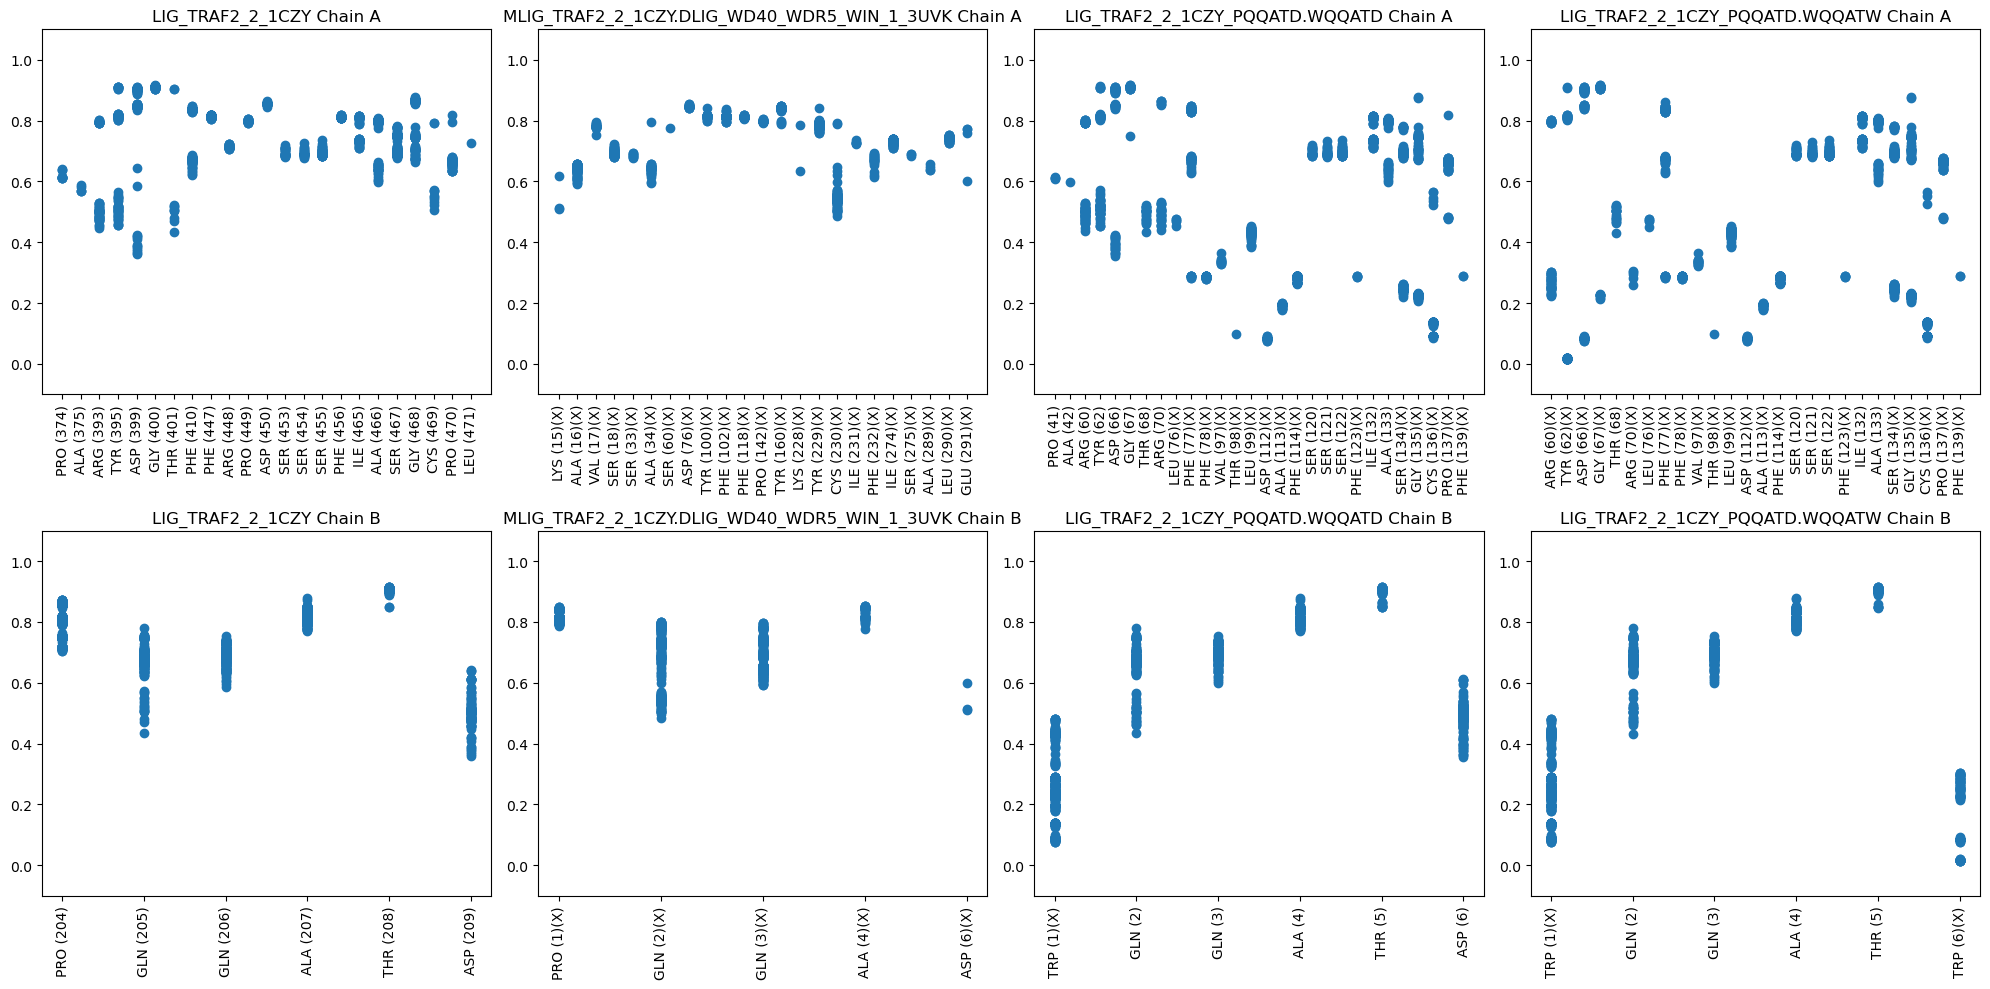

4


structure_name PDB_id ELM_instance PDB_id_random_paired  \
98  LIG_Pex14_1_2W84   2W84  LIG_Pex14_1                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
98                       None     None             None   

                   interface  
98  <Interface of 997 pairs>

structure_name PDB_id  ELM_instance  \
221  MLIG_Pex14_1_2W84.DLIG_PROFILIN_1_2V8C   2W84  MLIG_Pex14_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
221                 2V8C            DLIG_PROFILIN_1     None             None   

                    interface  
221  <Interface of 612 pairs>

structure_name PDB_id ELM_instance PDB_id_random_paired  \
461  LIG_Pex14_1_2W84_WAQEF.GAQED   2W84  LIG_Pex14_1                 None   
462  LIG_Pex14_1_2W84_WAQEF.GAQEF   2W84  LIG_Pex14_1                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
461                       None    WAQEF            GAQED   
462                       None    WAQEF            GAQEF   

                    interface  
461   <Interface of 44 pairs>  
462  <Interface of 717 pairs>

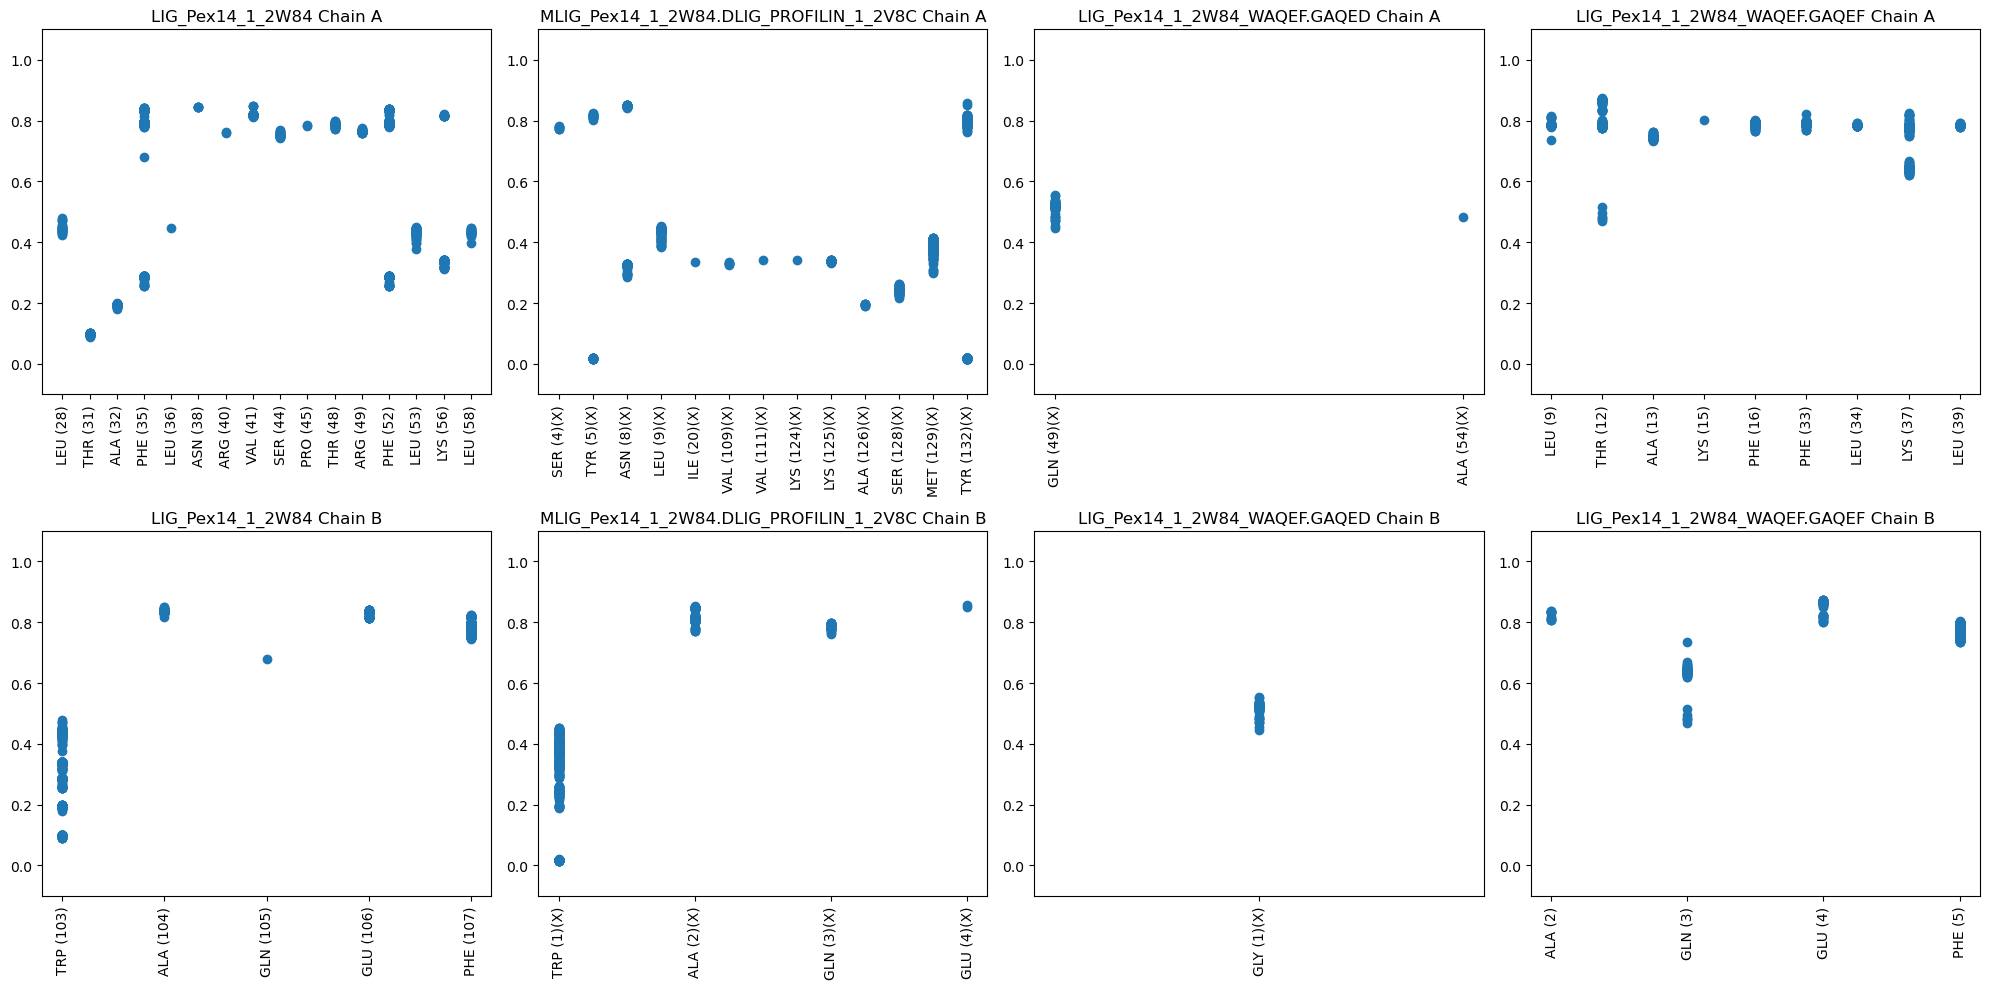

4


structure_name PDB_id   ELM_instance PDB_id_random_paired  \
44  LIG_BIR_III_3_1JD5   1JD5  LIG_BIR_III_3                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
44                       None     None             None   

                    interface  
44  <Interface of 1214 pairs>

structure_name PDB_id    ELM_instance  \
167  MLIG_BIR_III_3_1JD5.DLIG_LRP6_Inhibitor_1_3SOQ   1JD5  MLIG_BIR_III_3   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
167                 3SOQ      DLIG_LRP6_Inhibitor_1     None             None   

                    interface  
167  <Interface of 572 pairs>

structure_name PDB_id   ELM_instance PDB_id_random_paired  \
357  LIG_BIR_III_3_1JD5_AIAY.AIWY   1JD5  LIG_BIR_III_3                 None   
358  LIG_BIR_III_3_1JD5_AIAY.WIWY   1JD5  LIG_BIR_III_3                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
357                       None     AIAY             AIWY   
358                       None     AIAY             WIWY   

                     interface  
357  <Interface of 1022 pairs>  
358   <Interface of 873 pairs>

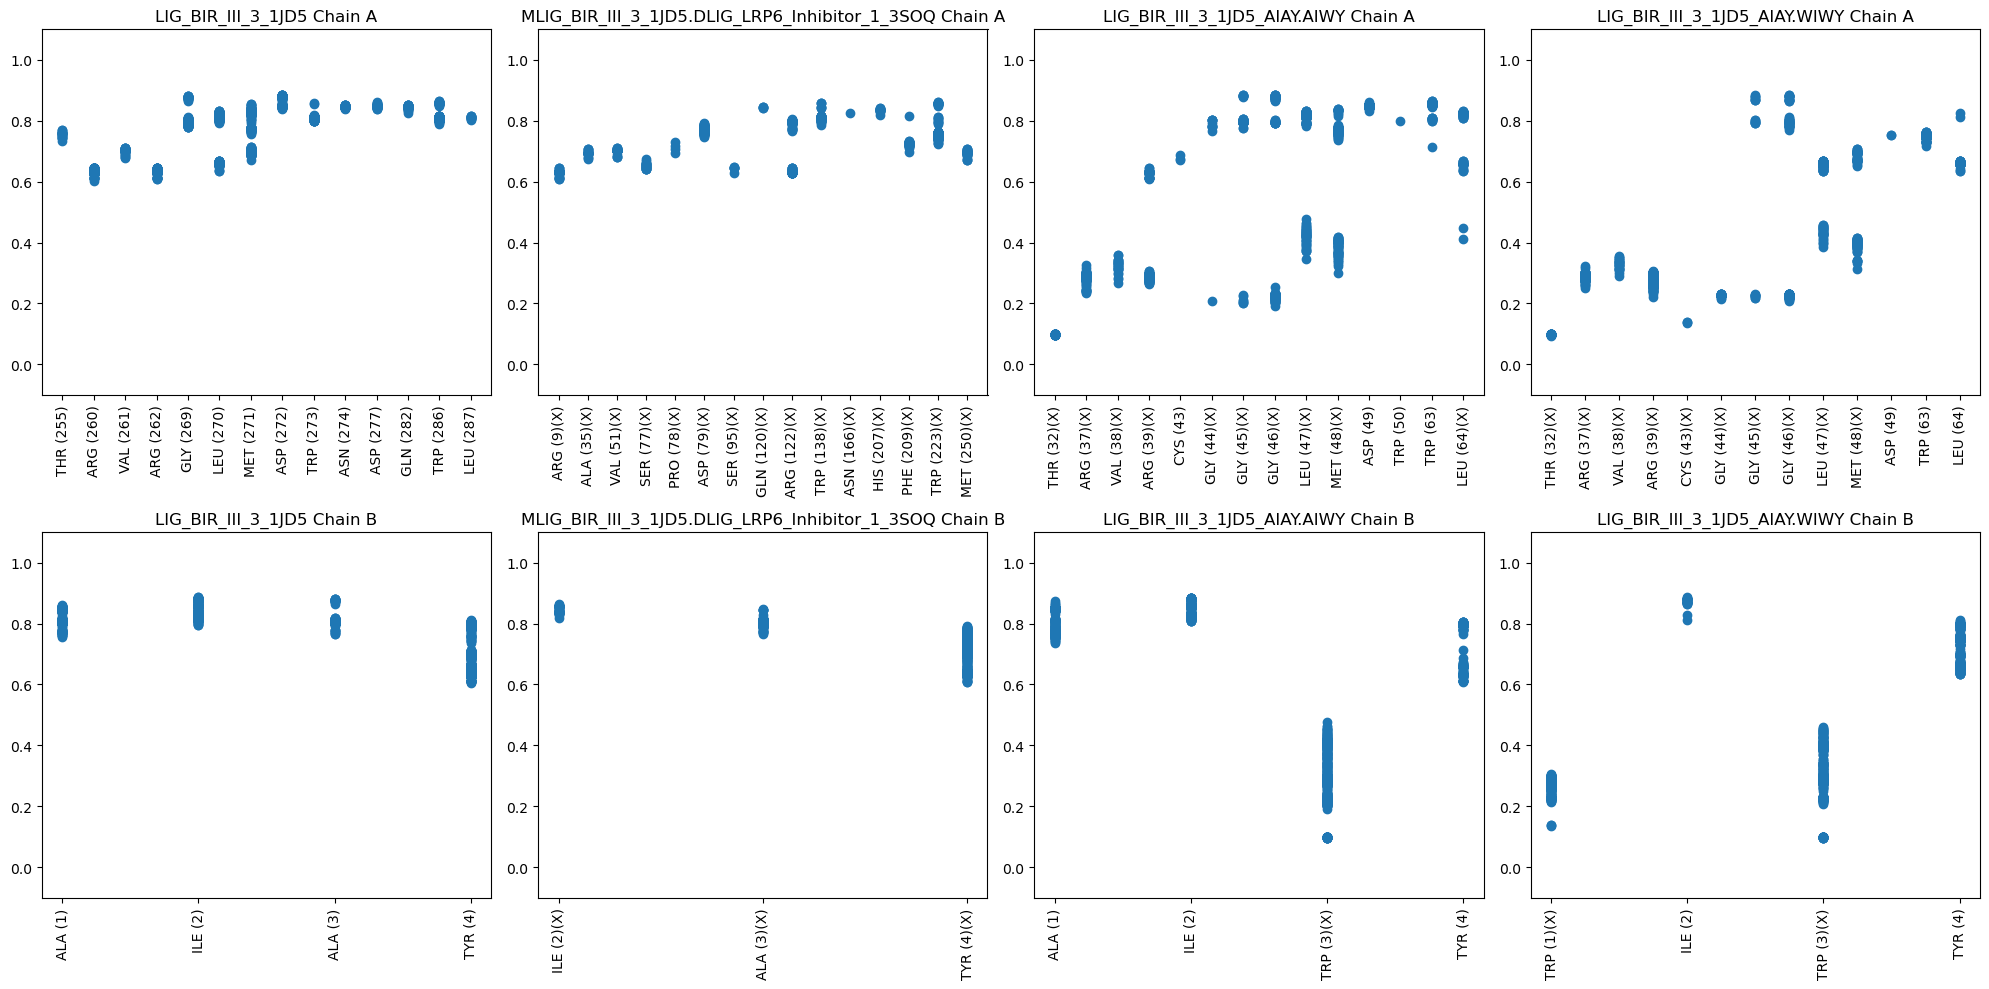

4


structure_name PDB_id         ELM_instance  \
121  LIG_WD40_WDR5_WIN_1_3UVK   3UVK  LIG_WD40_WDR5_WIN_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
121                 None                       None     None             None   

                     interface  
121  <Interface of 1759 pairs>

structure_name PDB_id  \
245  MLIG_WD40_WDR5_WIN_1_3UVK.DTRG_LysEnd_GGAAcLL_...   3UVK   

             ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
245  MLIG_WD40_WDR5_WIN_1                 1JWG      DTRG_LysEnd_GGAAcLL_1   

    sequence sequence_mutated                 interface  
245     None             None  <Interface of 662 pairs>

structure_name PDB_id         ELM_instance  \
509  LIG_WD40_WDR5_WIN_1_3UVK_CARSEPK.CARSWPK   3UVK  LIG_WD40_WDR5_WIN_1   
510  LIG_WD40_WDR5_WIN_1_3UVK_CARSEPK.CARWWPK   3UVK  LIG_WD40_WDR5_WIN_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
509                 None                       None  CARSEPK          CARSWPK   
510                 None                       None  CARSEPK          CARWWPK   

                     interface  
509  <Interface of 1393 pairs>  
510  <Interface of 1505 pairs>

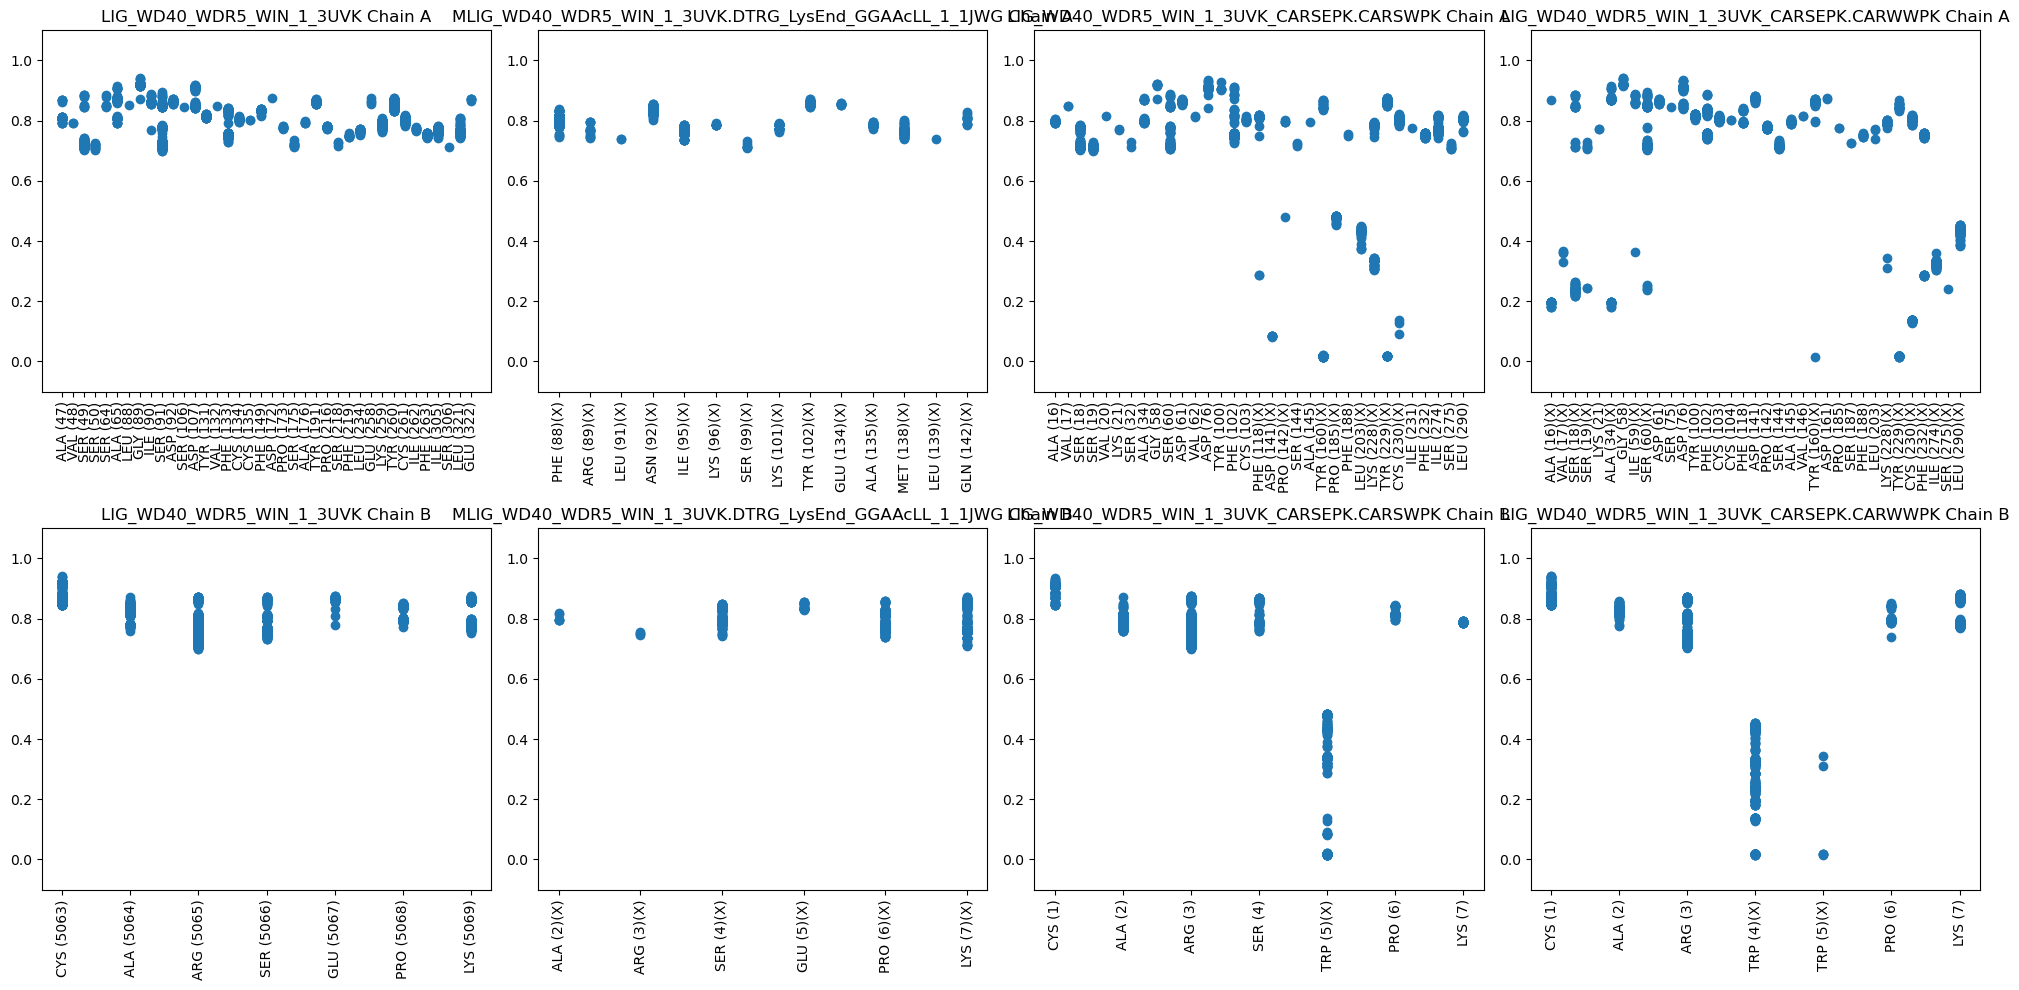

4


structure_name PDB_id       ELM_instance PDB_id_random_paired  \
3  DEG_Kelch_Keap1_2_3WN7   3WN7  DEG_Kelch_Keap1_2                 None   

  ELM_instance_random_paired sequence sequence_mutated  \
3                       None     None             None   

                   interface  
3  <Interface of 1602 pairs>

structure_name PDB_id        ELM_instance  \
127  MDEG_Kelch_Keap1_2_3WN7.DDOC_USP7_MATH_2_1YY6   3WN7  MDEG_Kelch_Keap1_2   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
127                 1YY6           DDOC_USP7_MATH_2     None             None   

                    interface  
127  <Interface of 933 pairs>

structure_name PDB_id       ELM_instance  \
275  DEG_Kelch_Keap1_2_3WN7_QDIDLGV.WDIDDGV   3WN7  DEG_Kelch_Keap1_2   
276  DEG_Kelch_Keap1_2_3WN7_QDIDLGV.WDIDLGV   3WN7  DEG_Kelch_Keap1_2   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
275                 None                       None  QDIDLGV          WDIDDGV   
276                 None                       None  QDIDLGV          WDIDLGV   

                     interface  
275  <Interface of 1199 pairs>  
276  <Interface of 1397 pairs>

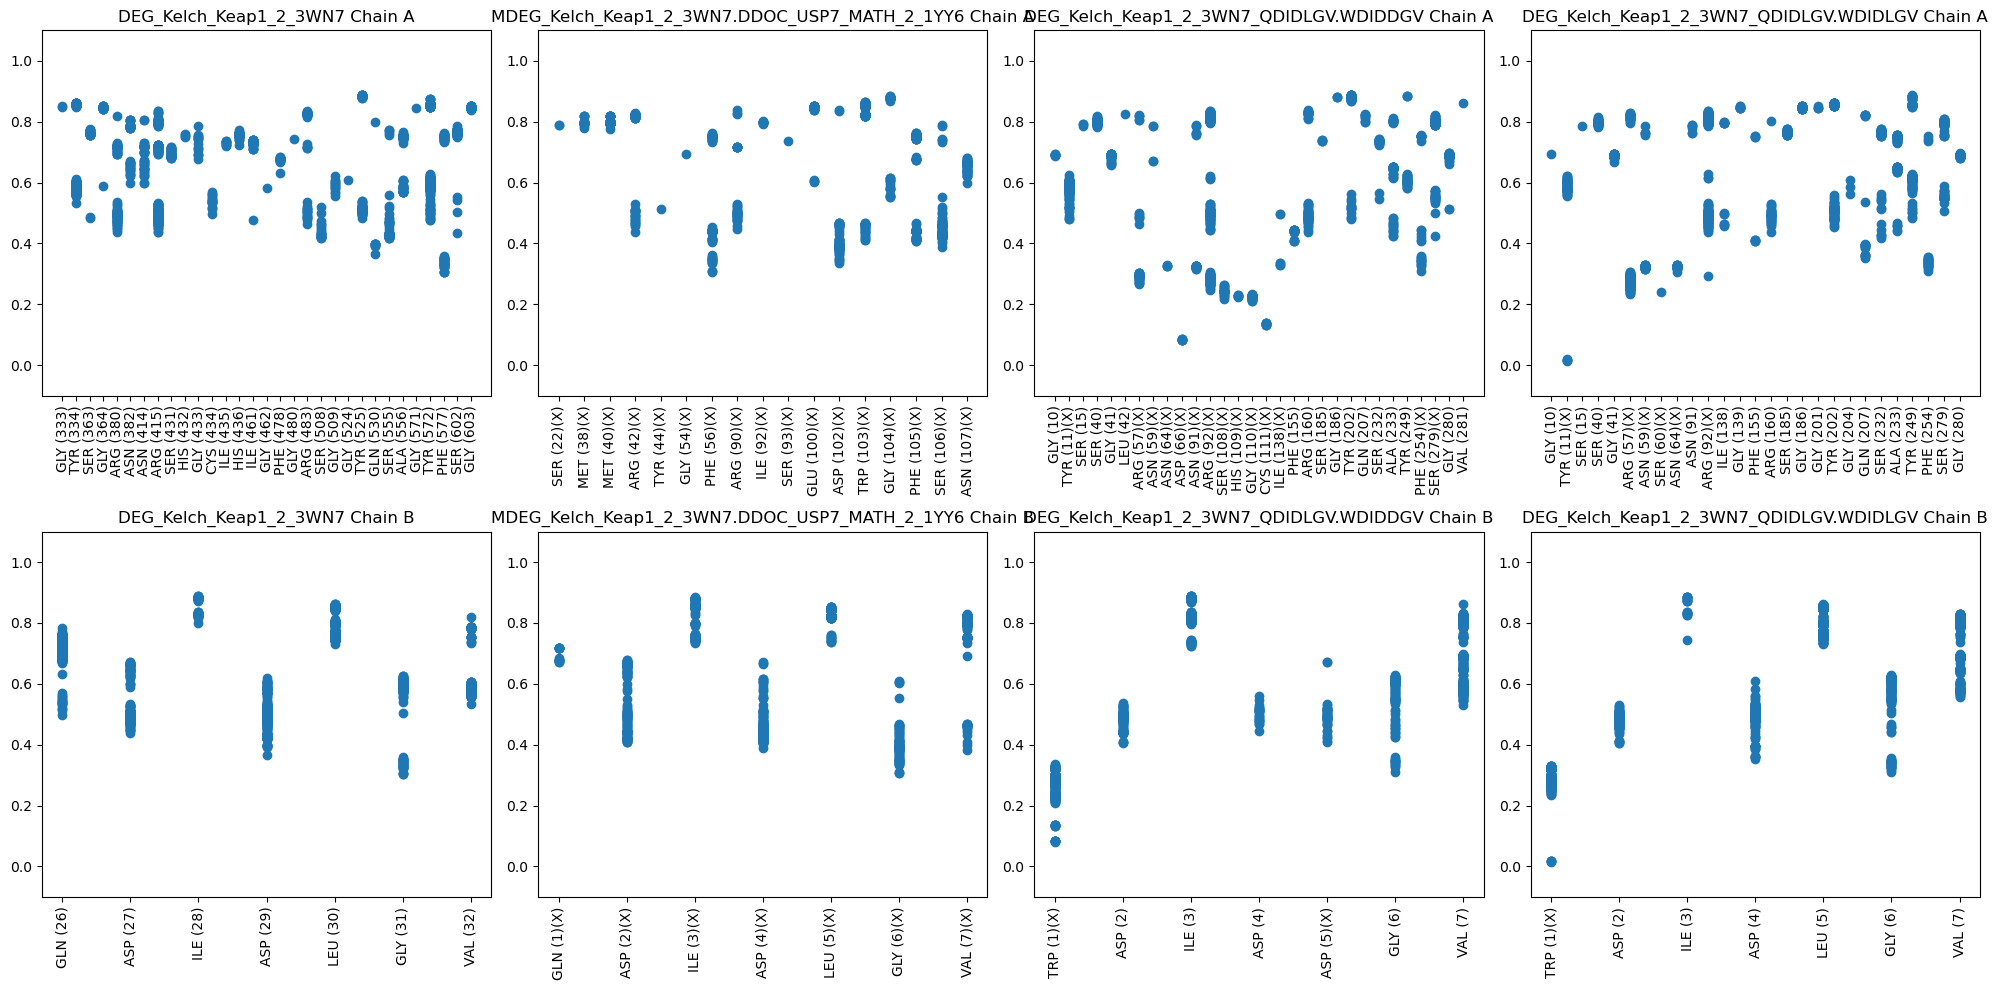

4


structure_name PDB_id         ELM_instance  \
113  LIG_SUMO_SIM_anti_2_2KQS   2KQS  LIG_SUMO_SIM_anti_2   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
113                 None                       None     None             None   

                     interface  
113  <Interface of 1850 pairs>

structure_name PDB_id  \
235  MLIG_SUMO_SIM_anti_2_2KQS.DLIG_APCC_ABBA_1_4BH6   2KQS   

             ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
235  MLIG_SUMO_SIM_anti_2                 4BH6           DLIG_APCC_ABBA_1   

    sequence sequence_mutated                 interface  
235     None             None  <Interface of 965 pairs>

structure_name PDB_id         ELM_instance  \
489  LIG_SUMO_SIM_anti_2_2KQS_EIIVLSDSD.EIDVLSDWD   2KQS  LIG_SUMO_SIM_anti_2   
490  LIG_SUMO_SIM_anti_2_2KQS_EIIVLSDSD.EIIVLSDWD   2KQS  LIG_SUMO_SIM_anti_2   

    PDB_id_random_paired ELM_instance_random_paired   sequence  \
489                 None                       None  EIIVLSDSD   
490                 None                       None  EIIVLSDSD   

    sequence_mutated                  interface  
489        EIDVLSDWD  <Interface of 1422 pairs>  
490        EIIVLSDWD  <Interface of 1766 pairs>

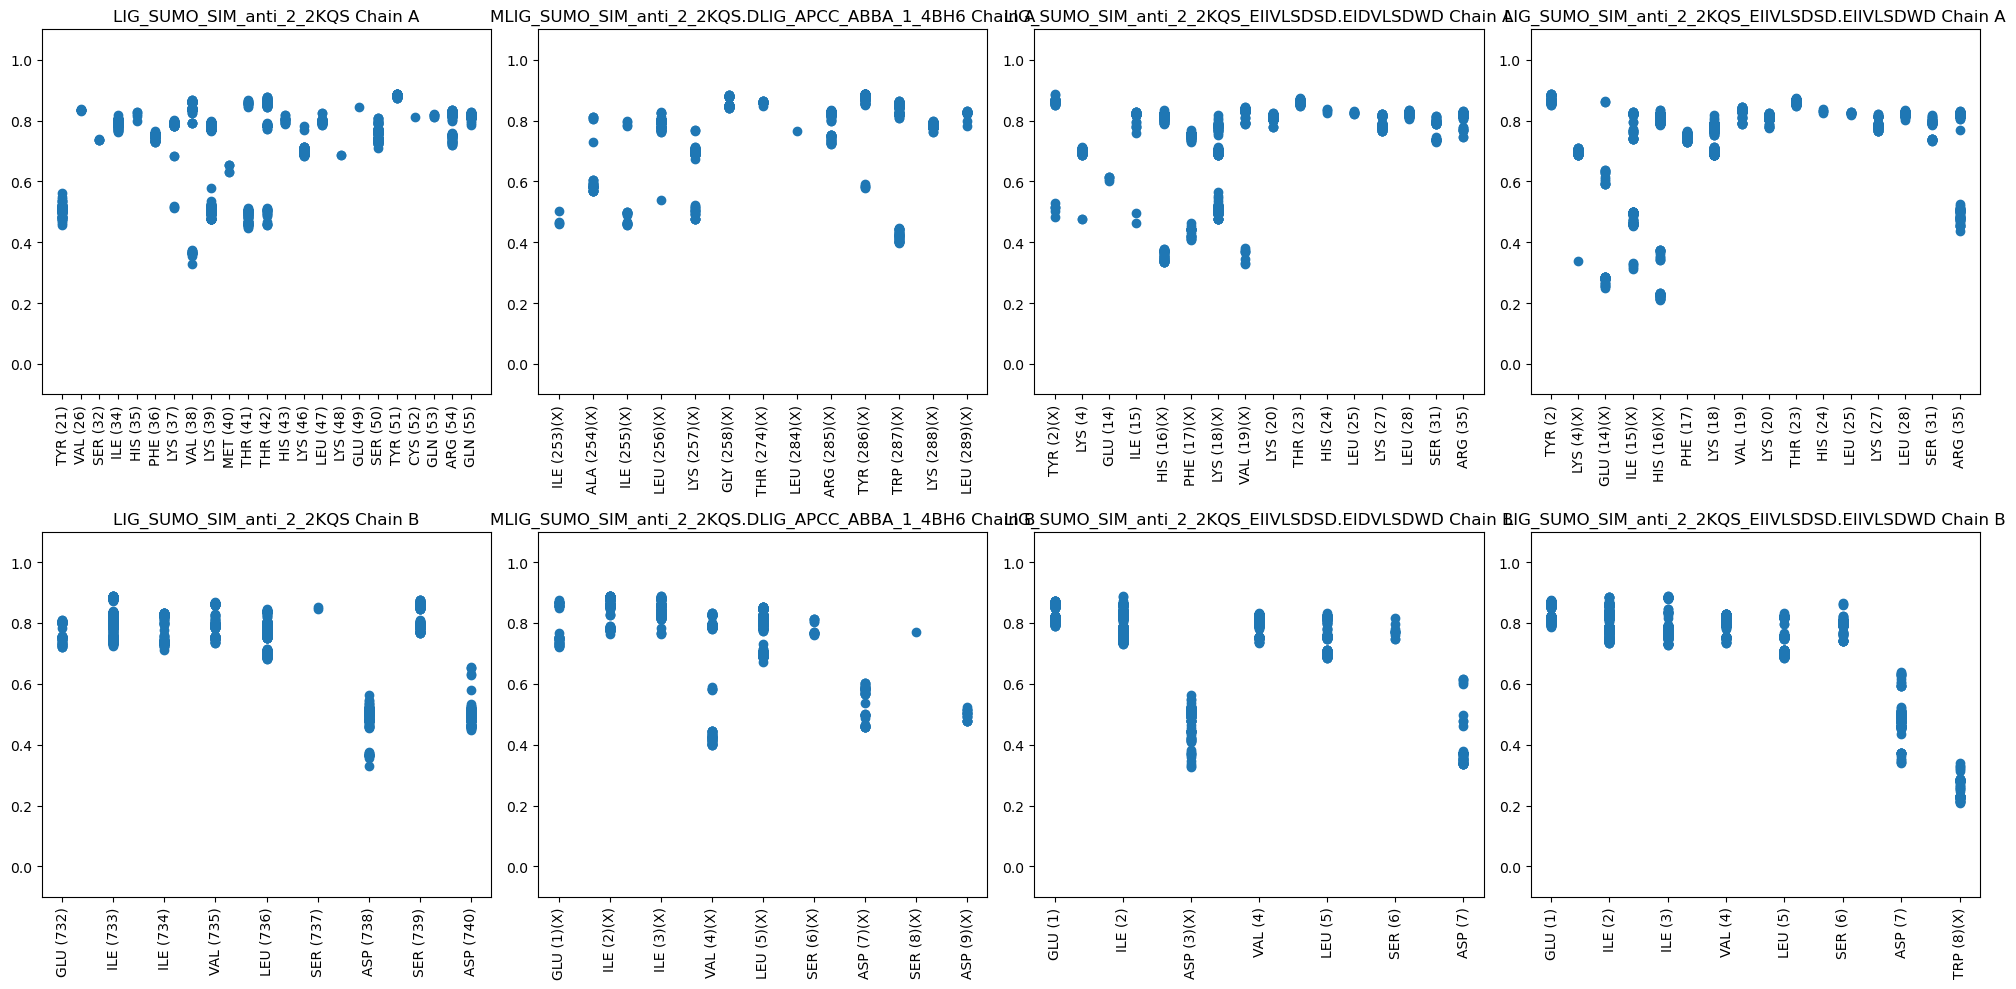

4


structure_name PDB_id ELM_instance PDB_id_random_paired  \
112  LIG_SUFU_1_4KMD   4KMD   LIG_SUFU_1                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
112                       None     None             None   

                     interface  
112  <Interface of 2368 pairs>

structure_name PDB_id ELM_instance  \
234  MLIG_SUFU_1_4KMD.DLIG_ActinCP_CPI_1_3AA1   4KMD  MLIG_SUFU_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
234                 3AA1         DLIG_ActinCP_CPI_1     None             None   

                     interface  
234  <Interface of 1443 pairs>

structure_name PDB_id ELM_instance  \
487  LIG_SUFU_1_4KMD_SYGHLSIG.SYGWLSDG   4KMD   LIG_SUFU_1   
488  LIG_SUFU_1_4KMD_SYGHLSIG.SYGWLSIG   4KMD   LIG_SUFU_1   

    PDB_id_random_paired ELM_instance_random_paired  sequence  \
487                 None                       None  SYGHLSIG   
488                 None                       None  SYGHLSIG   

    sequence_mutated                  interface  
487         SYGWLSDG  <Interface of 1163 pairs>  
488         SYGWLSIG  <Interface of 1774 pairs>

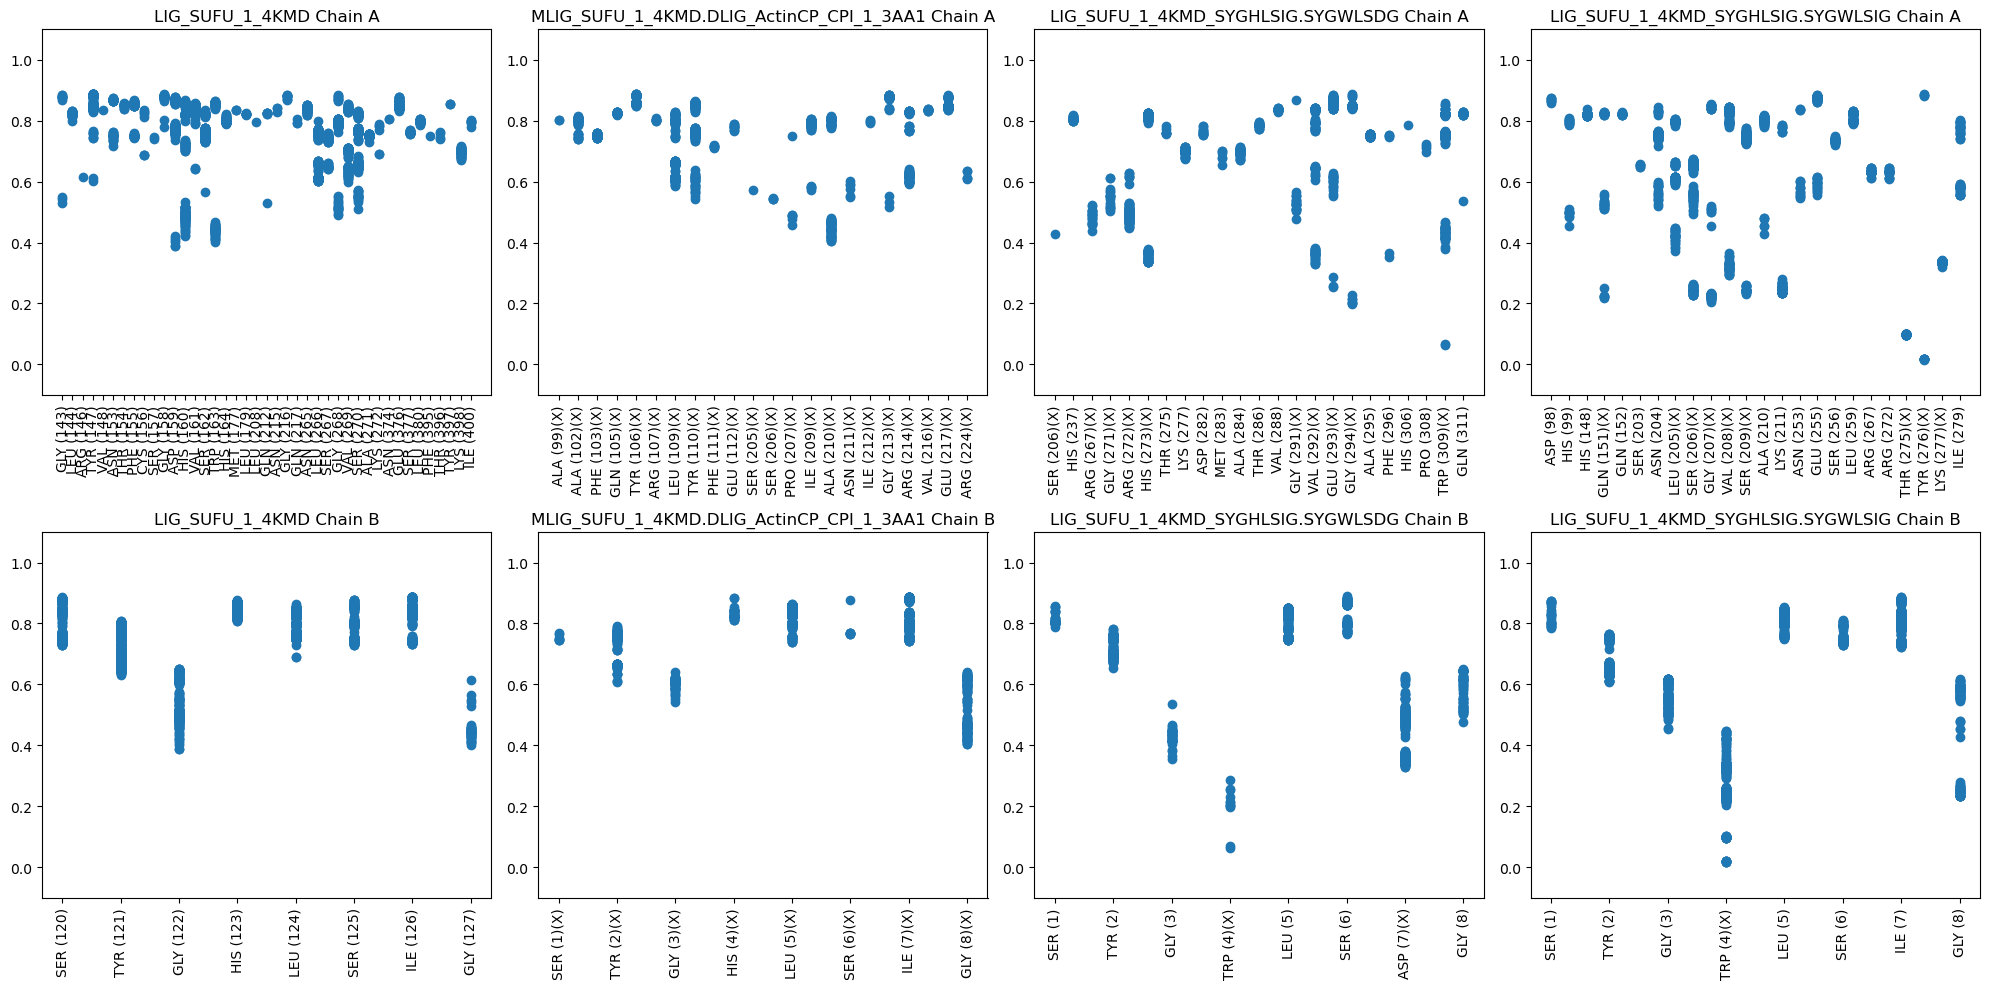

4


structure_name PDB_id   ELM_instance PDB_id_random_paired  \
22  DOC_MIT_MIM_1_2JQ9   2JQ9  DOC_MIT_MIM_1                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
22                       None     None             None   

                    interface  
22  <Interface of 1362 pairs>

structure_name PDB_id    ELM_instance  \
146  MDOC_MIT_MIM_1_2JQ9.DLIG_HOMEOBOX_1B72   2JQ9  MDOC_MIT_MIM_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
146                 1B72              DLIG_HOMEOBOX     None             None   

                     interface  
146  <Interface of 1021 pairs>

structure_name PDB_id   ELM_instance  \
313  DOC_MIT_MIM_1_2JQ9_DQLSRRLAALR.DQLSRRDAALG   2JQ9  DOC_MIT_MIM_1   
314  DOC_MIT_MIM_1_2JQ9_DQLSRRLAALR.DQLSRRLAALG   2JQ9  DOC_MIT_MIM_1   

    PDB_id_random_paired ELM_instance_random_paired     sequence  \
313                 None                       None  DQLSRRLAALR   
314                 None                       None  DQLSRRLAALR   

    sequence_mutated                  interface  
313      DQLSRRDAALG  <Interface of 1108 pairs>  
314      DQLSRRLAALG  <Interface of 1515 pairs>

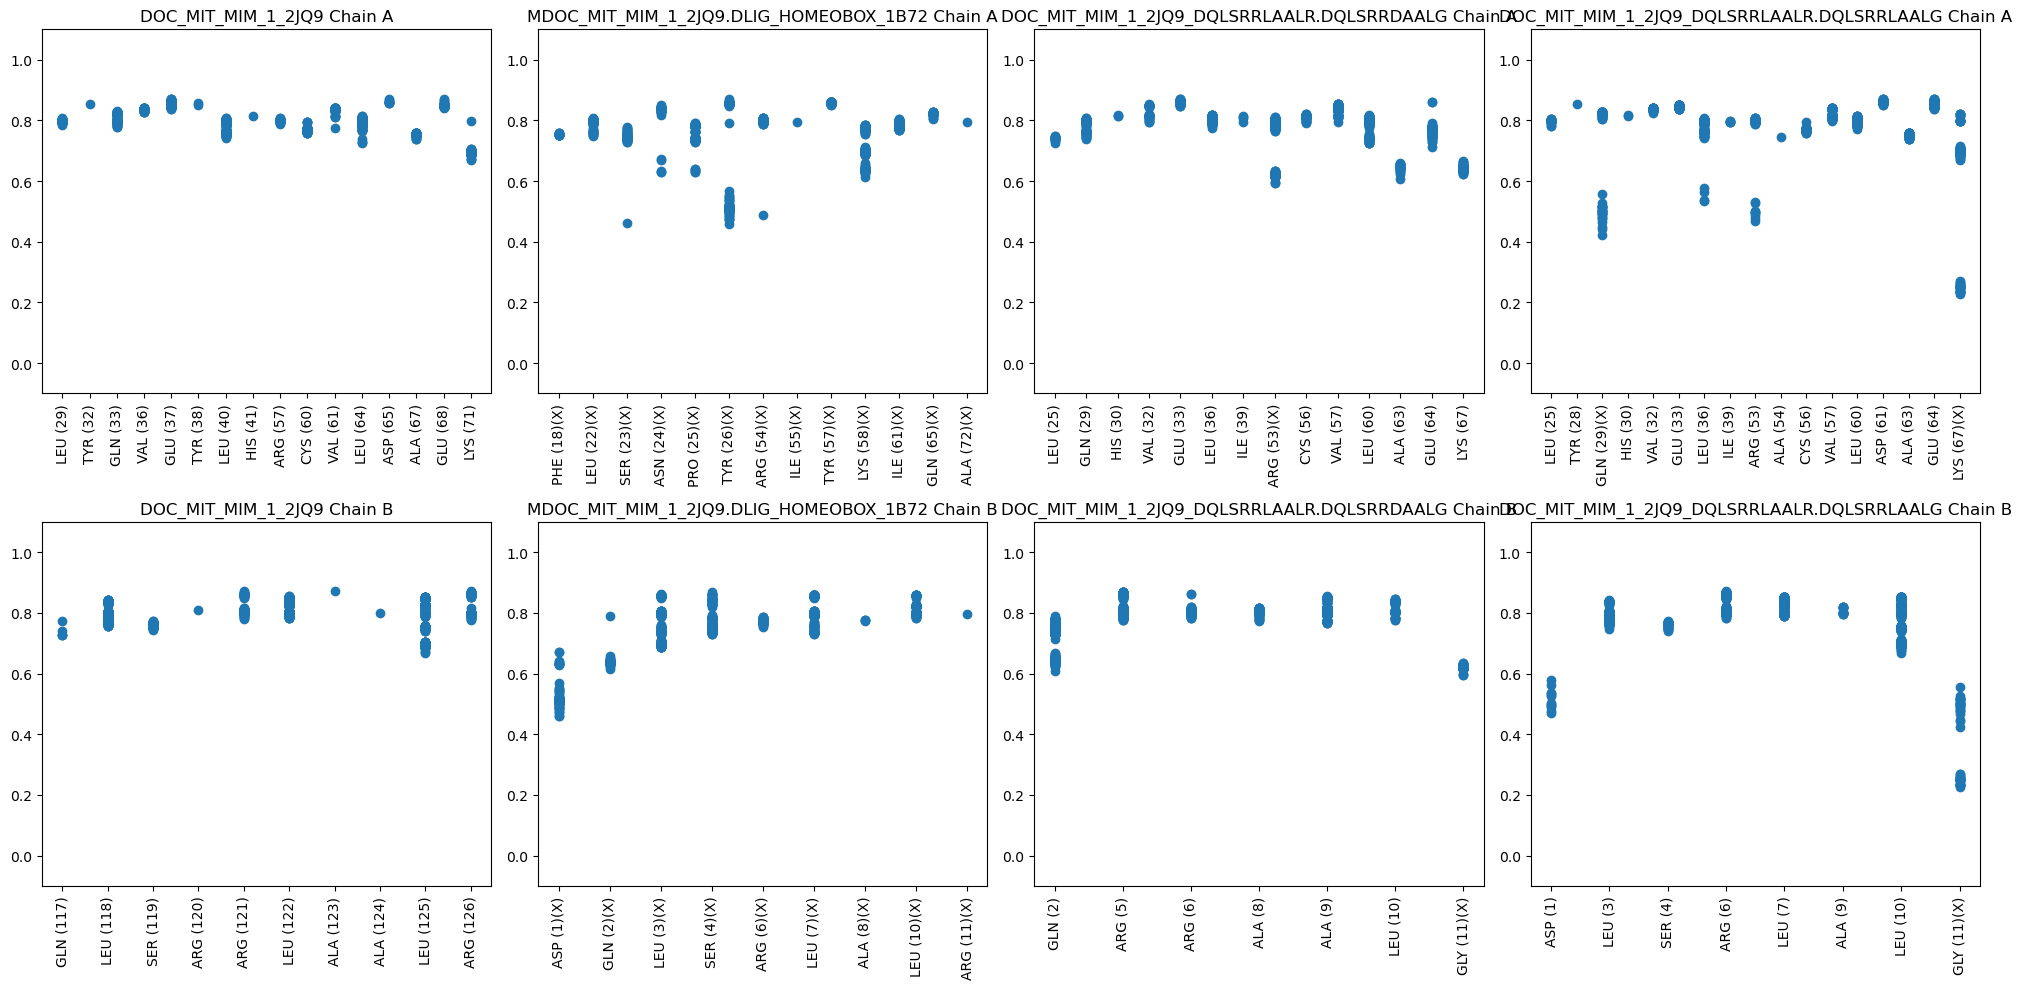

4


structure_name PDB_id ELM_instance PDB_id_random_paired  \
268  TRG_PTS1_2C0L   2C0L     TRG_PTS1                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
268                       None     None             None   

                     interface  
268  <Interface of 1379 pairs>

structure_name PDB_id ELM_instance  \
259  MTRG_PTS1_2C0L.DLIG_WD40_WDR5_WIN_2_4CY3   2C0L    MTRG_PTS1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
259                 4CY3       DLIG_WD40_WDR5_WIN_2     None             None   

                    interface  
259  <Interface of 491 pairs>

structure_name PDB_id ELM_instance PDB_id_random_paired  \
535  TRG_PTS1_2C0L_NAKL.NAGD   2C0L     TRG_PTS1                 None   
536  TRG_PTS1_2C0L_NAKL.NAKD   2C0L     TRG_PTS1                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
535                       None     NAKL             NAGD   
536                       None     NAKL             NAKD   

                     interface  
535    <Interface of 95 pairs>  
536  <Interface of 1227 pairs>

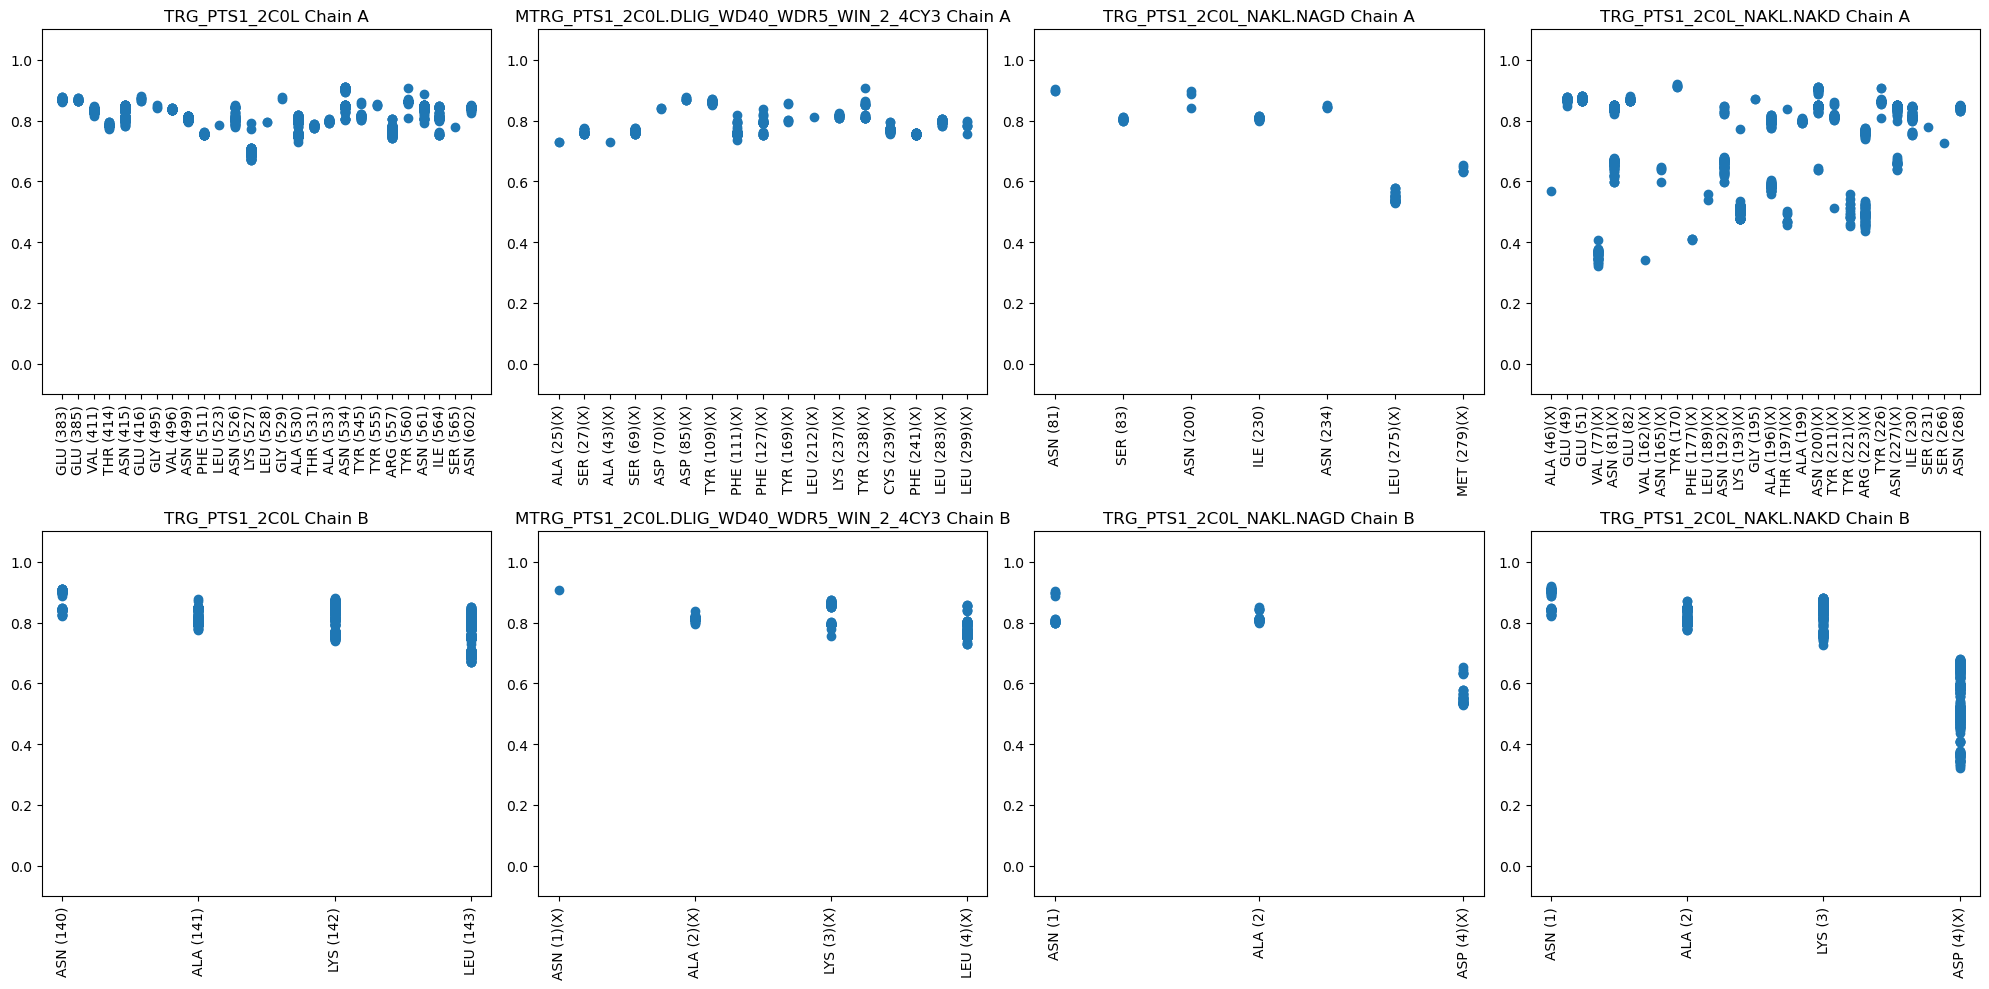

4


structure_name PDB_id     ELM_instance PDB_id_random_paired  \
27  DOC_SPAK_OSR1_1_2V3S   2V3S  DOC_SPAK_OSR1_1                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
27                       None     None             None   

                    interface  
27  <Interface of 1176 pairs>

structure_name PDB_id      ELM_instance  \
151  MDOC_SPAK_OSR1_1_2V3S.DLIG_NBox_RRM_1_2KXH   2V3S  MDOC_SPAK_OSR1_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
151                 2KXH            DLIG_NBox_RRM_1     None             None   

                    interface  
151  <Interface of 248 pairs>

structure_name PDB_id     ELM_instance  \
323  DOC_SPAK_OSR1_1_2V3S_RFQVT.GDQVT   2V3S  DOC_SPAK_OSR1_1   
324  DOC_SPAK_OSR1_1_2V3S_RFQVT.GFQVT   2V3S  DOC_SPAK_OSR1_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
323                 None                       None    RFQVT            GDQVT   
324                 None                       None    RFQVT            GFQVT   

                    interface  
323  <Interface of 382 pairs>  
324  <Interface of 879 pairs>

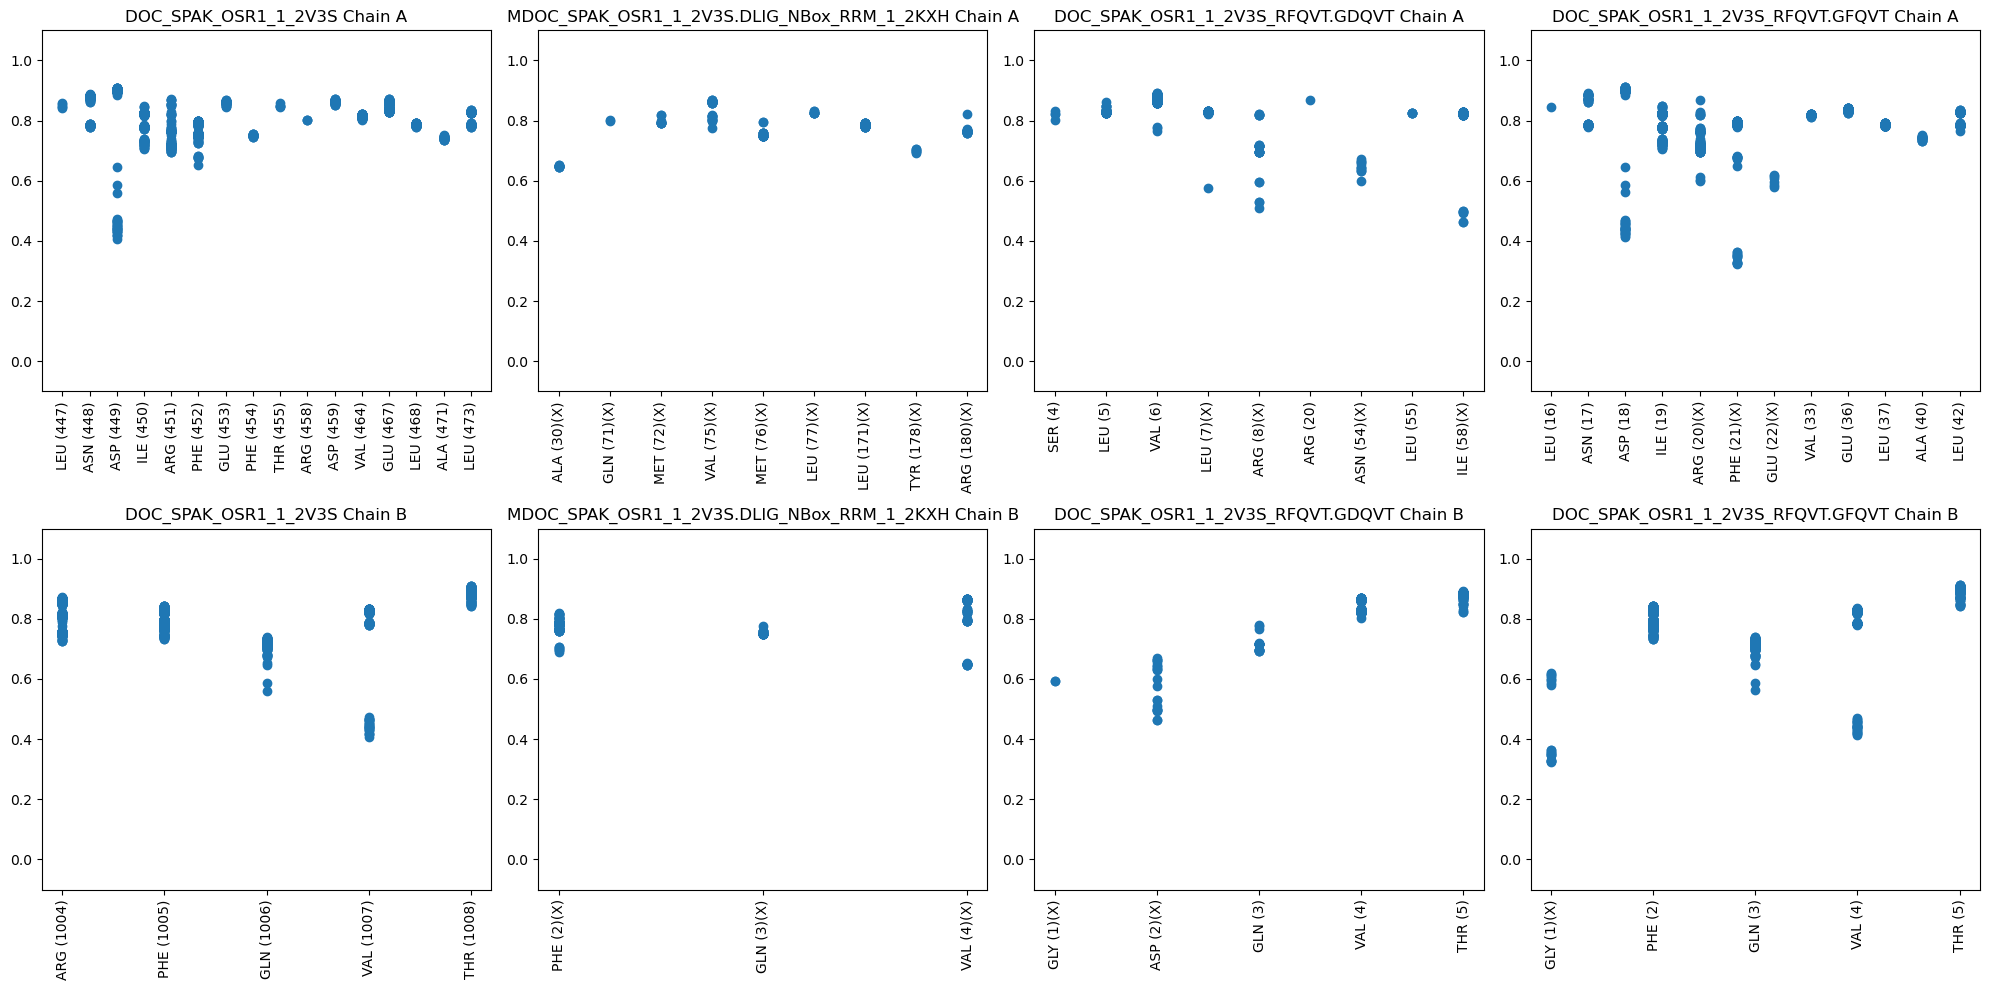

3


structure_name PDB_id   ELM_instance PDB_id_random_paired  \
78  LIG_LYPXL_L_2_2R02   2R02  LIG_LYPXL_L_2                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
78                       None     None             None   

                    interface  
78  <Interface of 1526 pairs>

Empty DataFrame
Columns: [structure_name, PDB_id, ELM_instance, PDB_id_random_paired, ELM_instance_random_paired, sequence, sequence_mutated, interface]
Index: []

structure_name PDB_id   ELM_instance  \
421  LIG_LYPXL_L_2_2R02_LYPLTSLRSL.DYPLTSLRSL   2R02  LIG_LYPXL_L_2   
422  LIG_LYPXL_L_2_2R02_LYPLTSLRSL.DYWLTSLRSL   2R02  LIG_LYPXL_L_2   

    PDB_id_random_paired ELM_instance_random_paired    sequence  \
421                 None                       None  LYPLTSLRSL   
422                 None                       None  LYPLTSLRSL   

    sequence_mutated                  interface  
421       DYPLTSLRSL  <Interface of 1627 pairs>  
422       DYWLTSLRSL  <Interface of 1542 pairs>

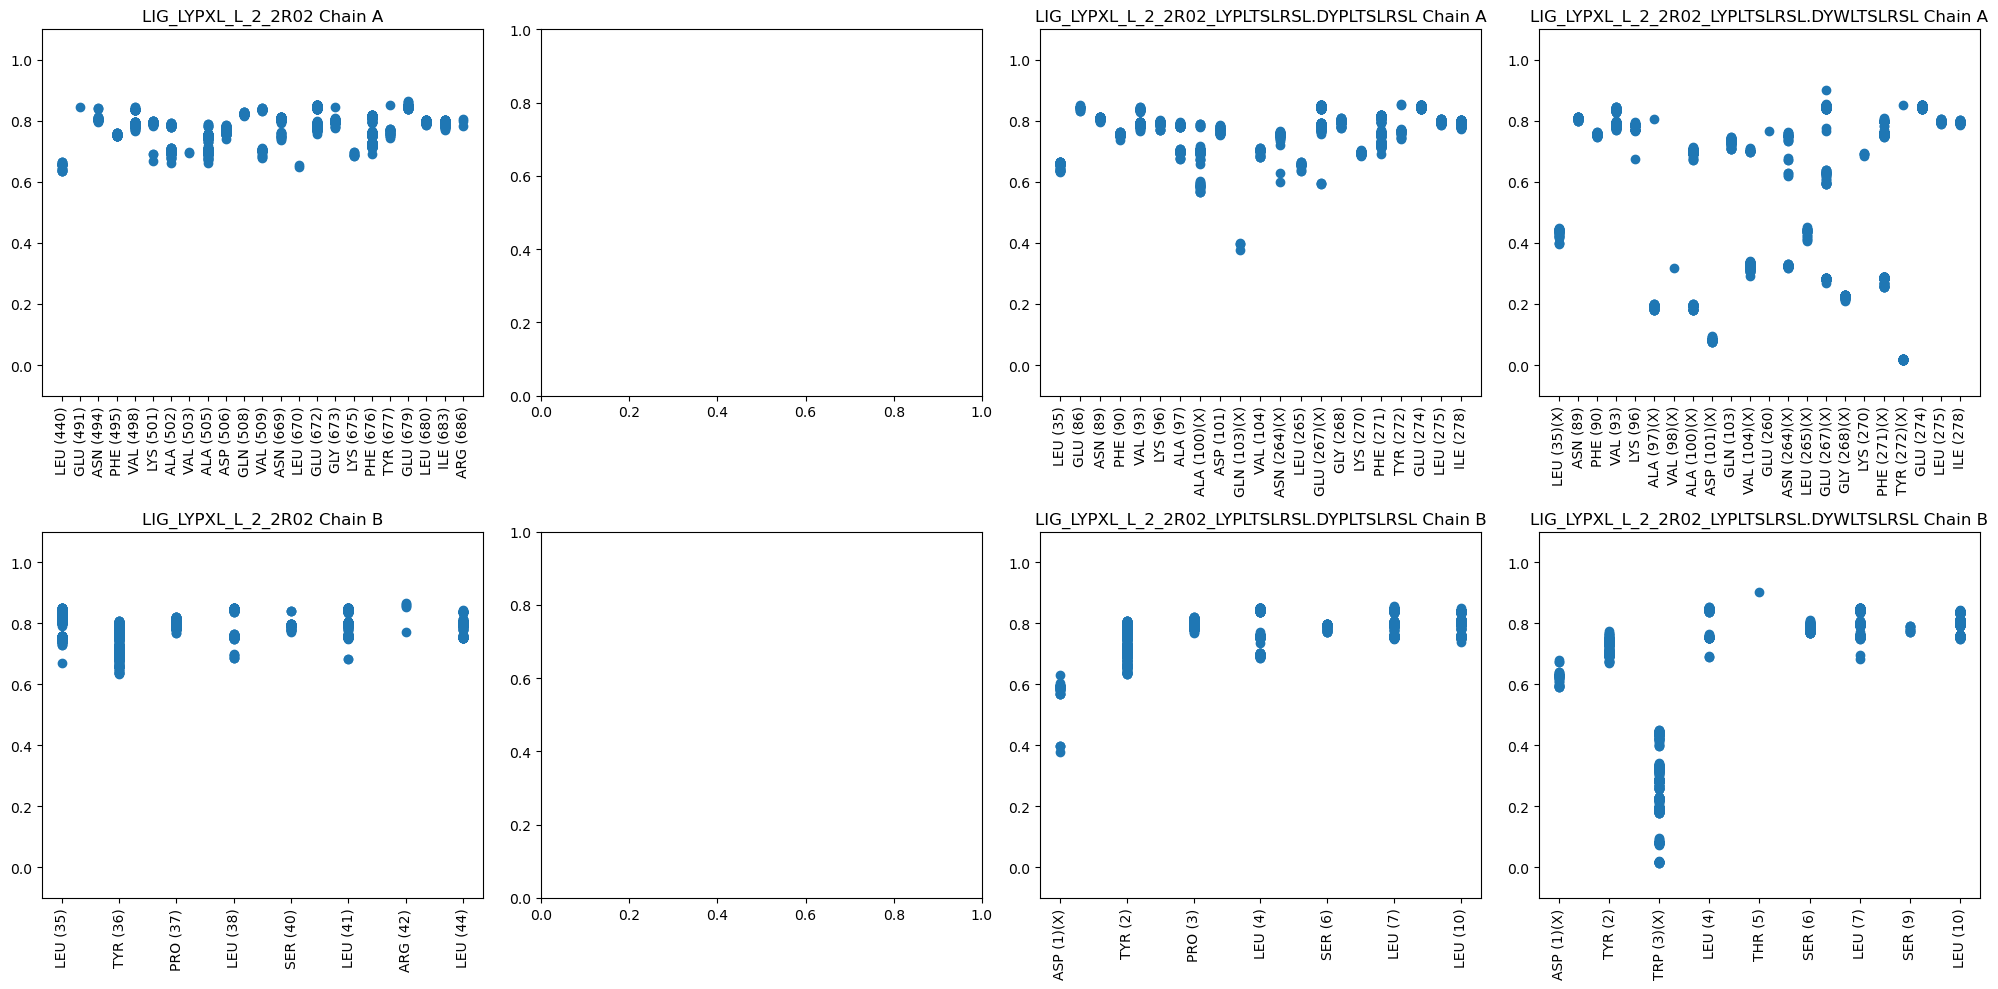

4


structure_name PDB_id ELM_instance PDB_id_random_paired  \
8  DEG_SIAH_1_2A25   2A25   DEG_SIAH_1                 None   

  ELM_instance_random_paired sequence sequence_mutated  \
8                       None     None             None   

                   interface  
8  <Interface of 1755 pairs>

structure_name PDB_id ELM_instance  \
132  MDEG_SIAH_1_2A25.DLIG_CAP-Gly_2_3RDV   2A25  MDEG_SIAH_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
132                 3RDV             DLIG_CAP-Gly_2     None             None   

                    interface  
132  <Interface of 863 pairs>

structure_name PDB_id ELM_instance  \
285  DEG_SIAH_1_2A25_KPAAVVAPI.KPAWVVAPI   2A25   DEG_SIAH_1   
286  DEG_SIAH_1_2A25_KPAAVVAPI.KPAWVVAWI   2A25   DEG_SIAH_1   

    PDB_id_random_paired ELM_instance_random_paired   sequence  \
285                 None                       None  KPAAVVAPI   
286                 None                       None  KPAAVVAPI   

    sequence_mutated                  interface  
285        KPAWVVAPI  <Interface of 2026 pairs>  
286        KPAWVVAWI  <Interface of 1603 pairs>

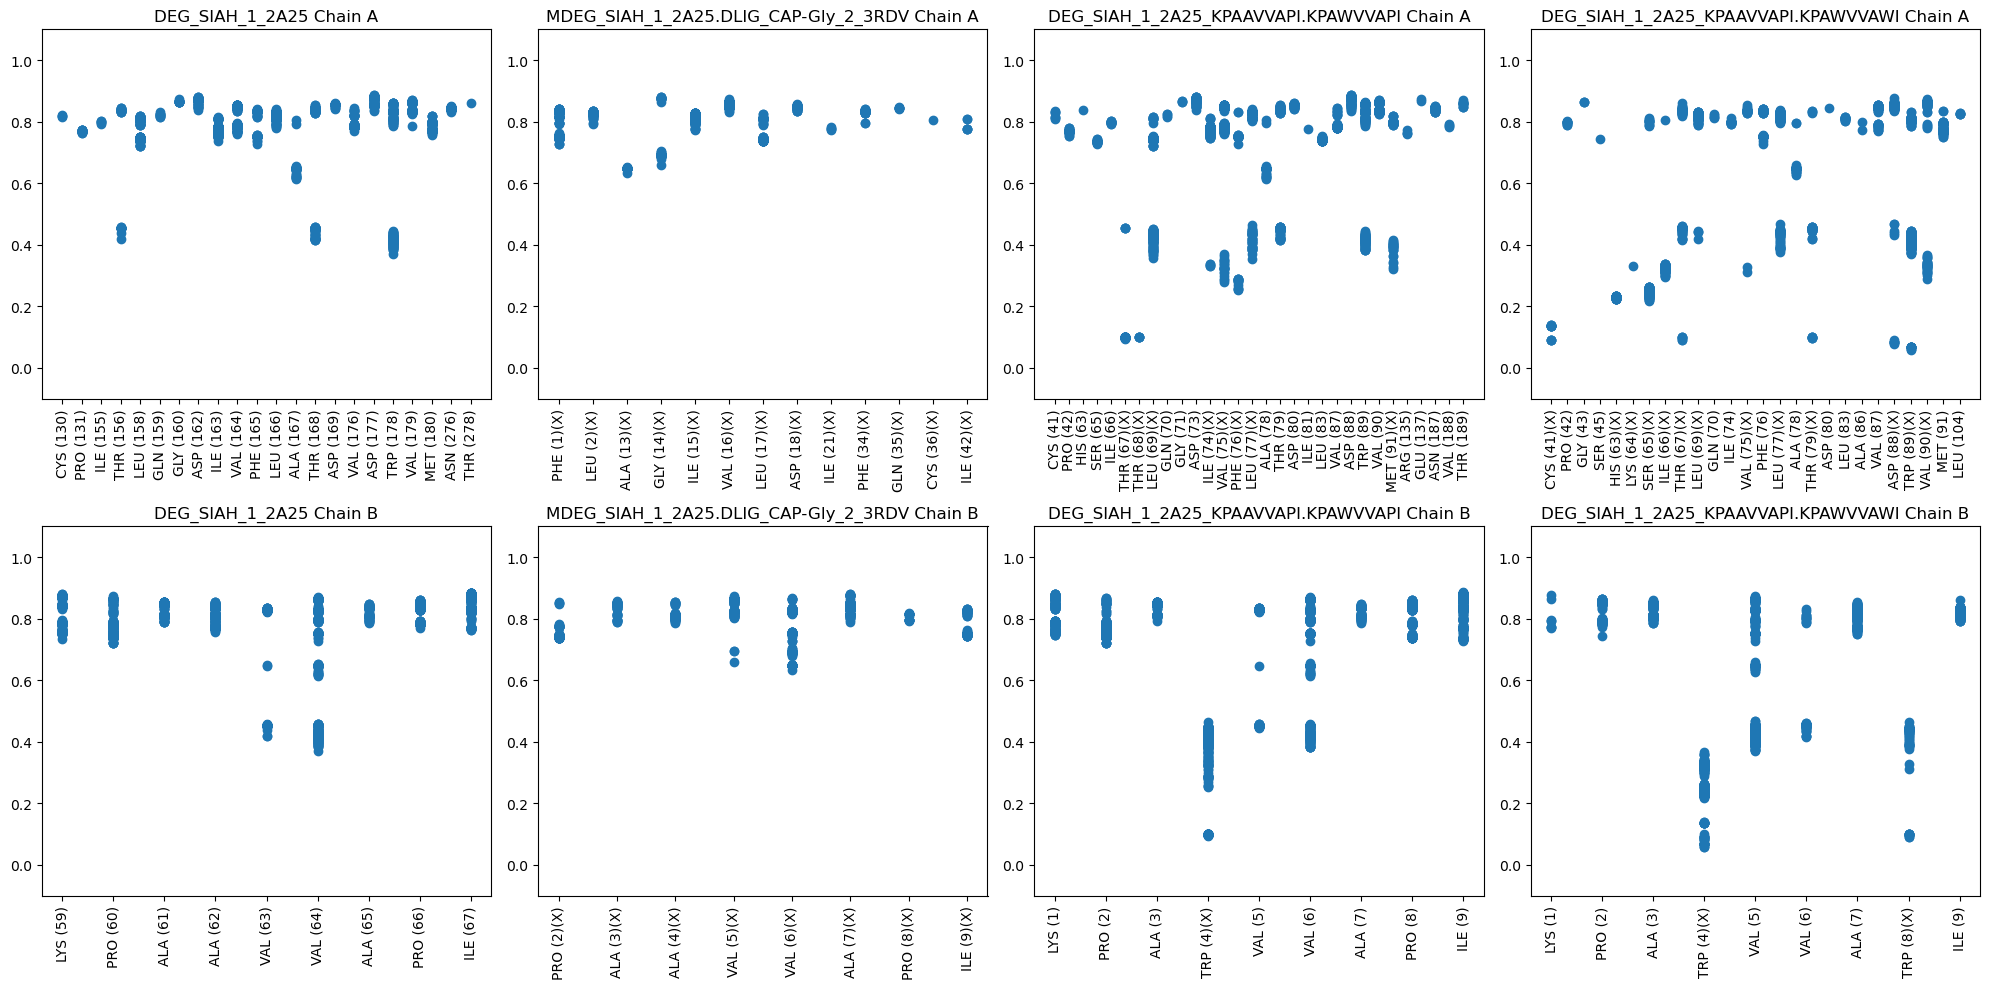

4


structure_name PDB_id        ELM_instance PDB_id_random_paired  \
71  LIG_KLC1_Yacidic_2_6FUZ   6FUZ  LIG_KLC1_Yacidic_2                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
71                       None     None             None   

                    interface  
71  <Interface of 1641 pairs>

structure_name PDB_id  \
194  MLIG_KLC1_Yacidic_2_6FUZ.DDOC_GSK3_Axin_1_1O9U   6FUZ   

            ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
194  MLIG_KLC1_Yacidic_2                 1O9U           DDOC_GSK3_Axin_1   

    sequence sequence_mutated                 interface  
194     None             None  <Interface of 790 pairs>

structure_name PDB_id        ELM_instance  \
407  LIG_KLC1_Yacidic_2_6FUZ_DIYLE.DDGLE   6FUZ  LIG_KLC1_Yacidic_2   
408  LIG_KLC1_Yacidic_2_6FUZ_DIYLE.DIGLE   6FUZ  LIG_KLC1_Yacidic_2   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
407                 None                       None    DIYLE            DDGLE   
408                 None                       None    DIYLE            DIGLE   

                     interface  
407  <Interface of 1087 pairs>  
408  <Interface of 1293 pairs>

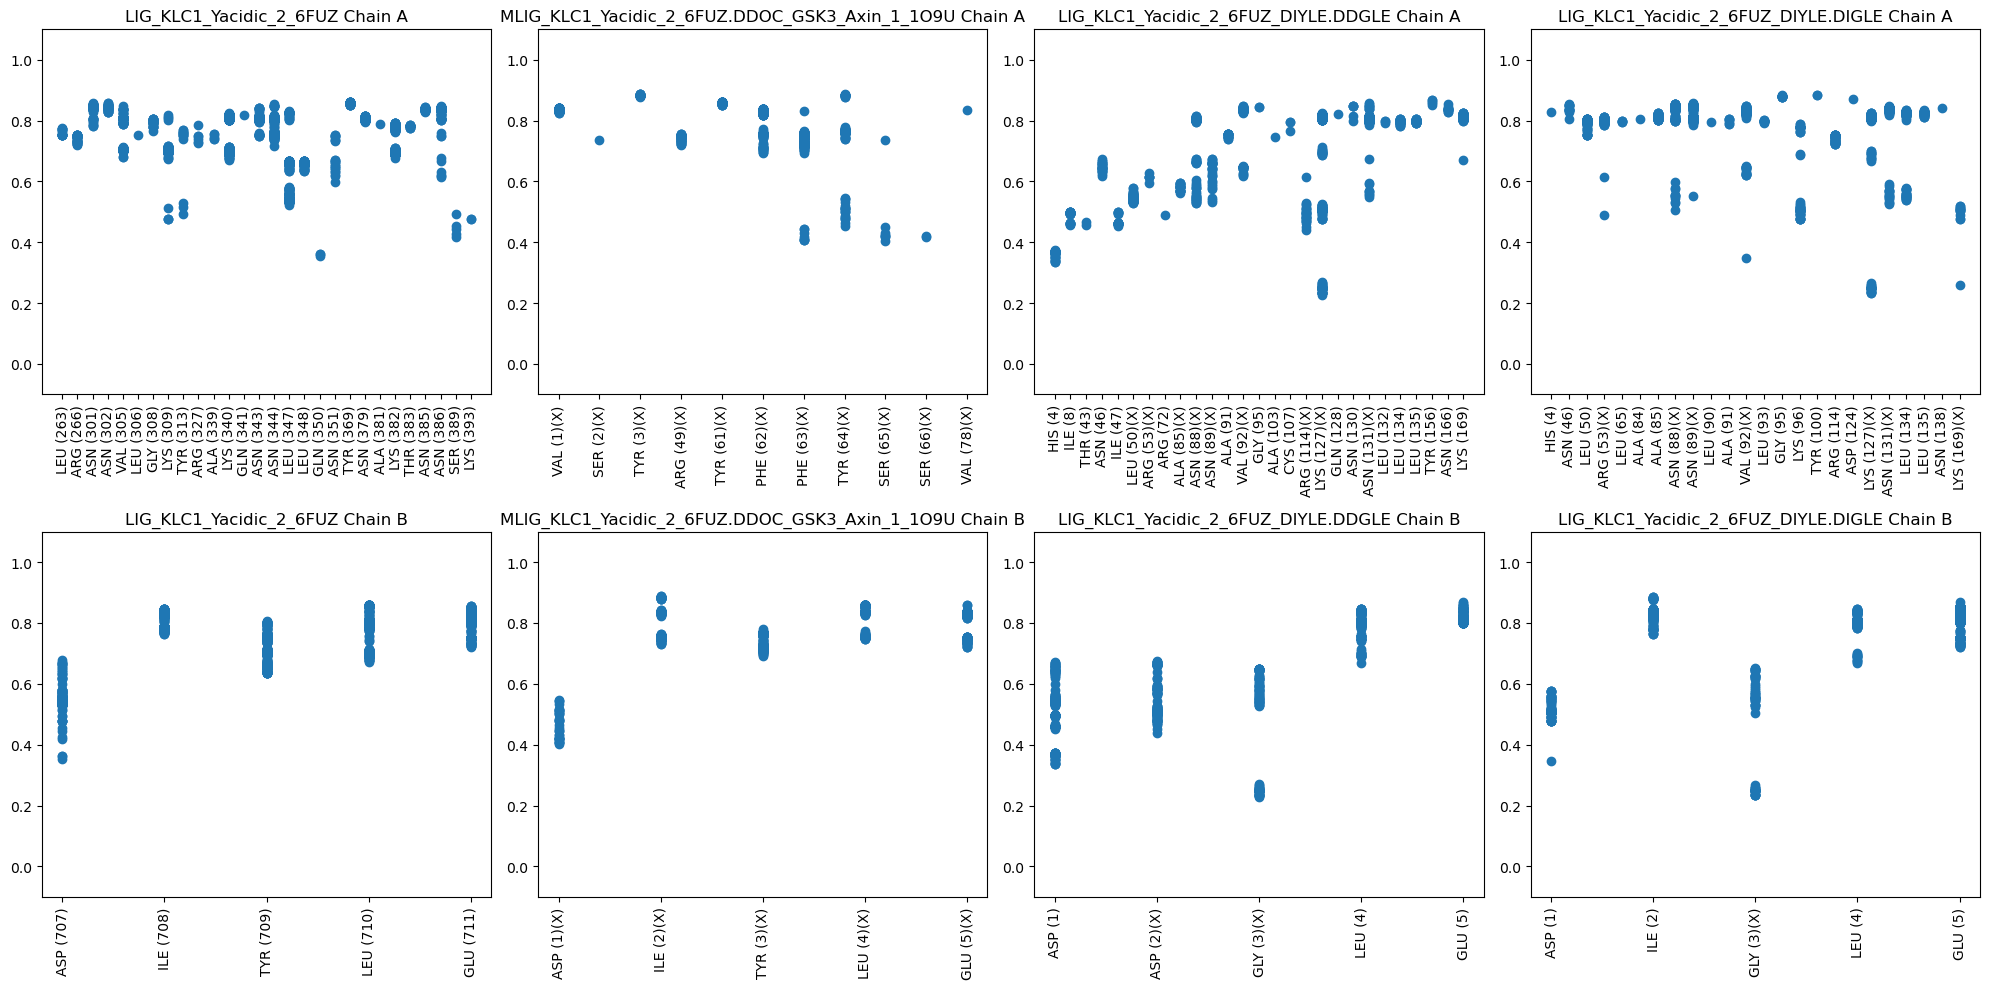

3


Empty DataFrame
Columns: [structure_name, PDB_id, ELM_instance, PDB_id_random_paired, ELM_instance_random_paired, sequence, sequence_mutated, interface]
Index: []

structure_name PDB_id        ELM_instance  \
156  MLIG_ActinCP_CPI_1_3AA1.DLIG_CID_NIM_1_2MOW   3AA1  MLIG_ActinCP_CPI_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
156                 2MOW             DLIG_CID_NIM_1     None             None   

                     interface  
156  <Interface of 1038 pairs>

structure_name PDB_id  \
333  LIG_ActinCP_CPI_1_3AA1_LAHPTRDRAKIQHSRRPPT.DAH...   3AA1   
334  LIG_ActinCP_CPI_1_3AA1_LAHPTRDRAKIQHSRRPPT.DAH...   3AA1   

          ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
333  LIG_ActinCP_CPI_1                 None                       None   
334  LIG_ActinCP_CPI_1                 None                       None   

                sequence     sequence_mutated                  interface  
333  LAHPTRDRAKIQHSRRPPT  DAHPTRDRAKIQHSRRPPT  <Interface of 3195 pairs>  
334  LAHPTRDRAKIQHSRRPPT  DAHPTRDRAKIQHSRRPWT  <Interface of 3160 pairs>

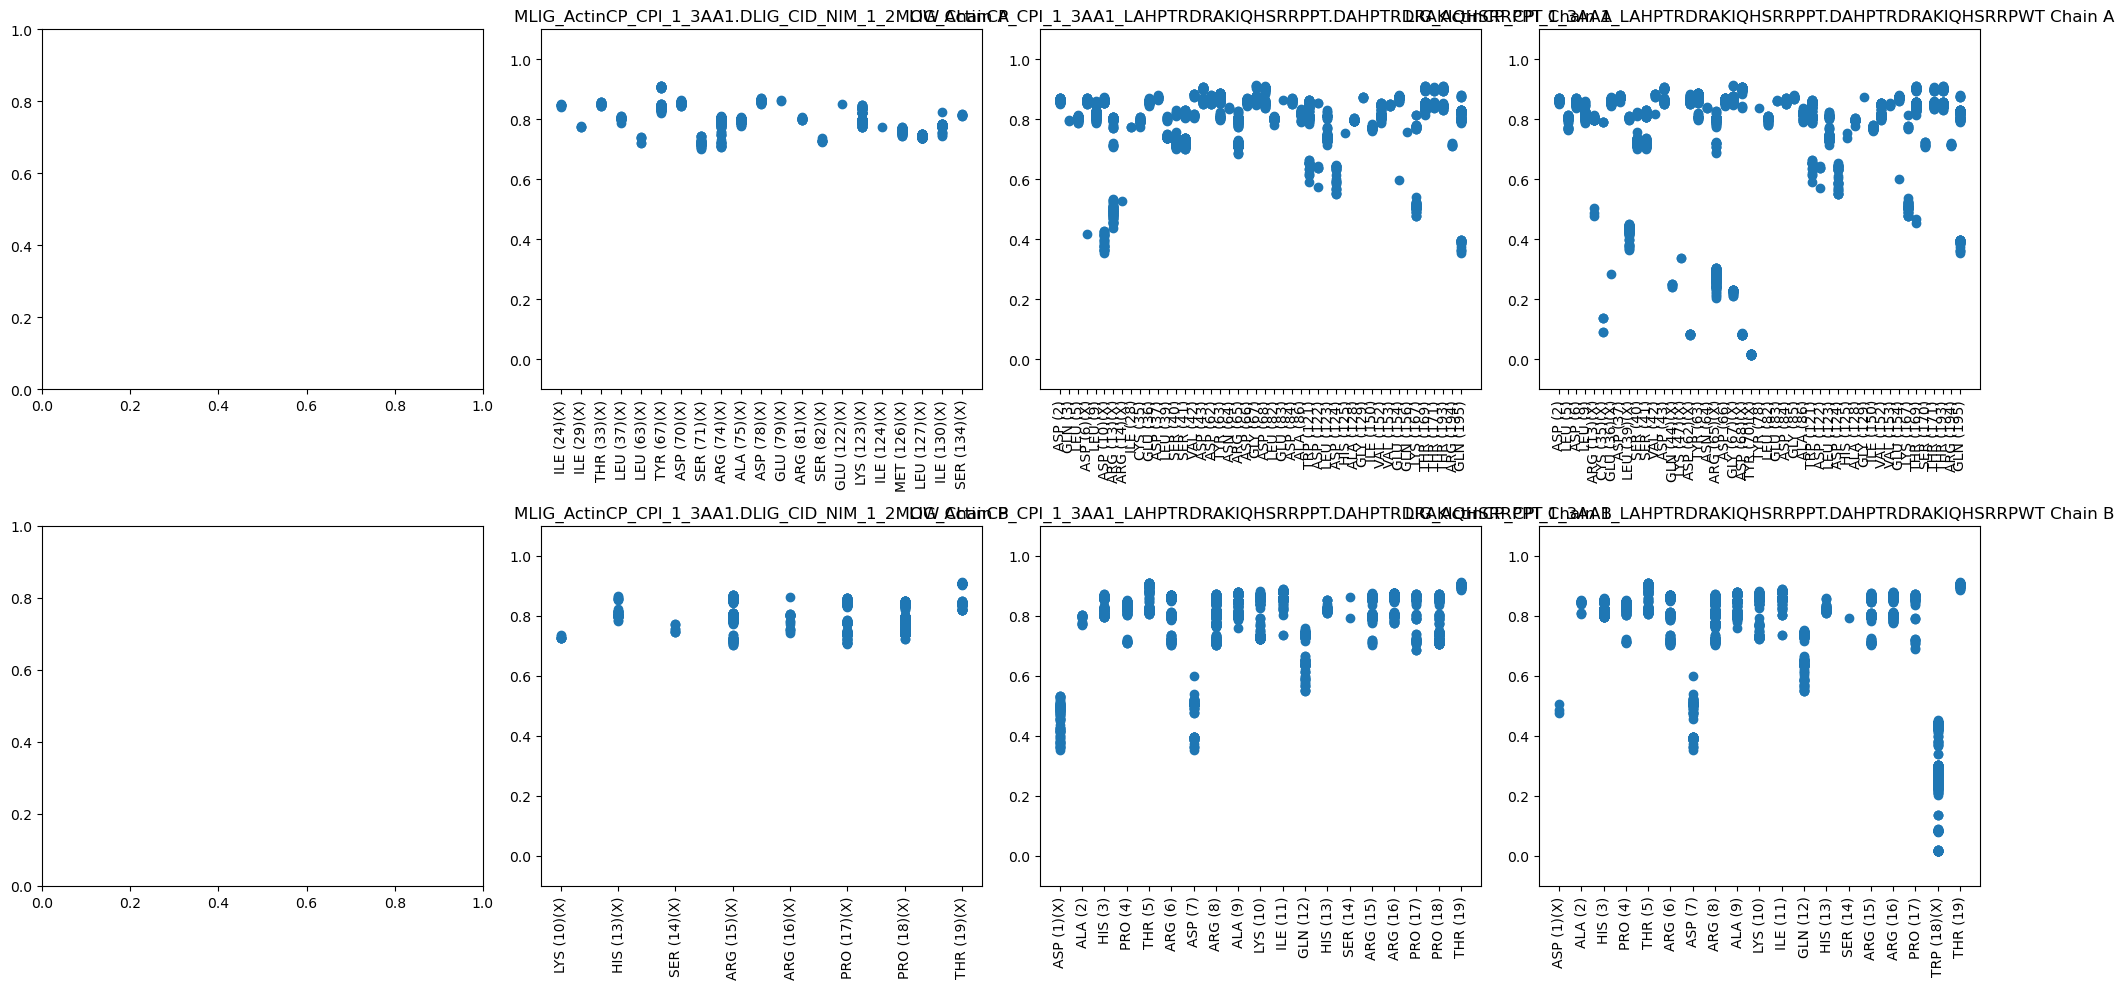

1


structure_name PDB_id      ELM_instance PDB_id_random_paired  \
34  LIG_Actin_RPEL_3_2V51   2V51  LIG_Actin_RPEL_3                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
34                       None     None             None   

                    interface  
34  <Interface of 1744 pairs>

Empty DataFrame
Columns: [structure_name, PDB_id, ELM_instance, PDB_id_random_paired, ELM_instance_random_paired, sequence, sequence_mutated, interface]
Index: []

Empty DataFrame
Columns: [structure_name, PDB_id, ELM_instance, PDB_id_random_paired, ELM_instance_random_paired, sequence, sequence_mutated, interface]
Index: []

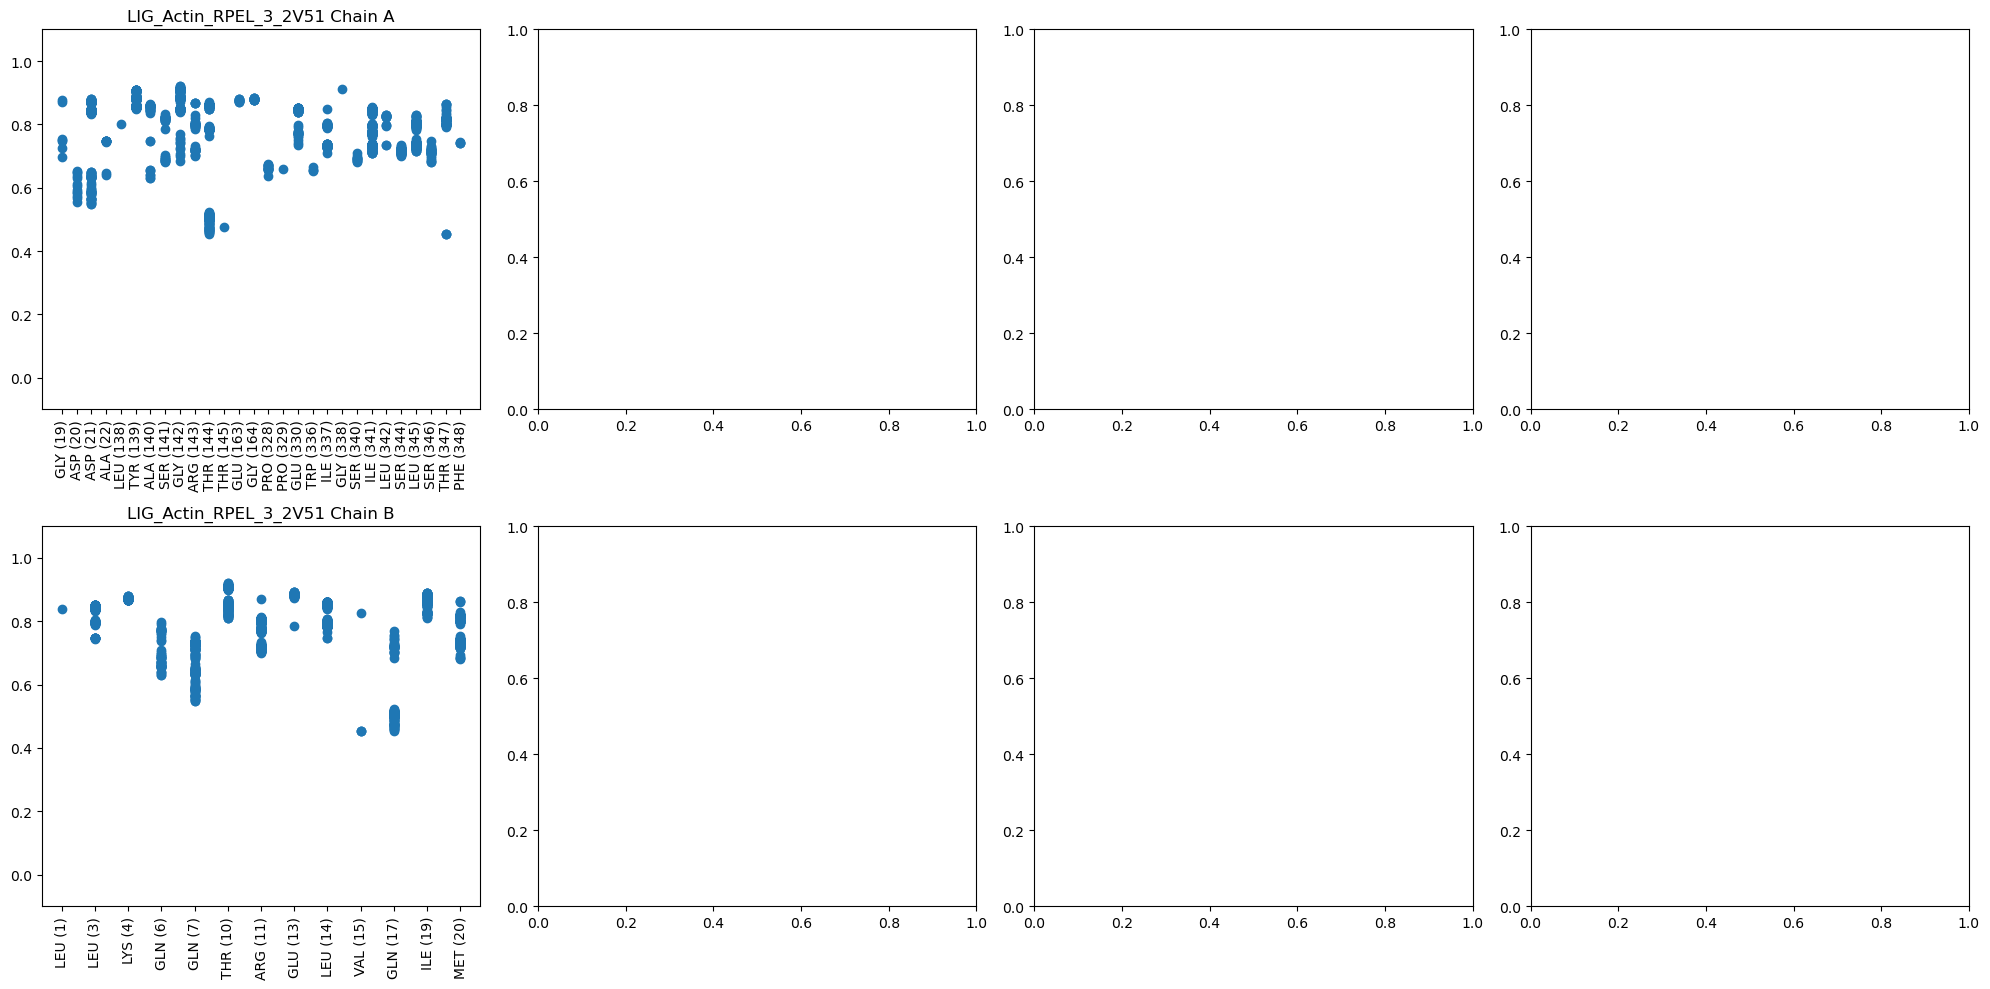

4


structure_name PDB_id         ELM_instance PDB_id_random_paired  \
31  LIG_14-3-3_ChREBP_3_5F74   5F74  LIG_14-3-3_ChREBP_3                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
31                       None     None             None   

                    interface  
31  <Interface of 1930 pairs>

structure_name PDB_id  \
155  MLIG_14-3-3_ChREBP_3_5F74.DDOC_MAPK_JIP1_4_4H3B   5F74   

             ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
155  MLIG_14-3-3_ChREBP_3                 4H3B           DDOC_MAPK_JIP1_4   

    sequence sequence_mutated                 interface  
155     None             None  <Interface of 952 pairs>

structure_name PDB_id  \
331  LIG_14-3-3_ChREBP_3_5F74_IRLNNAIWRAWYIQYV.IRLN...   5F74   
332  LIG_14-3-3_ChREBP_3_5F74_IRLNNAIWRAWYIQYV.IRLN...   5F74   

            ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
331  LIG_14-3-3_ChREBP_3                 None                       None   
332  LIG_14-3-3_ChREBP_3                 None                       None   

             sequence  sequence_mutated                  interface  
331  IRLNNAIWRAWYIQYV  IRLNNAIWRAWYDQYD  <Interface of 2294 pairs>  
332  IRLNNAIWRAWYIQYV  IRLNNAIWRAWYIQYD  <Interface of 2797 pairs>

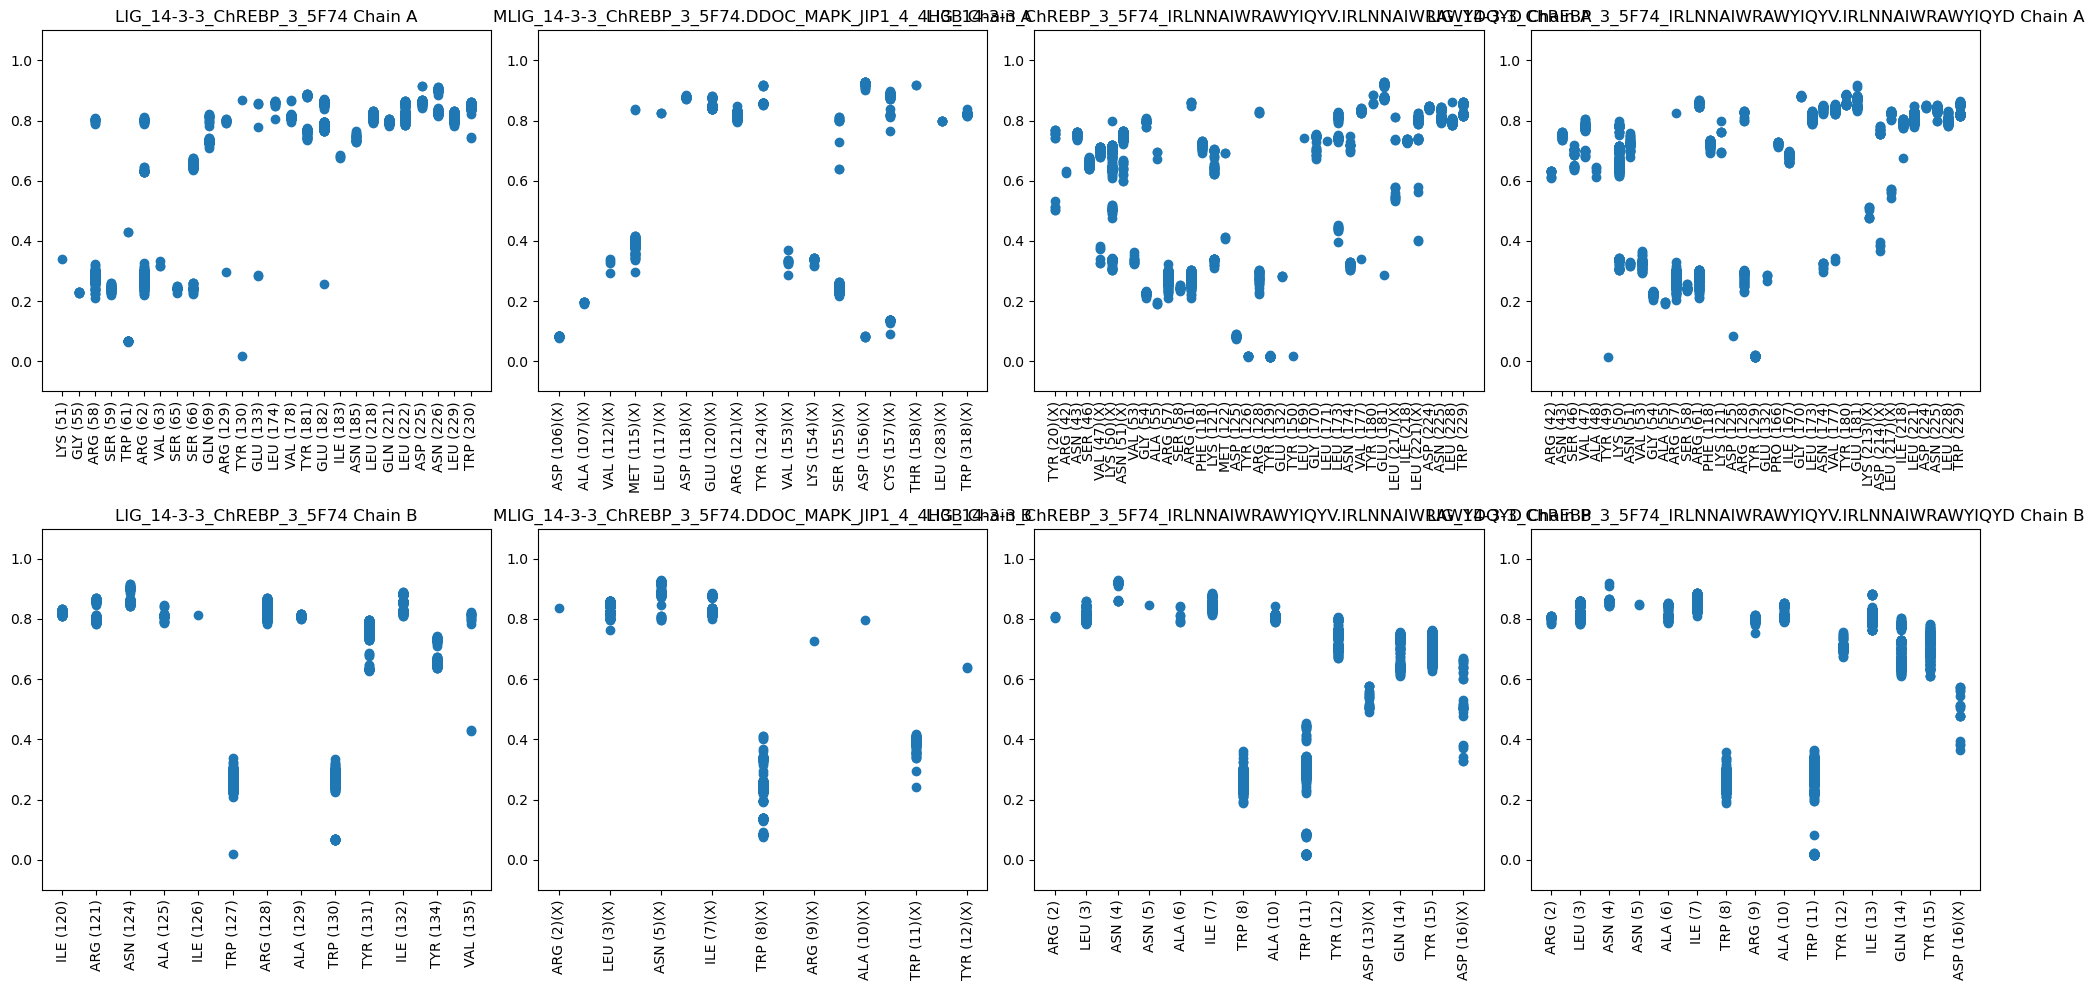

4


structure_name PDB_id    ELM_instance PDB_id_random_paired  \
41  LIG_ARL_BART_1_4ZI2   4ZI2  LIG_ARL_BART_1                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
41                       None     None             None   

                    interface  
41  <Interface of 1614 pairs>

structure_name PDB_id     ELM_instance  \
164  MLIG_ARL_BART_1_4ZI2.DLIG_LYPXL_SIV_4_2XS1   4ZI2  MLIG_ARL_BART_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
164                 2XS1           DLIG_LYPXL_SIV_4     None             None   

                    interface  
164  <Interface of 157 pairs>

structure_name PDB_id    ELM_instance  \
351  LIG_ARL_BART_1_4ZI2_LLSILRKL.DLSIDRKL   4ZI2  LIG_ARL_BART_1   
352  LIG_ARL_BART_1_4ZI2_LLSILRKL.LLSIDRKL   4ZI2  LIG_ARL_BART_1   

    PDB_id_random_paired ELM_instance_random_paired  sequence  \
351                 None                       None  LLSILRKL   
352                 None                       None  LLSILRKL   

    sequence_mutated                  interface  
351         DLSIDRKL  <Interface of 1292 pairs>  
352         LLSIDRKL  <Interface of 1145 pairs>

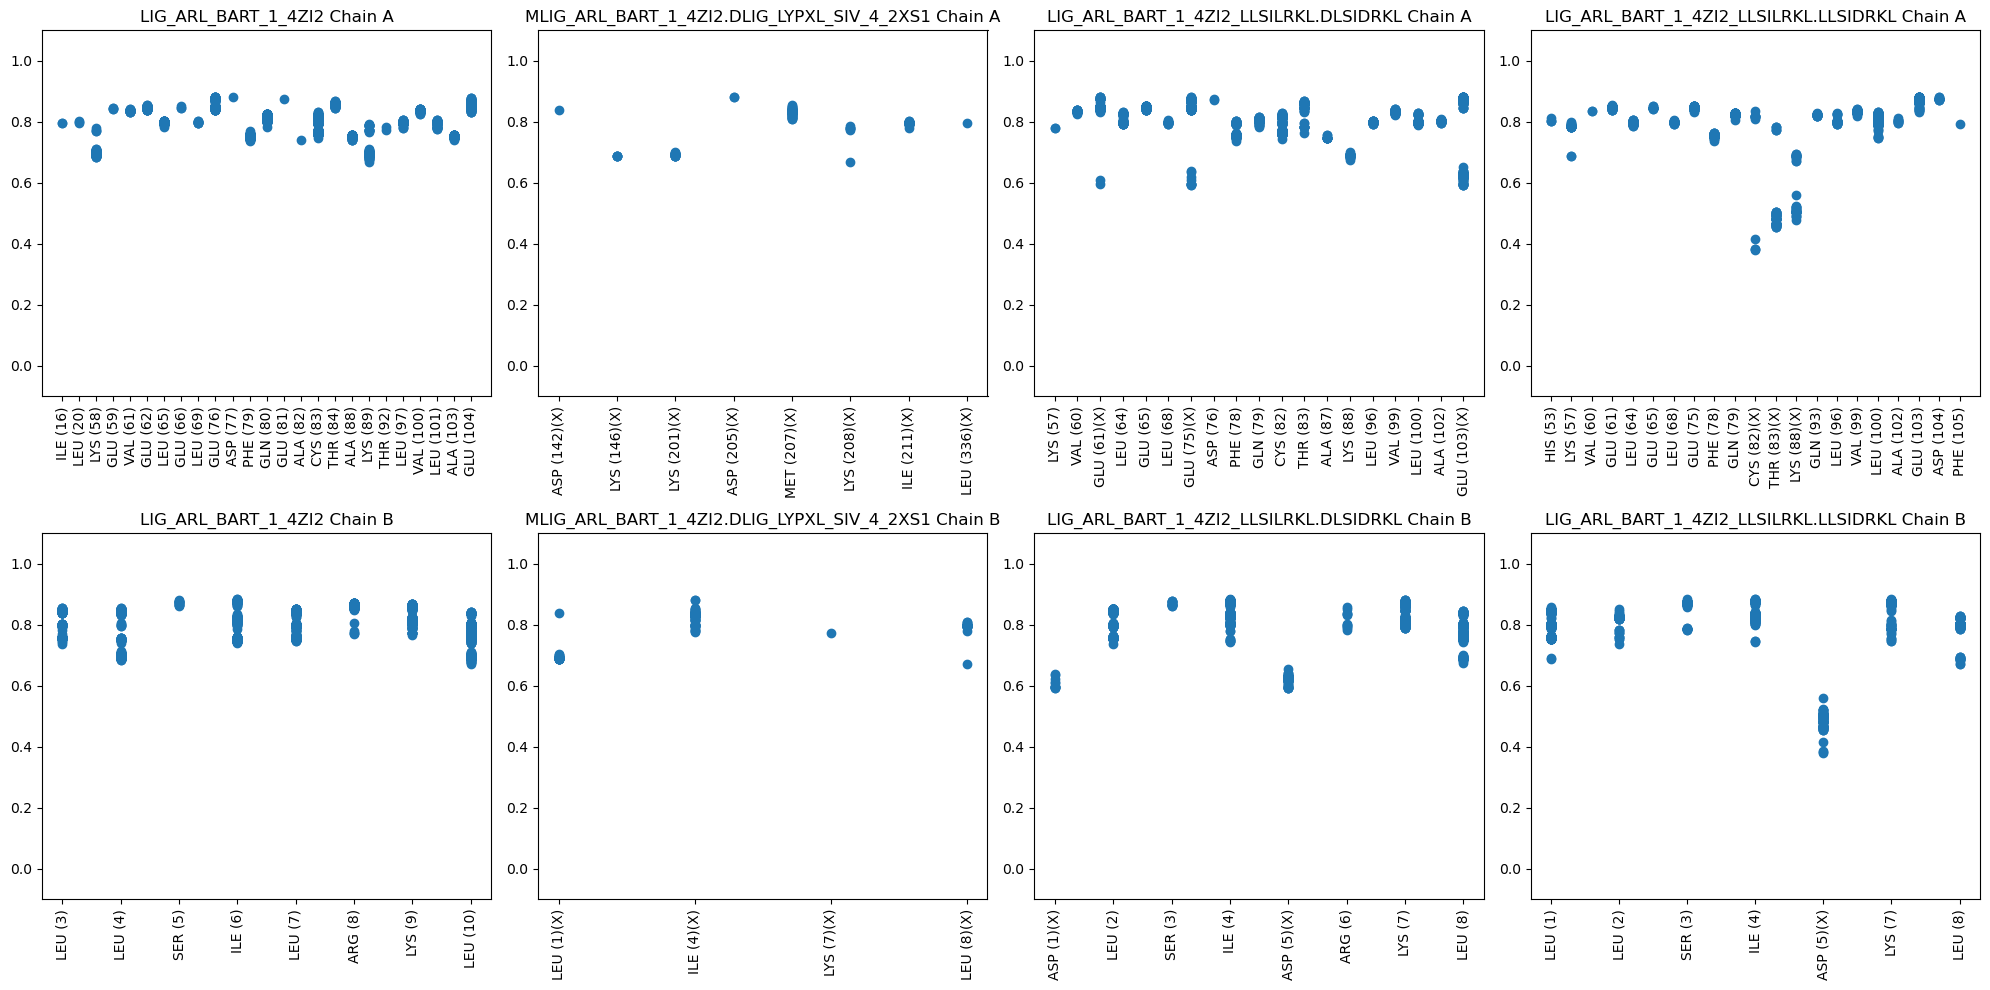

4


structure_name PDB_id ELM_instance PDB_id_random_paired  \
116  LIG_TRAF2_1_1CA9   1CA9  LIG_TRAF2_1                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
116                       None     None             None   

                    interface  
116  <Interface of 921 pairs>

structure_name PDB_id  ELM_instance  \
238  MLIG_TRAF2_1_1CA9.DLIG_BIR_III_3_1JD5   1CA9  MLIG_TRAF2_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
238                 1JD5             DLIG_BIR_III_3     None             None   

                    interface  
238  <Interface of 891 pairs>

structure_name PDB_id ELM_instance PDB_id_random_paired  \
495  LIG_TRAF2_1_1CA9_SKEE.SKWE   1CA9  LIG_TRAF2_1                 None   
496  LIG_TRAF2_1_1CA9_SKEE.SKWW   1CA9  LIG_TRAF2_1                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
495                       None     SKEE             SKWE   
496                       None     SKEE             SKWW   

                    interface  
495  <Interface of 764 pairs>  
496  <Interface of 716 pairs>

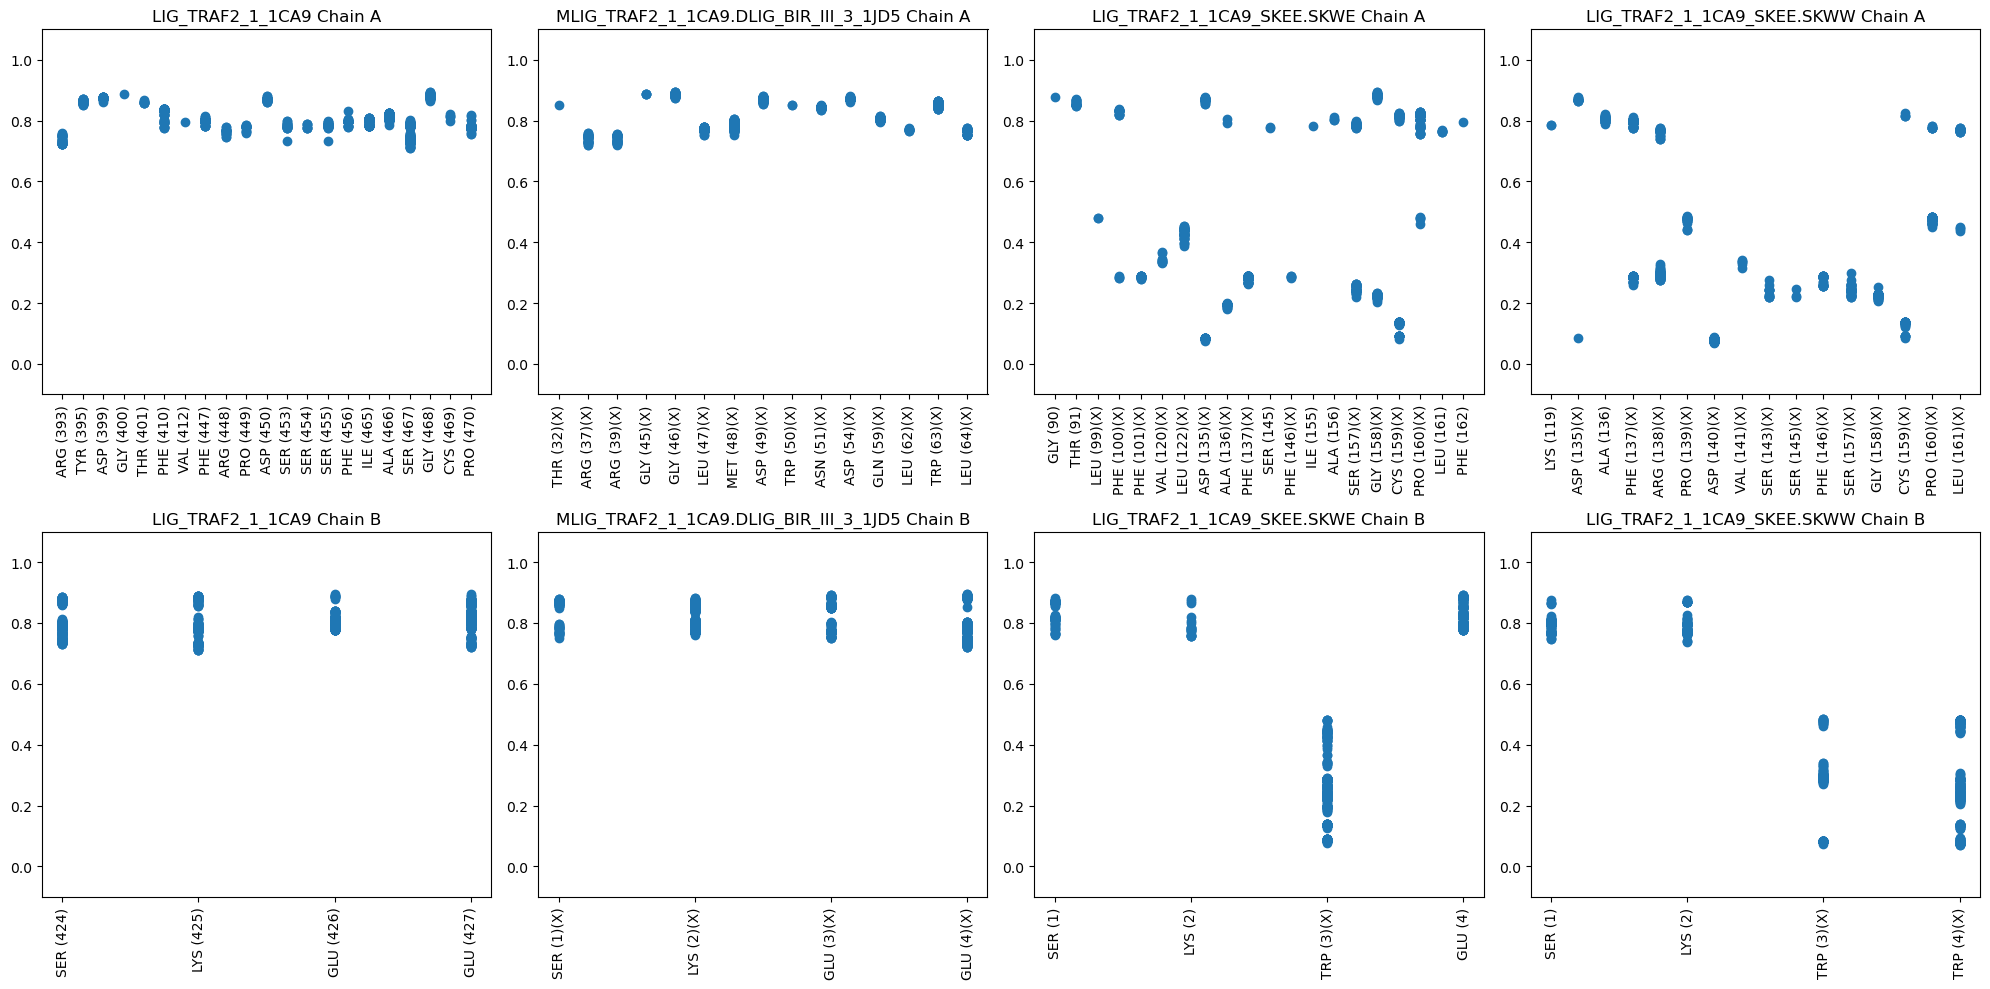

4


structure_name PDB_id    ELM_instance PDB_id_random_paired  \
39  LIG_AP2alpha_2_1KYU   1KYU  LIG_AP2alpha_2                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
39                       None     None             None   

                   interface  
39  <Interface of 779 pairs>

structure_name PDB_id     ELM_instance  \
162  MLIG_AP2alpha_2_1KYU.DLIG_TRAF2_2_1CZY   1KYU  MLIG_AP2alpha_2   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
162                 1CZY               DLIG_TRAF2_2     None             None   

                    interface  
162  <Interface of 590 pairs>

structure_name PDB_id    ELM_instance  \
347  LIG_AP2alpha_2_1KYU_DPFK.DWFK   1KYU  LIG_AP2alpha_2   
348  LIG_AP2alpha_2_1KYU_DPFK.WWFK   1KYU  LIG_AP2alpha_2   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
347                 None                       None     DPFK             DWFK   
348                 None                       None     DPFK             WWFK   

                    interface  
347  <Interface of 219 pairs>  
348  <Interface of 165 pairs>

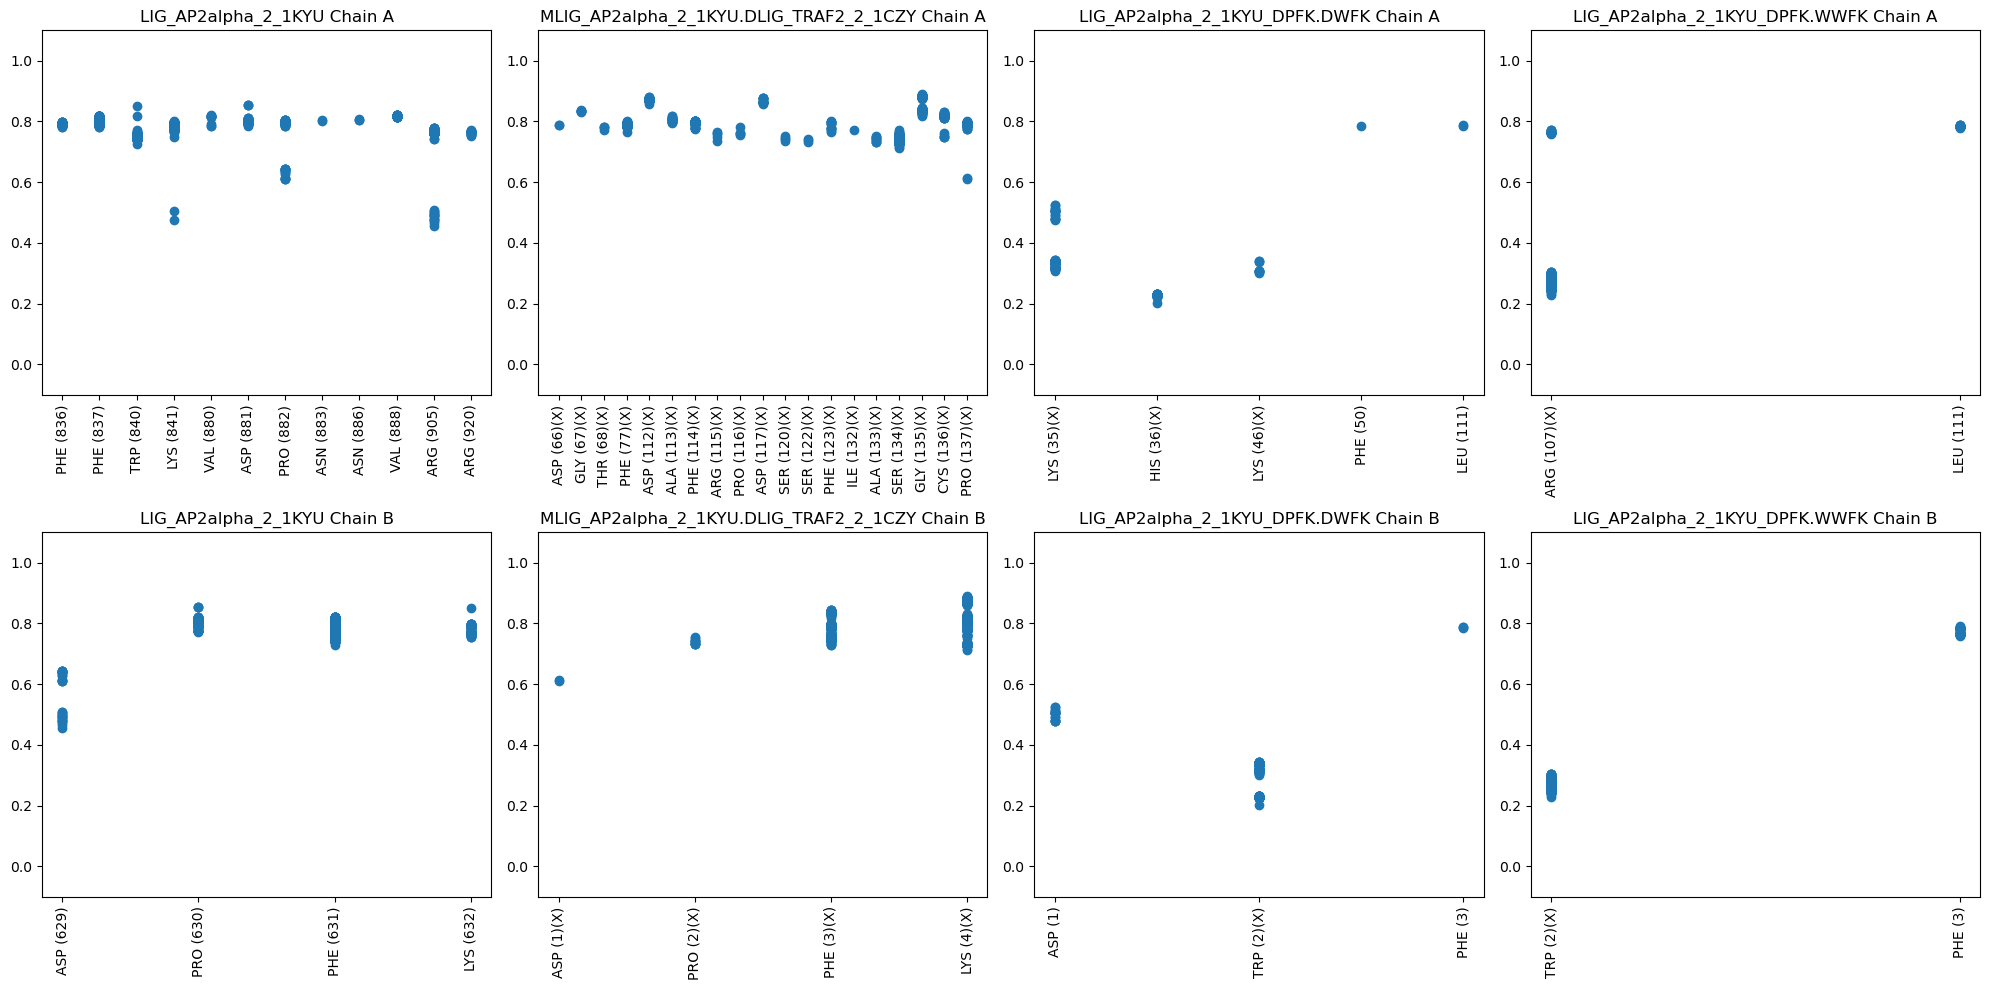

4


structure_name PDB_id ELM_instance PDB_id_random_paired  \
88  LIG_PAM2_1_1JGN   1JGN   LIG_PAM2_1                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
88                       None     None             None   

                    interface  
88  <Interface of 1862 pairs>

structure_name PDB_id ELM_instance  \
211  MLIG_PAM2_1_1JGN.DMOD_CDK_SPxK_1_2CCI   1JGN  MLIG_PAM2_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
211                 2CCI            DMOD_CDK_SPxK_1     None             None   

                     interface  
211  <Interface of 1197 pairs>

structure_name PDB_id ELM_instance  \
441  LIG_PAM2_1_1JGN_SNLNPNAKEFVPG.SNLNWNAKEFVPG   1JGN   LIG_PAM2_1   
442  LIG_PAM2_1_1JGN_SNLNPNAKEFVPG.SNLNWNWKEFVPG   1JGN   LIG_PAM2_1   

    PDB_id_random_paired ELM_instance_random_paired       sequence  \
441                 None                       None  SNLNPNAKEFVPG   
442                 None                       None  SNLNPNAKEFVPG   

    sequence_mutated                  interface  
441    SNLNWNAKEFVPG  <Interface of 1920 pairs>  
442    SNLNWNWKEFVPG  <Interface of 1409 pairs>

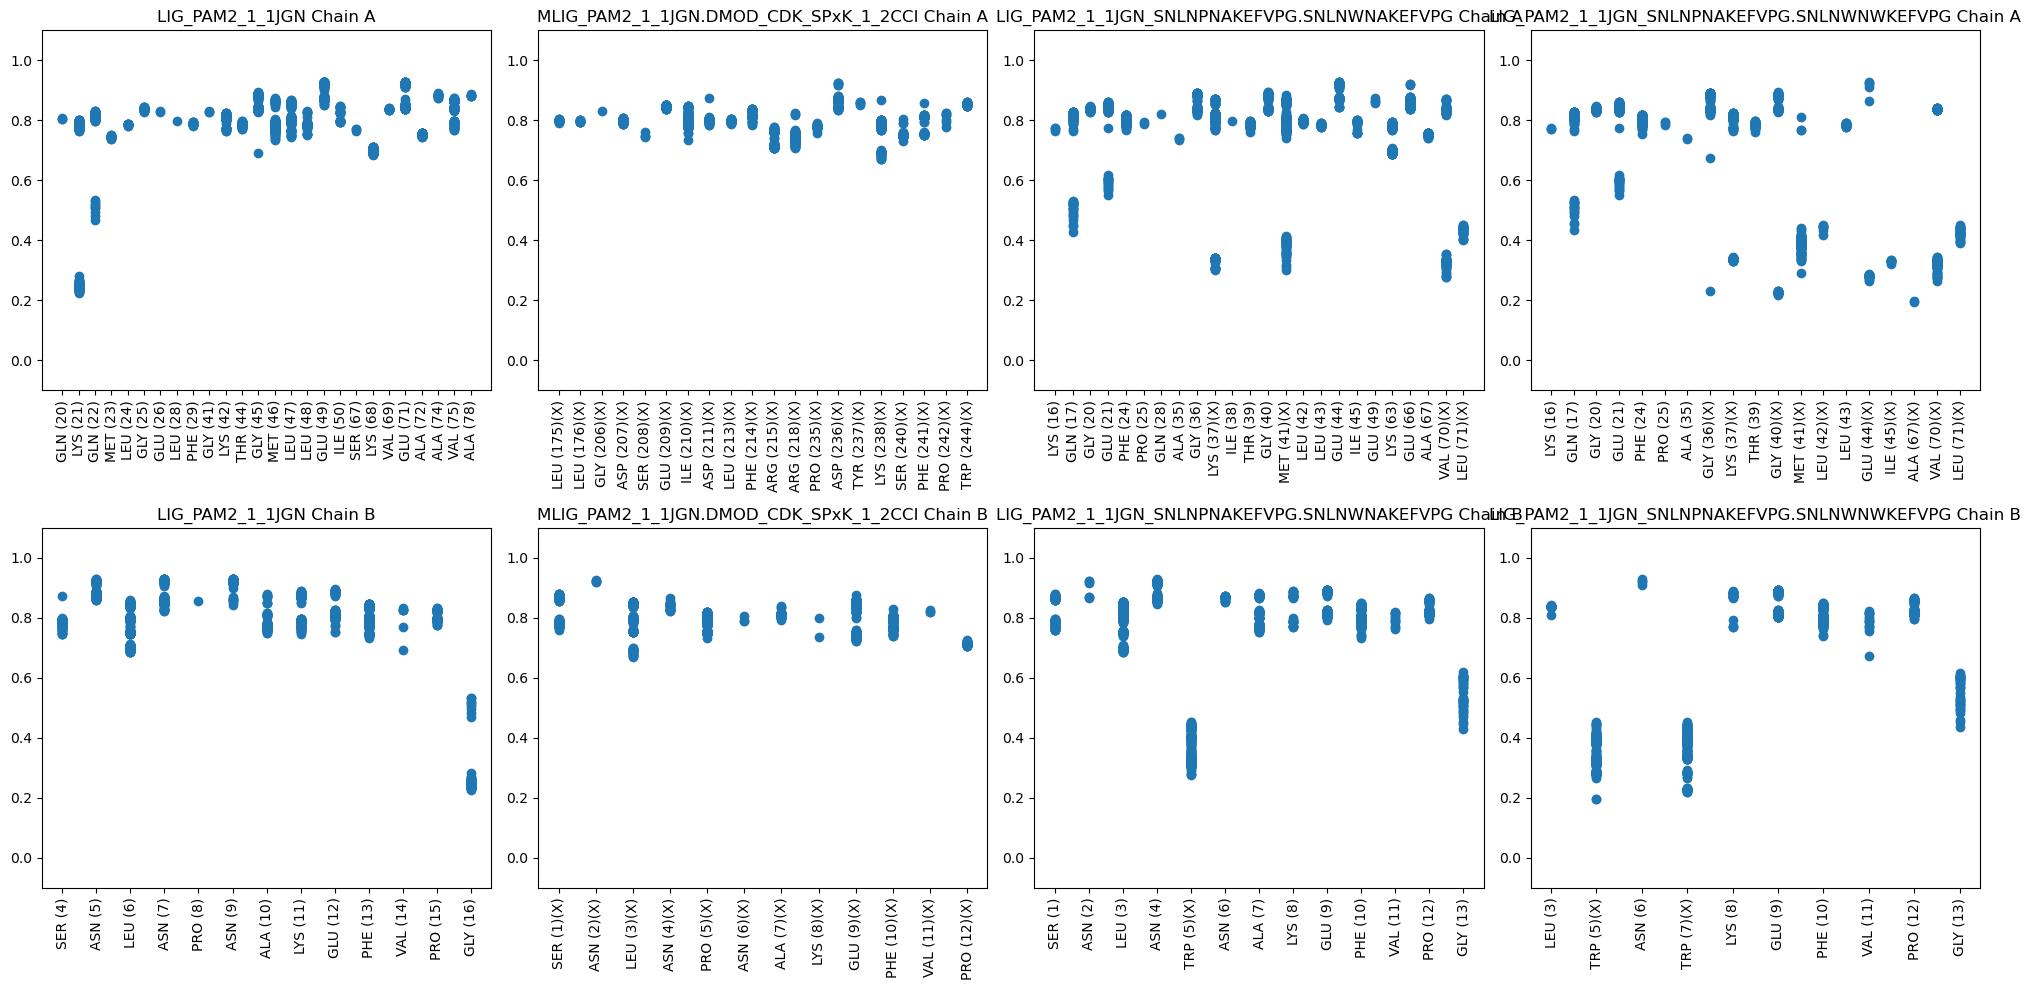

3


Empty DataFrame
Columns: [structure_name, PDB_id, ELM_instance, PDB_id_random_paired, ELM_instance_random_paired, sequence, sequence_mutated, interface]
Index: []

structure_name PDB_id  \
157  MLIG_Actin_RPEL_3_2V52.DLIG_ActinCP_TwfCPI_2_7DS2   2V52   

          ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
157  MLIG_Actin_RPEL_3                 7DS2      DLIG_ActinCP_TwfCPI_2   

    sequence sequence_mutated                  interface  
157     None             None  <Interface of 3866 pairs>

structure_name PDB_id  \
337  LIG_Actin_RPEL_3_2V52_LKRKIRSRPERAELVRMHIL.LKR...   2V52   
338  LIG_Actin_RPEL_3_2V52_LKRKIRSRPERAELVRMHIL.LKR...   2V52   

         ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
337  LIG_Actin_RPEL_3                 None                       None   
338  LIG_Actin_RPEL_3                 None                       None   

                 sequence      sequence_mutated                  interface  
337  LKRKIRSRPERAELVRMHIL  LKRKIRSGPERAELVRMHDL  <Interface of 1772 pairs>  
338  LKRKIRSRPERAELVRMHIL  LKRKIRSGPERAELVRMHIL  <Interface of 1553 pairs>

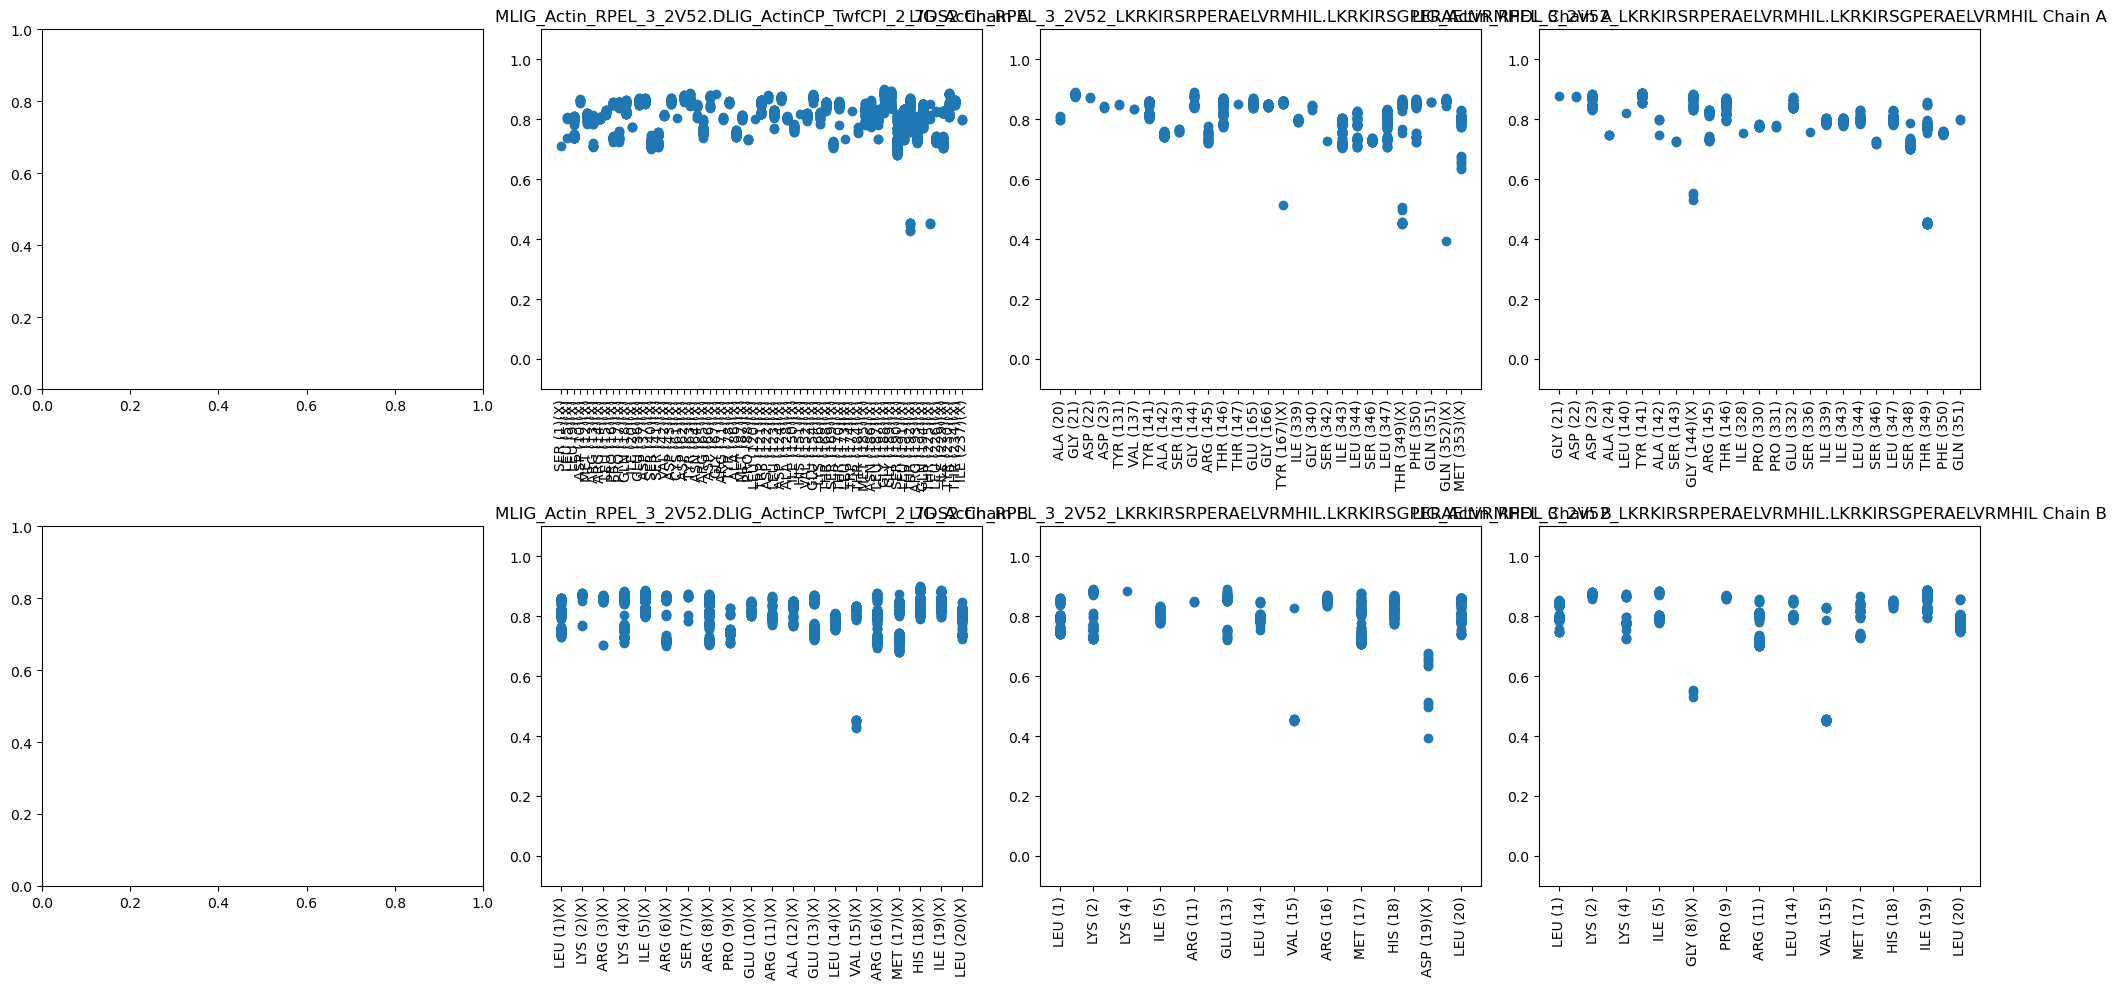

4


structure_name PDB_id       ELM_instance PDB_id_random_paired  \
2  DEG_Kelch_Keap1_1_2FLU   2FLU  DEG_Kelch_Keap1_1                 None   

  ELM_instance_random_paired sequence sequence_mutated  \
2                       None     None             None   

                   interface  
2  <Interface of 1138 pairs>

structure_name PDB_id  \
126  MDEG_Kelch_Keap1_1_2FLU.DLIG_DLG_GKlike_1_3WP0   2FLU   

           ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
126  MDEG_Kelch_Keap1_1                 3WP0          DLIG_DLG_GKlike_1   

    sequence sequence_mutated                 interface  
126     None             None  <Interface of 516 pairs>

structure_name PDB_id       ELM_instance  \
273  DEG_Kelch_Keap1_1_2FLU_DEETGE.DEETWE   2FLU  DEG_Kelch_Keap1_1   
274  DEG_Kelch_Keap1_1_2FLU_DEETGE.DEEWWE   2FLU  DEG_Kelch_Keap1_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
273                 None                       None   DEETGE           DEETWE   
274                 None                       None   DEETGE           DEEWWE   

                     interface  
273  <Interface of 1733 pairs>  
274  <Interface of 1824 pairs>

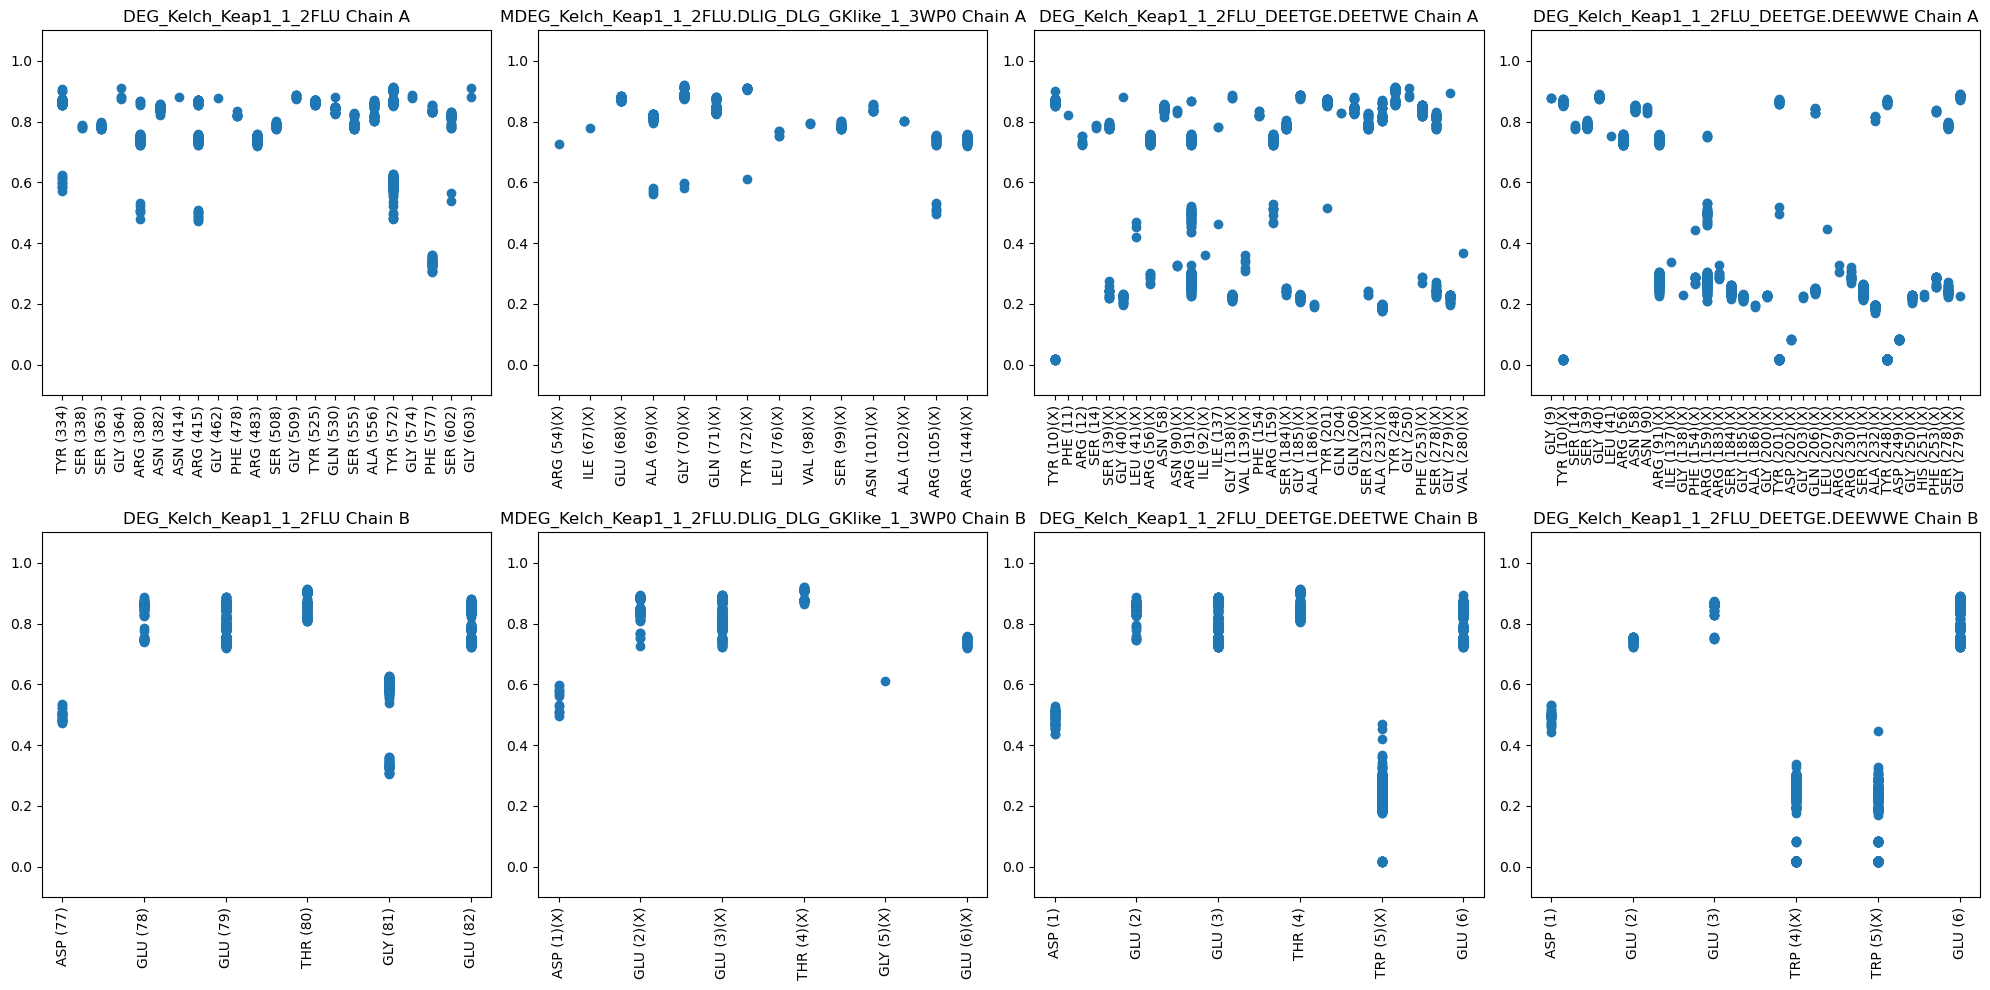

4


structure_name PDB_id     ELM_instance PDB_id_random_paired  \
77  LIG_LSD1_SNAG_1_2Y48   2Y48  LIG_LSD1_SNAG_1                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
77                       None     None             None   

                    interface  
77  <Interface of 2072 pairs>

structure_name PDB_id      ELM_instance  \
200  MLIG_LSD1_SNAG_1_2Y48.DLIG_EF_ALG2_ABM_1_2ZNE   2Y48  MLIG_LSD1_SNAG_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
200                 2ZNE         DLIG_EF_ALG2_ABM_1     None             None   

                     interface  
200  <Interface of 1312 pairs>

structure_name PDB_id     ELM_instance  \
419  LIG_LSD1_SNAG_1_2Y48_PRSFLVRKP.PRSDDVRKP   2Y48  LIG_LSD1_SNAG_1   
420  LIG_LSD1_SNAG_1_2Y48_PRSFLVRKP.PRSDLVRKP   2Y48  LIG_LSD1_SNAG_1   

    PDB_id_random_paired ELM_instance_random_paired   sequence  \
419                 None                       None  PRSFLVRKP   
420                 None                       None  PRSFLVRKP   

    sequence_mutated                  interface  
419        PRSDDVRKP  <Interface of 1903 pairs>  
420        PRSDLVRKP  <Interface of 1802 pairs>

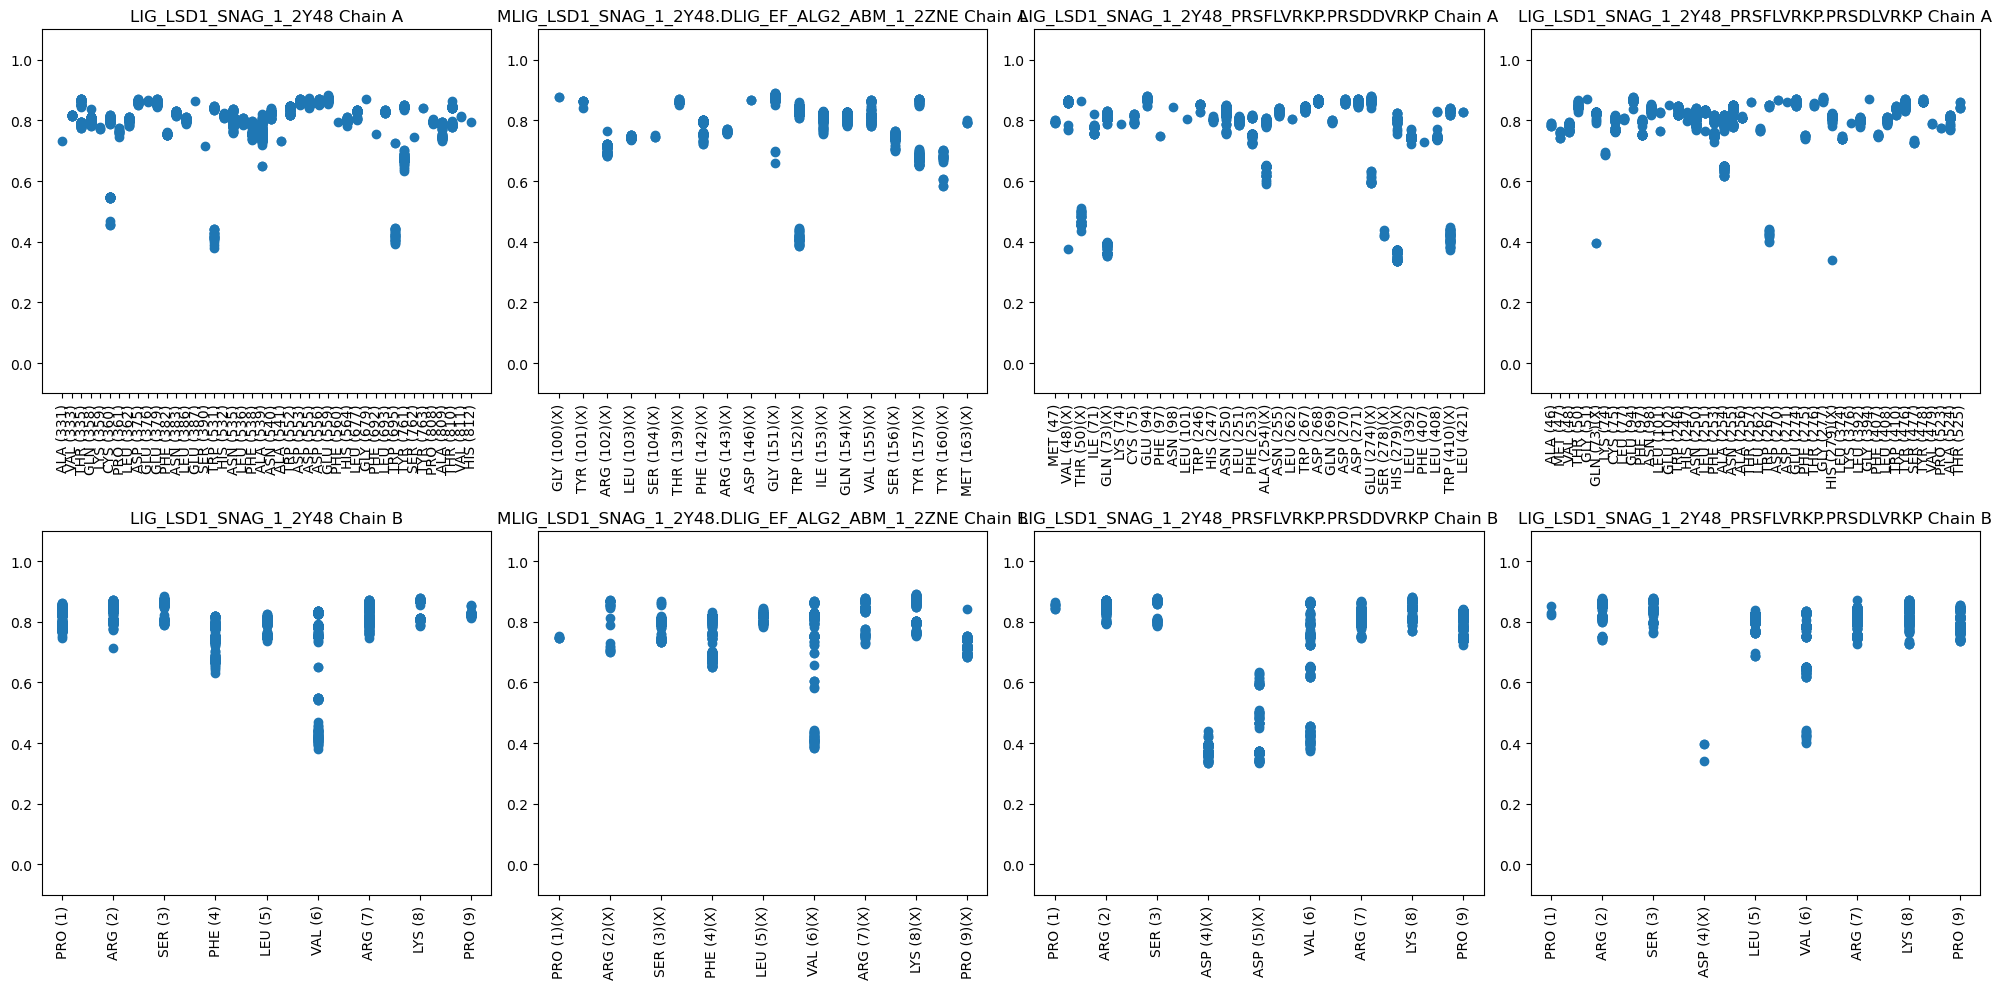

4


structure_name PDB_id    ELM_instance PDB_id_random_paired  \
7  DEG_SCF_TIR1_1_2P1Q   2P1Q  DEG_SCF_TIR1_1                 None   

  ELM_instance_random_paired sequence sequence_mutated  \
7                       None     None             None   

                   interface  
7  <Interface of 1778 pairs>

structure_name PDB_id     ELM_instance  \
131  MDEG_SCF_TIR1_1_2P1Q.DLIG_ULM_U2AF65_1_1O0P   2P1Q  MDEG_SCF_TIR1_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
131                 1O0P          DLIG_ULM_U2AF65_1     None             None   

                     interface  
131  <Interface of 1429 pairs>

structure_name PDB_id    ELM_instance  \
283  DEG_SCF_TIR1_1_2P1Q_QVVGWPPVRNYRK.QVDGWPPDRNYRK   2P1Q  DEG_SCF_TIR1_1   
284  DEG_SCF_TIR1_1_2P1Q_QVVGWPPVRNYRK.QVDGWPPVRNYRK   2P1Q  DEG_SCF_TIR1_1   

    PDB_id_random_paired ELM_instance_random_paired       sequence  \
283                 None                       None  QVVGWPPVRNYRK   
284                 None                       None  QVVGWPPVRNYRK   

    sequence_mutated                  interface  
283    QVDGWPPDRNYRK  <Interface of 3021 pairs>  
284    QVDGWPPVRNYRK  <Interface of 2426 pairs>

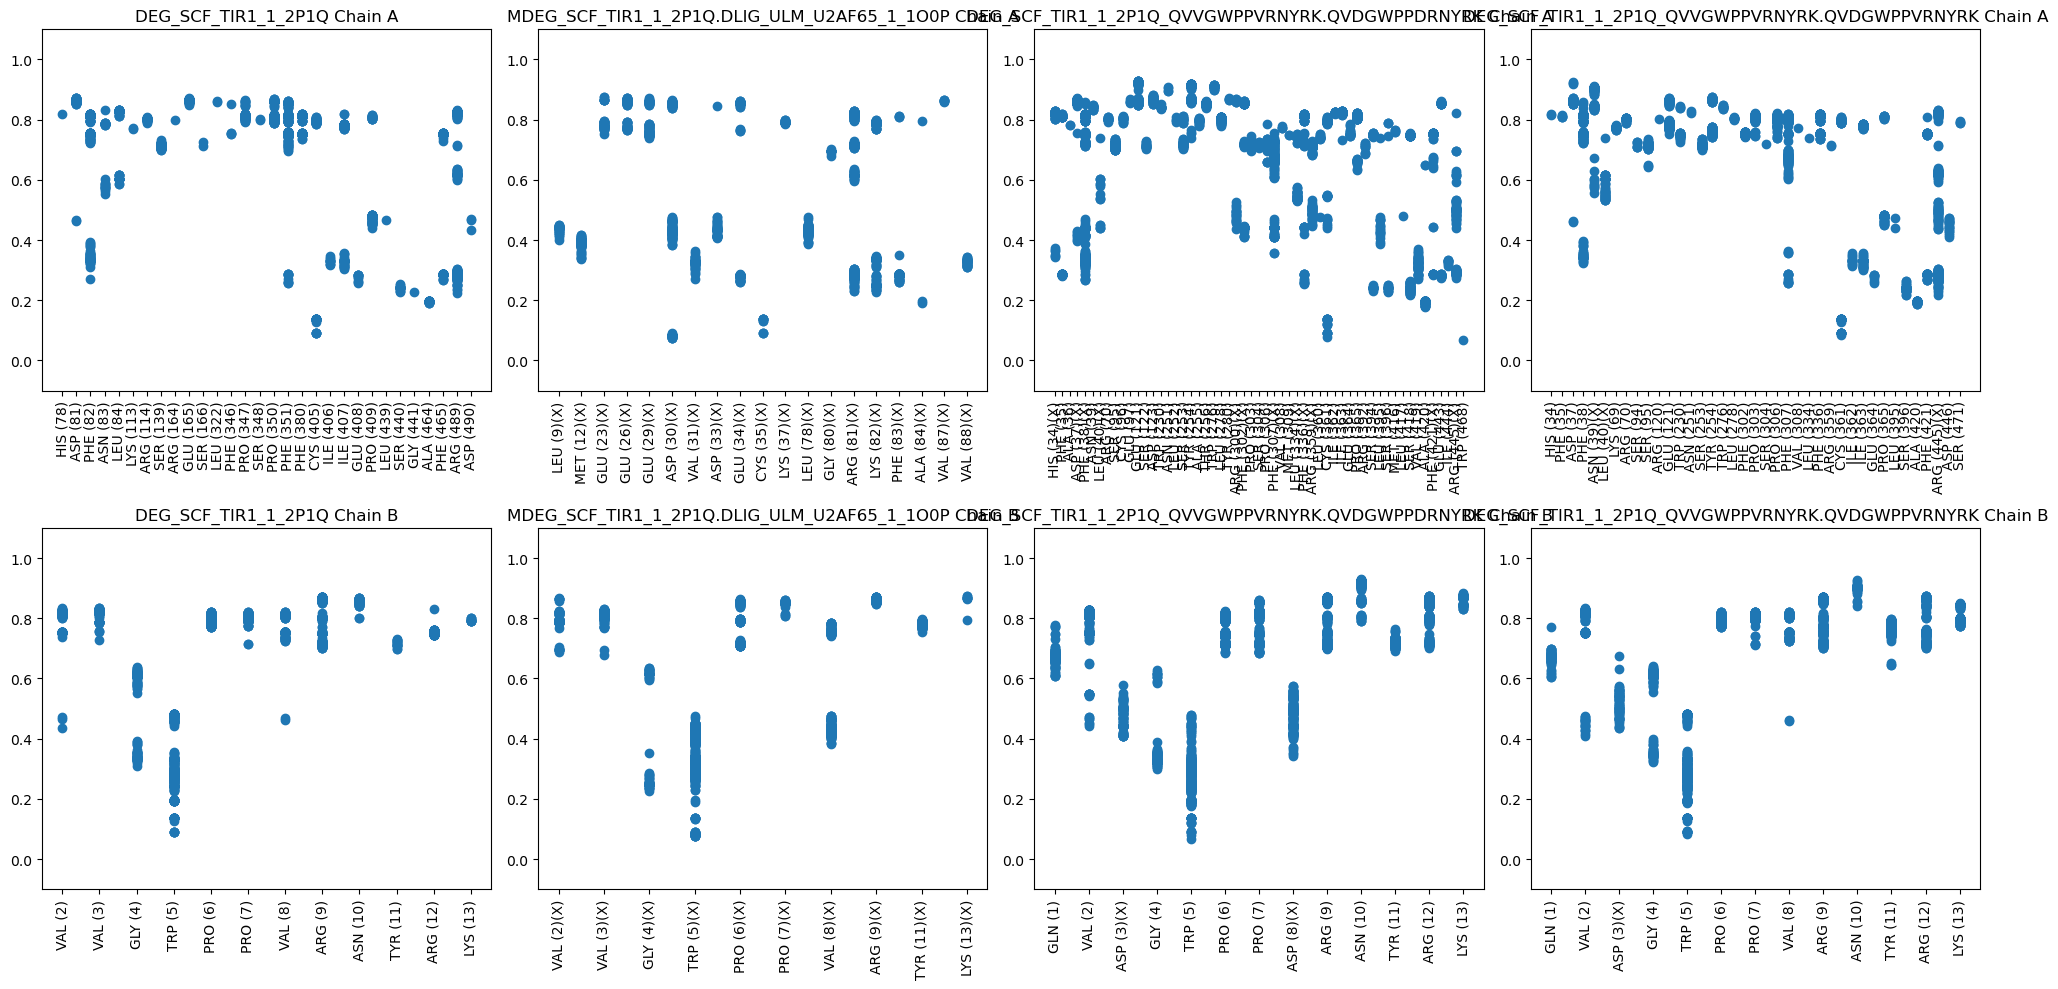

4


structure_name PDB_id      ELM_instance PDB_id_random_paired  \
20  DOC_MAPK_NFAT4_5_2XS0   2XS0  DOC_MAPK_NFAT4_5                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
20                       None     None             None   

                    interface  
20  <Interface of 1746 pairs>

structure_name PDB_id       ELM_instance  \
144  MDOC_MAPK_NFAT4_5_2XS0.DLIG_PDZ_Class_3_1B8Q   2XS0  MDOC_MAPK_NFAT4_5   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
144                 1B8Q           DLIG_PDZ_Class_3     None             None   

                     interface  
144  <Interface of 1569 pairs>

structure_name PDB_id      ELM_instance  \
309  DOC_MAPK_NFAT4_5_2XS0_RDHLYLPLE.GDHLYDPLE   2XS0  DOC_MAPK_NFAT4_5   
310  DOC_MAPK_NFAT4_5_2XS0_RDHLYLPLE.RDHLYDPLE   2XS0  DOC_MAPK_NFAT4_5   

    PDB_id_random_paired ELM_instance_random_paired   sequence  \
309                 None                       None  RDHLYLPLE   
310                 None                       None  RDHLYLPLE   

    sequence_mutated                  interface  
309        GDHLYDPLE  <Interface of 1186 pairs>  
310        RDHLYDPLE  <Interface of 1161 pairs>

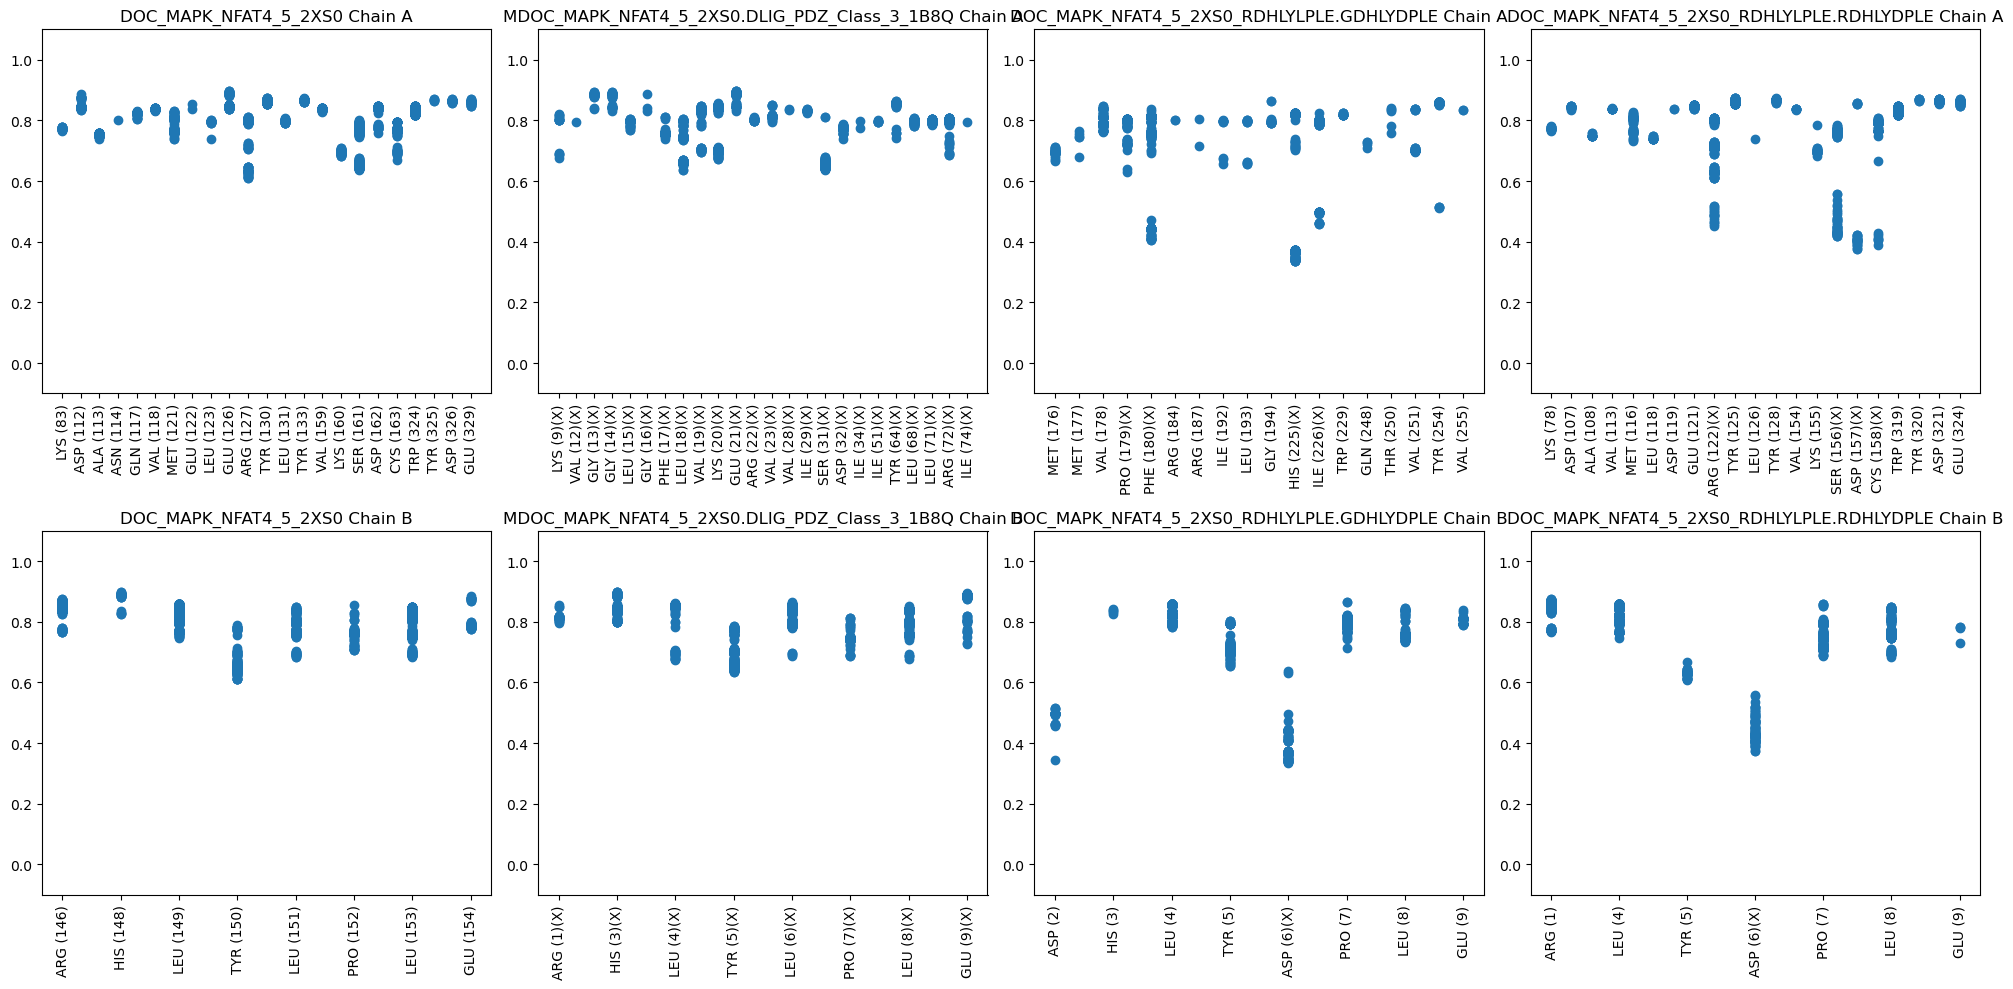

4


structure_name PDB_id  ELM_instance PDB_id_random_paired  \
68  LIG_HOMEOBOX_1B72   1B72  LIG_HOMEOBOX                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
68                       None     None             None   

                   interface  
68  <Interface of 794 pairs>

structure_name PDB_id   ELM_instance  \
191  MLIG_HOMEOBOX_1B72.DLIG_Vh1_VBS_1_1SYQ   1B72  MLIG_HOMEOBOX   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
191                 1SYQ             DLIG_Vh1_VBS_1     None             None   

                    interface  
191  <Interface of 653 pairs>

structure_name PDB_id  ELM_instance PDB_id_random_paired  \
403  LIG_HOMEOBOX_1B72_FDWM.FDWD   1B72  LIG_HOMEOBOX                 None   
404  LIG_HOMEOBOX_1B72_FDWM.FWWD   1B72  LIG_HOMEOBOX                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
403                       None     FDWM             FDWD   
404                       None     FDWM             FWWD   

                    interface  
403  <Interface of 194 pairs>  
404  <Interface of 686 pairs>

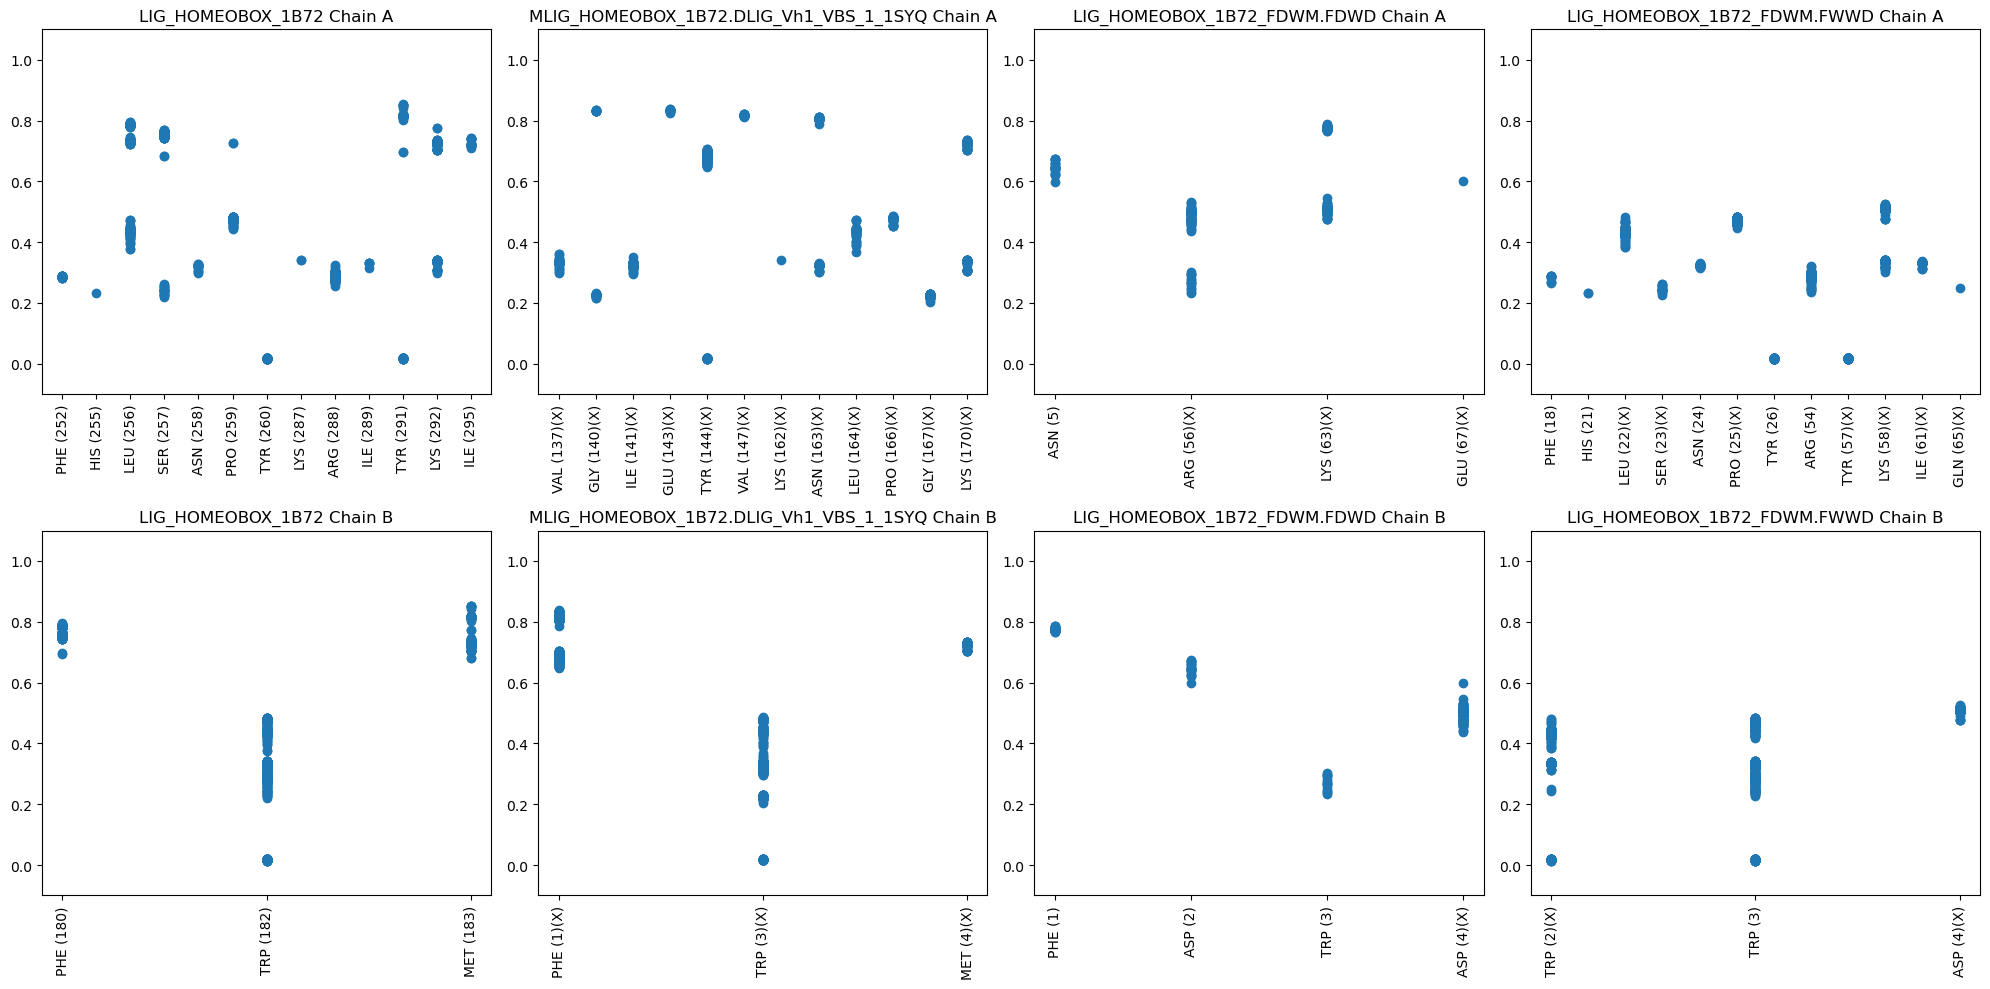

4


structure_name PDB_id      ELM_instance PDB_id_random_paired  \
261  TRG_DiLeu_BaEn_1_4NEE   4NEE  TRG_DiLeu_BaEn_1                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
261                       None     None             None   

                     interface  
261  <Interface of 1162 pairs>

structure_name PDB_id  \
252  MTRG_DiLeu_BaEn_1_4NEE.DLIG_14-3-3_ChREBP_3_5F74   4NEE   

          ELM_instance PDB_id_random_paired ELM_instance_random_paired  \
252  MTRG_DiLeu_BaEn_1                 5F74       DLIG_14-3-3_ChREBP_3   

    sequence sequence_mutated                 interface  
252     None             None  <Interface of 538 pairs>

structure_name PDB_id      ELM_instance  \
521  TRG_DiLeu_BaEn_1_4NEE_ENTSLL.WNTSLD   4NEE  TRG_DiLeu_BaEn_1   
522  TRG_DiLeu_BaEn_1_4NEE_ENTSLL.WNTSLL   4NEE  TRG_DiLeu_BaEn_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
521                 None                       None   ENTSLL           WNTSLD   
522                 None                       None   ENTSLL           WNTSLL   

                     interface  
521  <Interface of 1127 pairs>  
522  <Interface of 1102 pairs>

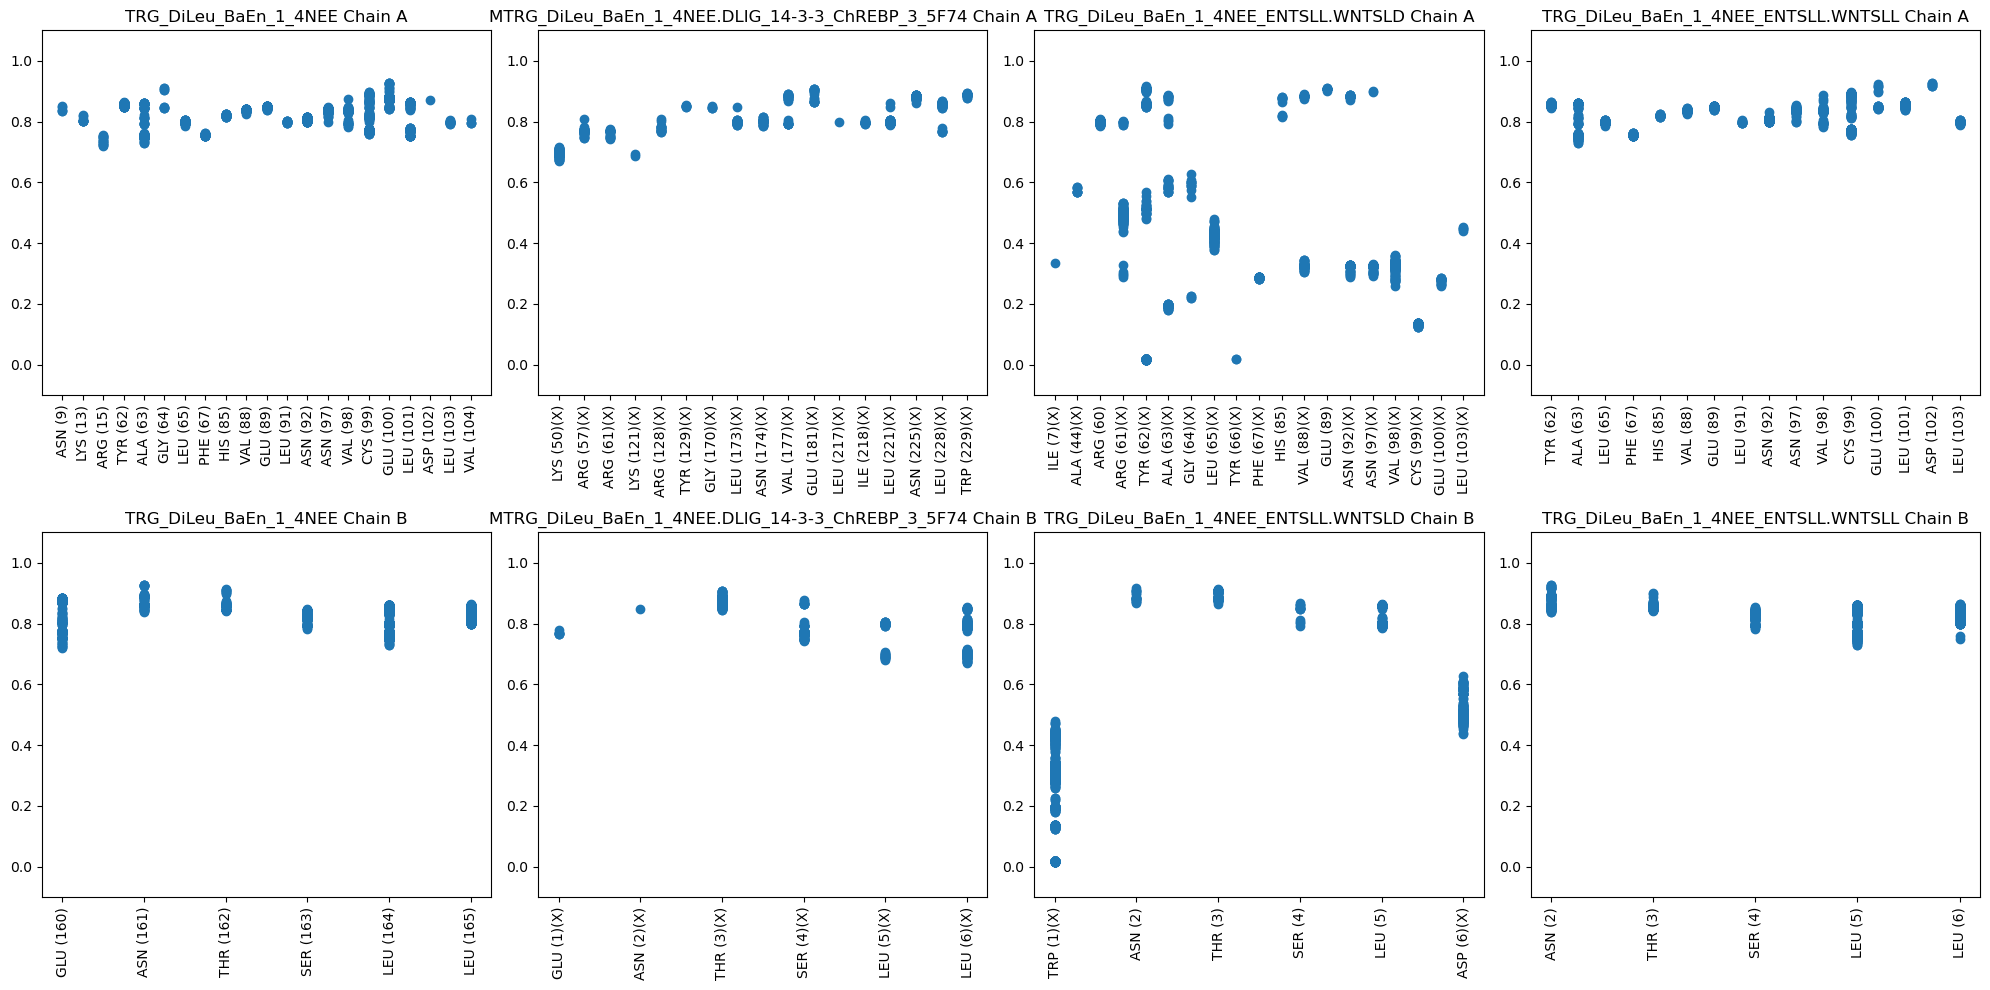

4


structure_name PDB_id     ELM_instance PDB_id_random_paired  \
119  LIG_UFM1_UFIM_1_5HKH   5HKH  LIG_UFM1_UFIM_1                 None   

    ELM_instance_random_paired sequence sequence_mutated  \
119                       None     None             None   

                     interface  
119  <Interface of 1390 pairs>

structure_name PDB_id      ELM_instance  \
241  MLIG_UFM1_UFIM_1_5HKH.DLIG_KLC1_Yacidic_2_6FUZ   5HKH  MLIG_UFM1_UFIM_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
241                 6FUZ        DLIG_KLC1_Yacidic_2     None             None   

                     interface  
241  <Interface of 1932 pairs>

structure_name PDB_id     ELM_instance  \
501  LIG_UFM1_UFIM_1_5HKH_NEWGIELV.NEWGIEDD   5HKH  LIG_UFM1_UFIM_1   
502  LIG_UFM1_UFIM_1_5HKH_NEWGIELV.NEWGIEDV   5HKH  LIG_UFM1_UFIM_1   

    PDB_id_random_paired ELM_instance_random_paired  sequence  \
501                 None                       None  NEWGIELV   
502                 None                       None  NEWGIELV   

    sequence_mutated                  interface  
501         NEWGIEDD  <Interface of 1121 pairs>  
502         NEWGIEDV  <Interface of 1127 pairs>

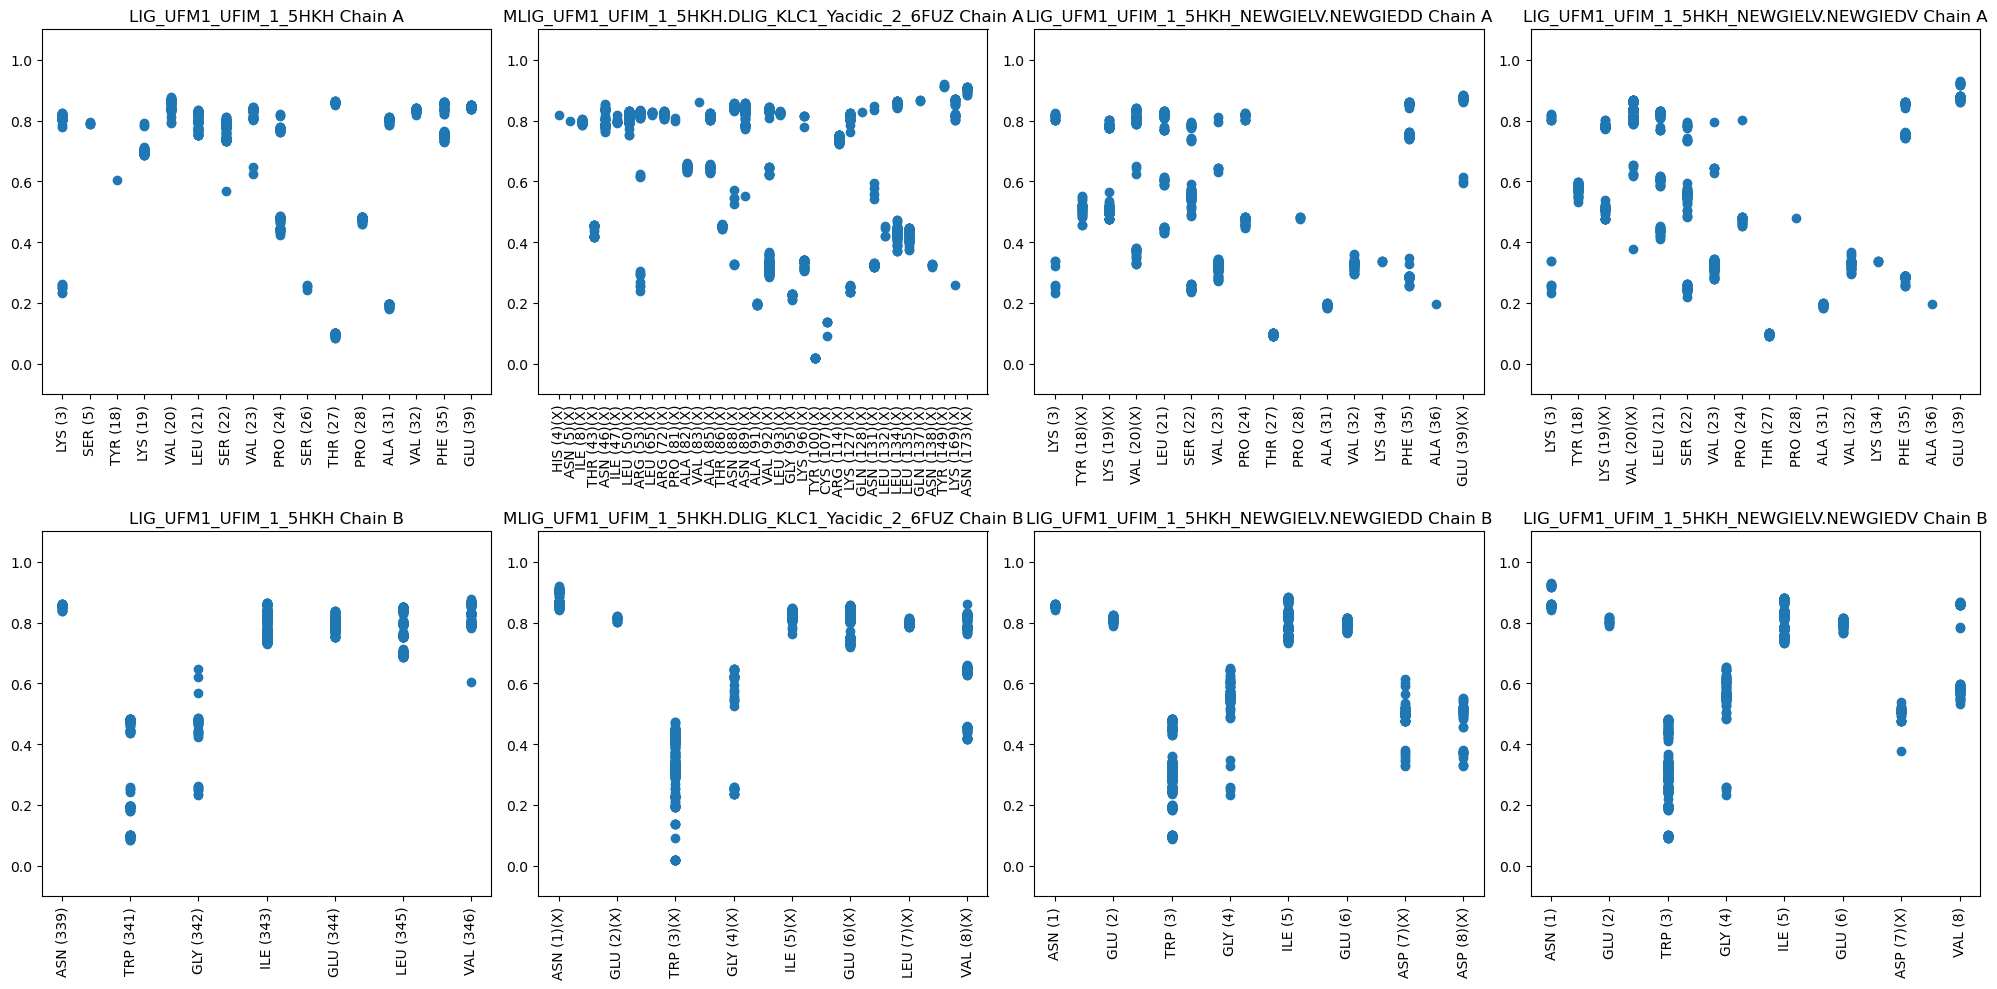

2


structure_name PDB_id      ELM_instance PDB_id_random_paired  \
86  LIG_OCRL_FandH_1_3QIS   3QIS  LIG_OCRL_FandH_1                 None   

   ELM_instance_random_paired sequence sequence_mutated  \
86                       None     None             None   

                    interface  
86  <Interface of 1754 pairs>

structure_name PDB_id       ELM_instance  \
209  MLIG_OCRL_FandH_1_3QIS.DDOC_MAPK_GRA24_9_5ETA   3QIS  MLIG_OCRL_FandH_1   

    PDB_id_random_paired ELM_instance_random_paired sequence sequence_mutated  \
209                 5ETA          DDOC_MAPK_GRA24_9     None             None   

                     interface  
209  <Interface of 1430 pairs>

Empty DataFrame
Columns: [structure_name, PDB_id, ELM_instance, PDB_id_random_paired, ELM_instance_random_paired, sequence, sequence_mutated, interface]
Index: []

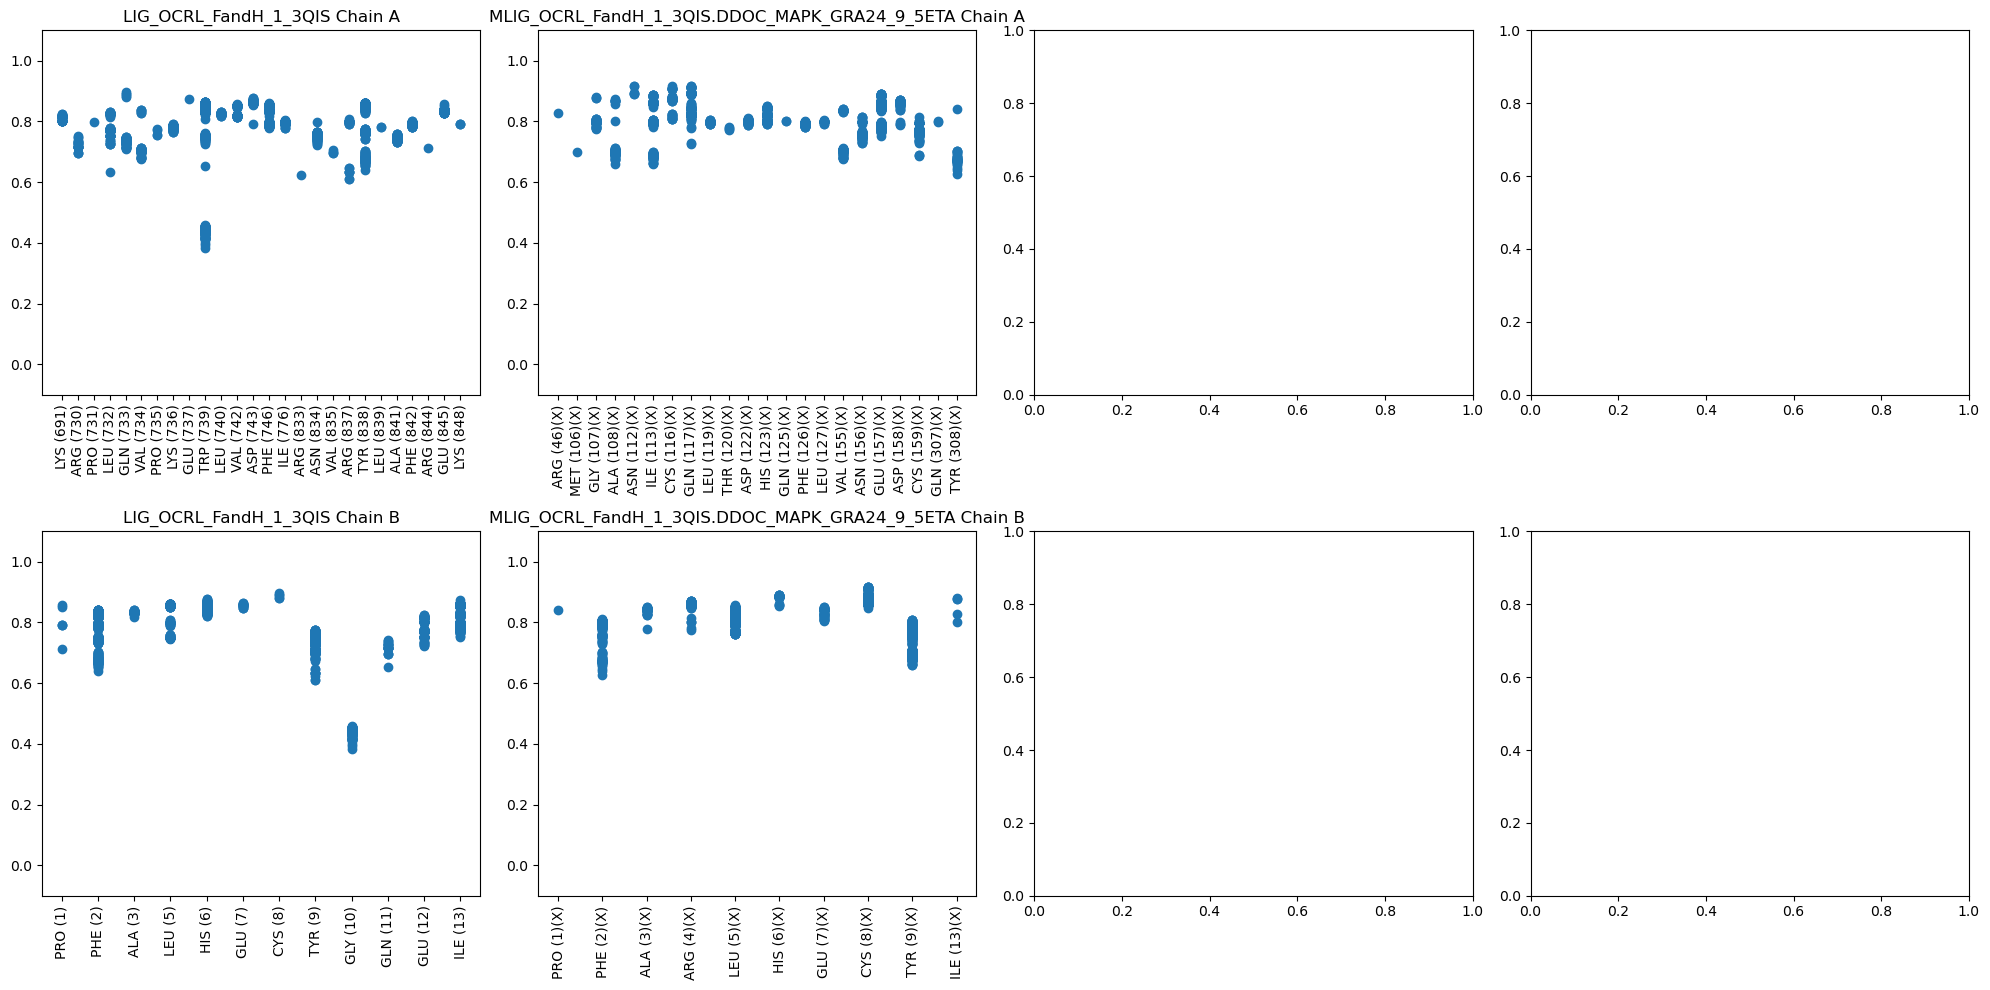

In [214]:
def visualize_interface_ax(ax, intf, chain: str, title: str):
    if chain == "A":
        intfc_res = list(set([p.atom1.parent for p in intf.pairs]))
        intfc_not_valid = list(set([p.atom1.parent for p in intf.pairs if p.valid == False]))
    else:
        intfc_res = list(set([p.atom2.parent for p in intf.pairs]))
        intfc_not_valid = list(set([p.atom2.parent for p in intf.pairs if p.valid == False]))

    vectors = np.array([interface_pair_to_vector(p) for p in intf.pairs if interface_pair_to_vector(p) is not None])
    vectors_x, vectors_y = vectors[:, 0:(vectors.shape[1]-1)], vectors[:, vectors.shape[1]-1]

    y_proba = clf.predict_proba(vectors_x)

    #parent_ids = list(set([p.atom2.parent.id[1] for p in intf.pairs]))
    if chain == "A":
        x = [p.atom1.parent.id[1] for p in intf.pairs]
    else:
        x = [p.atom2.parent.id[1] for p in intf.pairs]
    x_set = sorted(list(set(x)))
    x_conv = []
    for x_ in x:
        x_conv.append(x_set.index(x_))
    x_ticks = {(r.id[1]) : f"{r.resname} ({r.id[1]}){'(X)' if r in intfc_not_valid else ''}" for i, r in enumerate(sorted(intfc_res, key=lambda p:p.id[1]))}


    ax.scatter(x_conv, y_proba[:,1])
    ax.set_title(title)
    ax.set_xticks(range(len(x_ticks.keys())), list(x_ticks.values()), rotation=90)
    ax.set_ylim((-0.1, 1.1))

def visualize_interface(pdb_id: str):
    if len(rows := dataAF[dataAF["PDB_id"] == pdb_id]) == 0:
        print(f"Unkown PDB ID {pdb_id}")
        return
    print(len(rows))
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

    row_solved = rows[np.logical_and(rows["PDB_id_random_paired"].isna(), rows["sequence"].isna())]
    row_random_paired = rows[np.logical_and(~rows["PDB_id_random_paired"].isna(), rows["sequence"].isna())]
    row_mutated = rows[np.logical_and(rows["PDB_id_random_paired"].isna(), ~rows["sequence"].isna())]

    display(row_solved)
    display(row_random_paired)
    display(row_mutated)

    if len(list(row_solved['structure_name'])) >= 1:
        visualize_interface_ax(axes[0,0], list(row_solved["interface"])[0], "A", f"{list(row_solved['structure_name'])[0]} Chain A")
        visualize_interface_ax(axes[1,0], list(row_solved["interface"])[0], "B", f"{list(row_solved['structure_name'])[0]} Chain B")
    if len(list(row_random_paired['structure_name'])) >= 1:
        visualize_interface_ax(axes[0,1], list(row_random_paired["interface"])[0], "A", f"{list(row_random_paired['structure_name'])[0]} Chain A")
        visualize_interface_ax(axes[1,1], list(row_random_paired["interface"])[0], "B", f"{list(row_random_paired['structure_name'])[0]} Chain B")

    if len(list(row_mutated['structure_name'])) >= 1:
        visualize_interface_ax(axes[0,2], list(row_mutated["interface"])[0], "A", f"{list(row_mutated['structure_name'])[0]} Chain A")
        visualize_interface_ax(axes[1,2], list(row_mutated["interface"])[0], "B", f"{list(row_mutated['structure_name'])[0]} Chain B")
    if len(list(row_mutated['structure_name'])) >= 2:
        visualize_interface_ax(axes[0,3], list(row_mutated["interface"])[1], "A", f"{list(row_mutated['structure_name'])[1]} Chain A")
        visualize_interface_ax(axes[1,3], list(row_mutated["interface"])[1], "B", f"{list(row_mutated['structure_name'])[1]} Chain B")

    fig.tight_layout()
    plt.show()
    return

for pdb_id in pdb_ids_test:
    visualize_interface(pdb_id)

In [ ]:
for pdb_id in pdb_ids_test:
    visualize_interface

DEG_APCC_KENBOX_2_4GGD_SKENV.SGENV


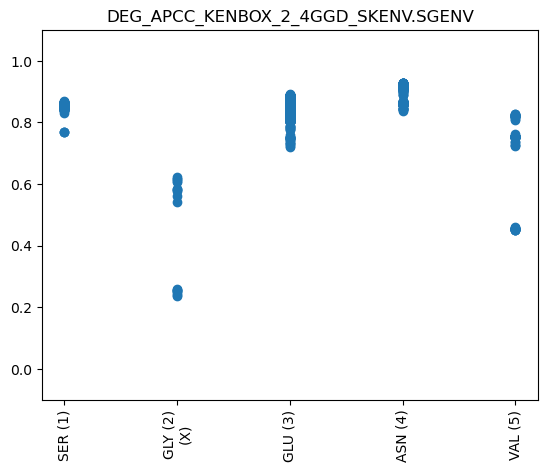

In [189]:
def visualize_interface(structure_name: str):
    if not structure_name in DMI_AF_biopy.keys() or len(dataAF[dataAF["structure_name"] == structure_name]) != 1:
        print(f"Unkown name {structure_name}")
        return
    intf: Interface = list(dataAF[dataAF["structure_name"] == structure_name]["interface"])[0]
    intf2_res = list(set([p.atom2.parent for p in intf.pairs]))
    intf2_not_valid = list(set([p.atom2.parent for p in intf.pairs if p.valid == False]))

    vectors = np.array([interface_pair_to_vector(p) for p in intf.pairs if interface_pair_to_vector(p) is not None])
    vectors_x, vectors_y = vectors[:, 0:(vectors.shape[1]-1)], vectors[:, vectors.shape[1]-1]

    y_proba = clf.predict_proba(vectors_x)

    #parent_ids = list(set([p.atom2.parent.id[1] for p in intf.pairs]))
    x = [p.atom2.parent.id[1] for p in intf.pairs]
    x_ticks = {(r.id[1]) : f"{r.resname} ({r.id[1]}){'\n(X)' if r in intf2_not_valid else ''}" for i, r in enumerate(sorted(intf2_res, key=lambda p:p.id[1]))}

    print(structure_name)
    plt.scatter(x, y_proba[:,1])
    plt.title(f"{structure_name}")
    plt.xticks(list(x_ticks.keys()), list(x_ticks.values()), rotation=90)
    plt.ylim((-0.1, 1.1))
    plt.show()

visualize_interface("DEG_APCC_KENBOX_2_4GGD_SKENV.SGENV")

DEG_Kelch_Keap1_1_2FLU


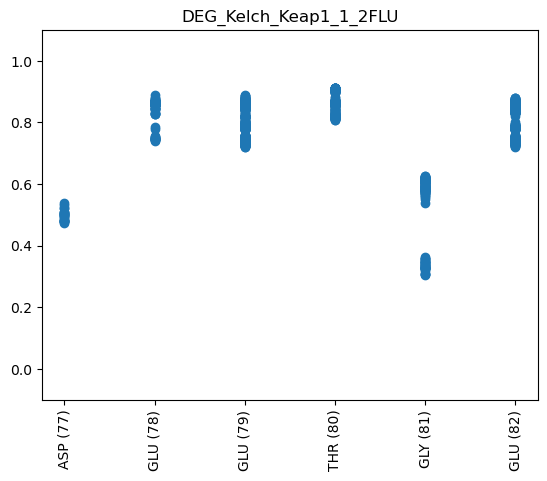

DEG_Kelch_Keap1_2_3WN7


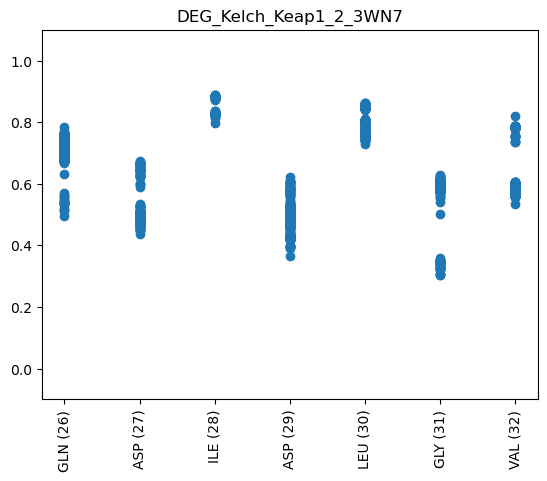

DEG_SCF_TIR1_1_2P1Q


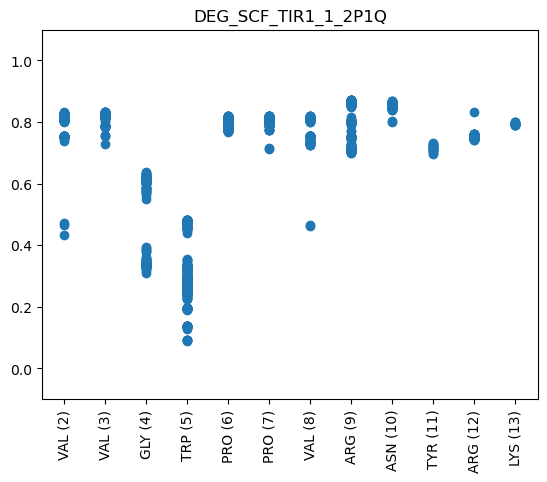

DEG_SIAH_1_2A25


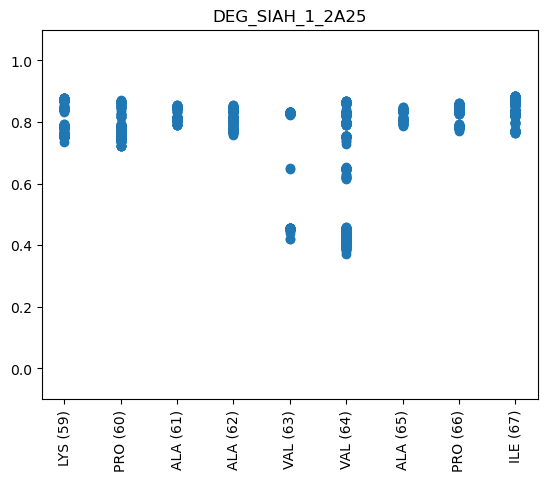

DOC_MAPK_NFAT4_5_2XS0


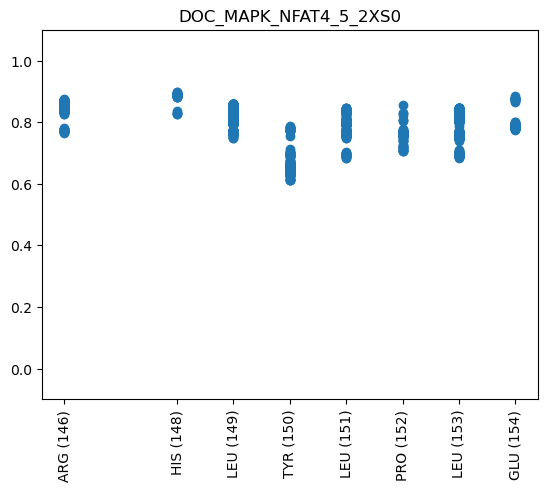

DOC_MIT_MIM_1_2JQ9


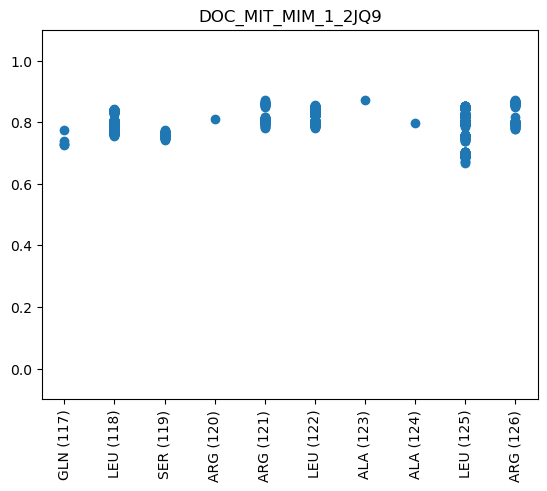

DOC_SPAK_OSR1_1_2V3S


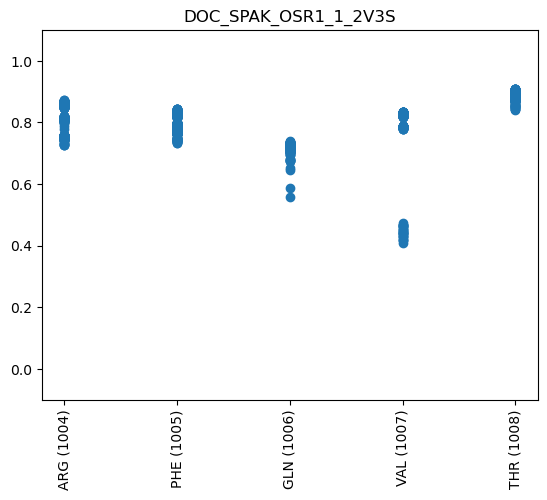

LIG_14-3-3_ChREBP_3_5F74


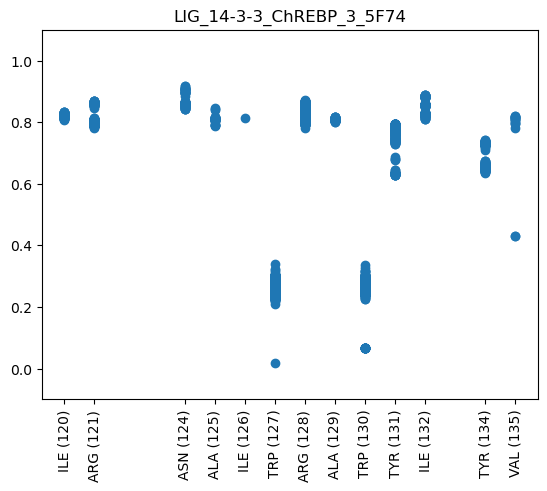

LIG_Actin_RPEL_3_2V51


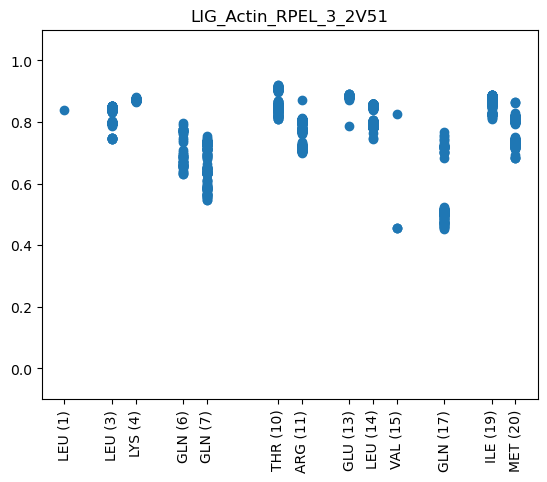

LIG_AP2alpha_2_1KYU


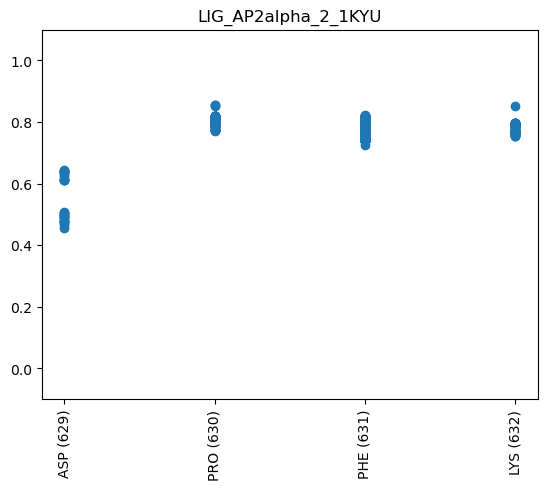

LIG_ARL_BART_1_4ZI2


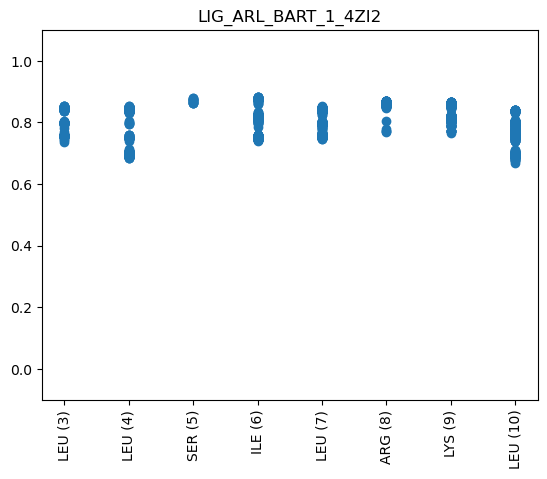

LIG_BIR_III_3_1JD5


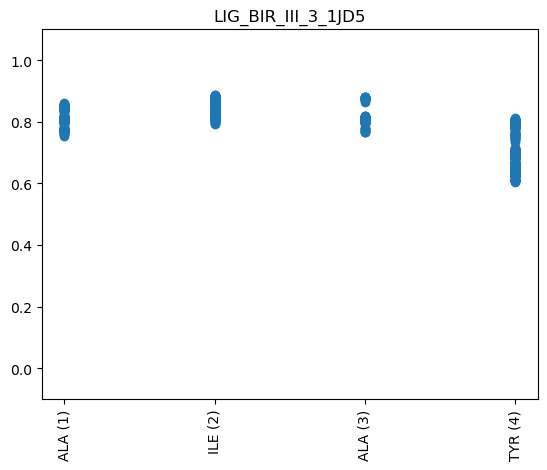

LIG_HOMEOBOX_1B72


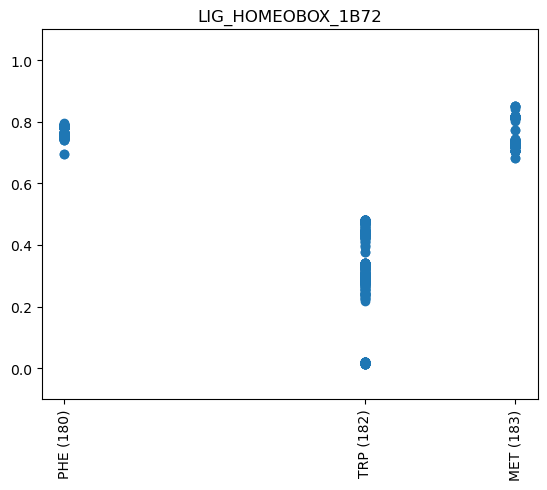

LIG_KLC1_Yacidic_2_6FUZ


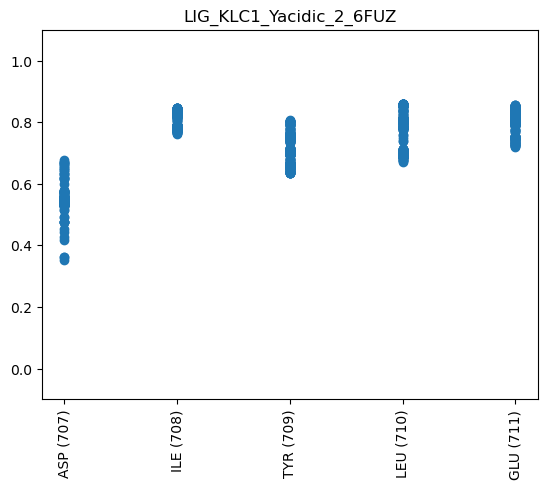

LIG_LSD1_SNAG_1_2Y48


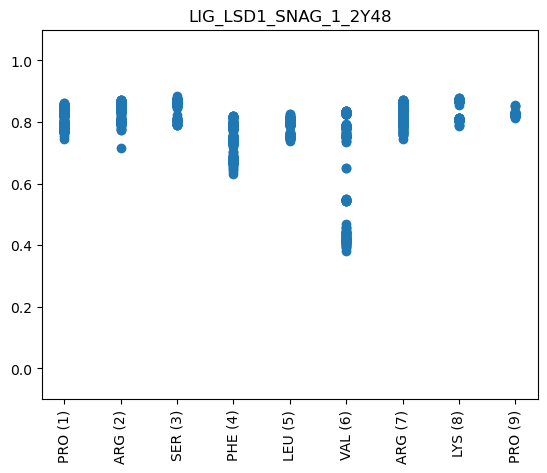

LIG_LYPXL_L_2_2R02


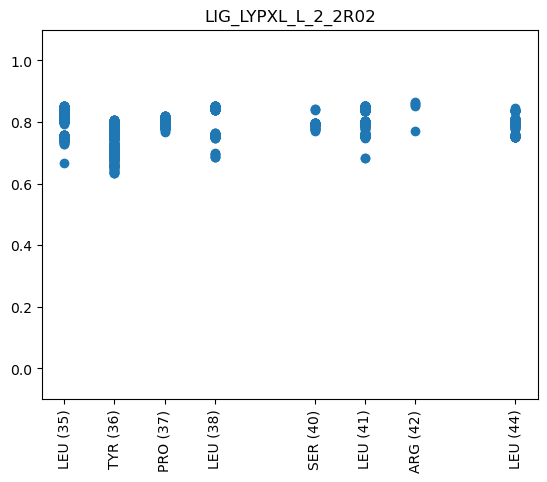

LIG_OCRL_FandH_1_3QIS


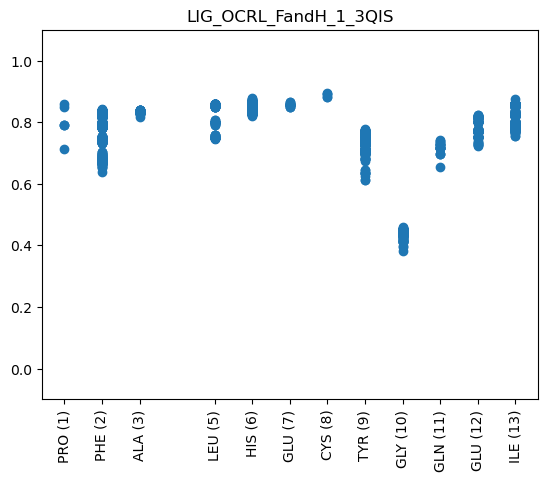

LIG_PAM2_1_1JGN


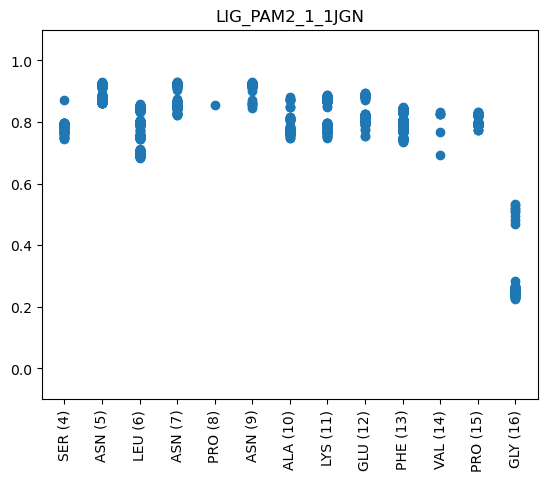

LIG_Pex14_1_2W84


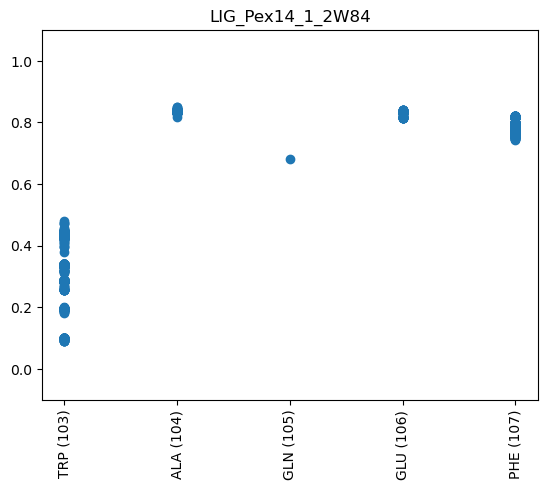

LIG_SUFU_1_4KMD


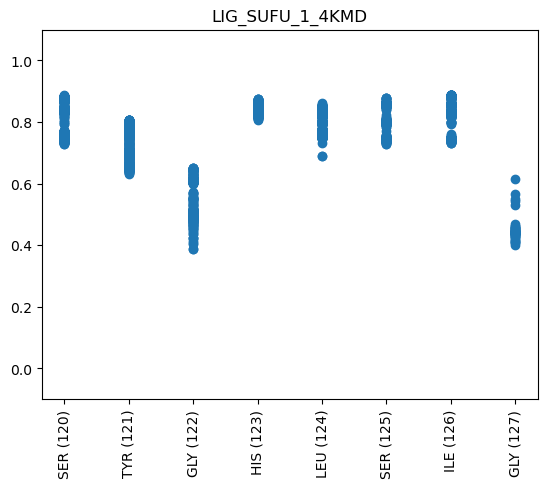

LIG_SUMO_SIM_anti_2_2KQS


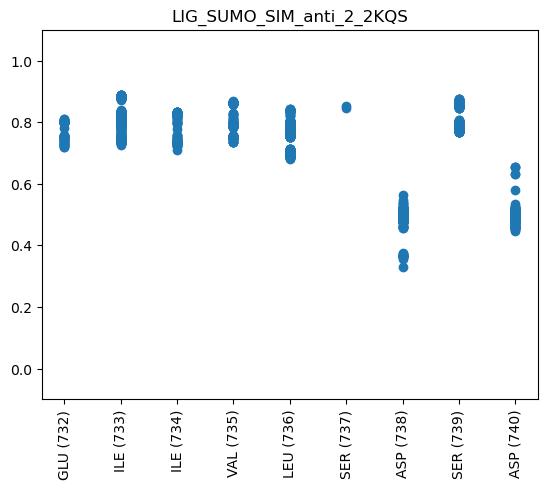

LIG_TRAF2_1_1CA9


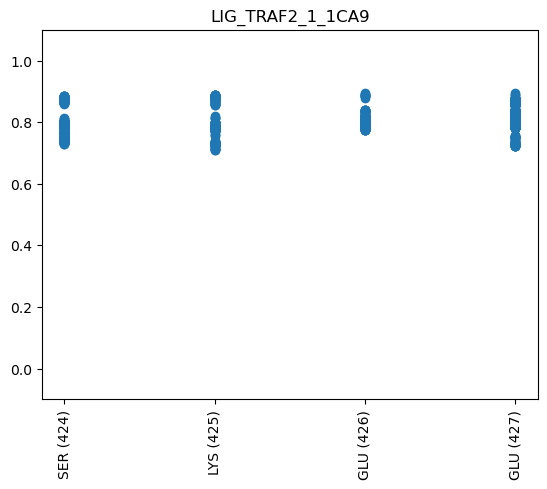

LIG_TRAF2_2_1CZY


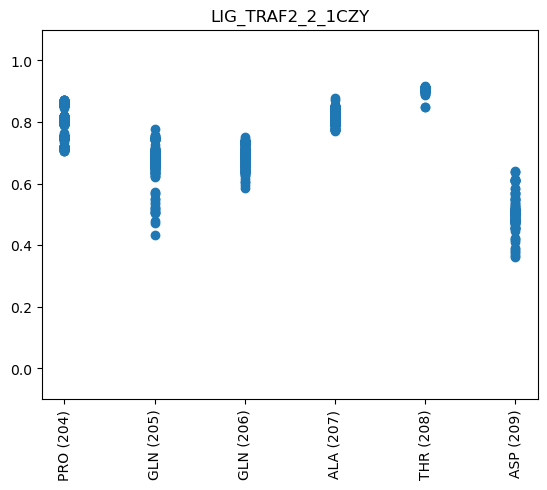

LIG_UFM1_UFIM_1_5HKH


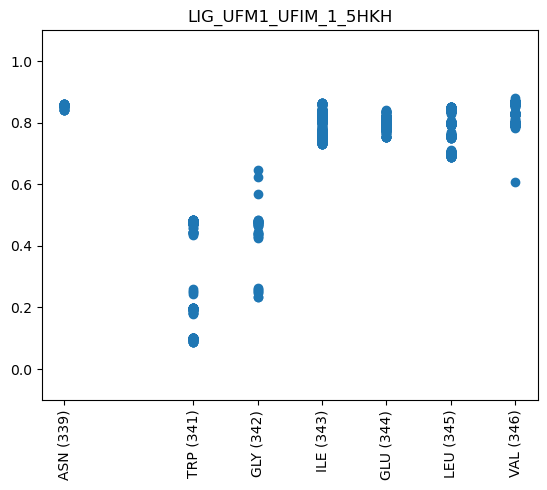

LIG_WD40_WDR5_WIN_1_3UVK


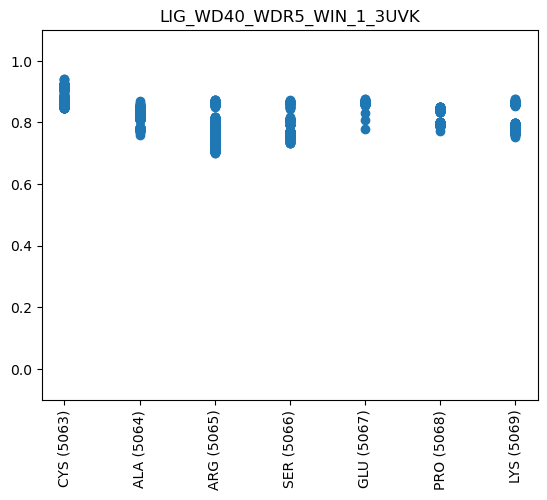

MDOC_MIT_MIM_1_2JQ9.DLIG_HOMEOBOX_1B72


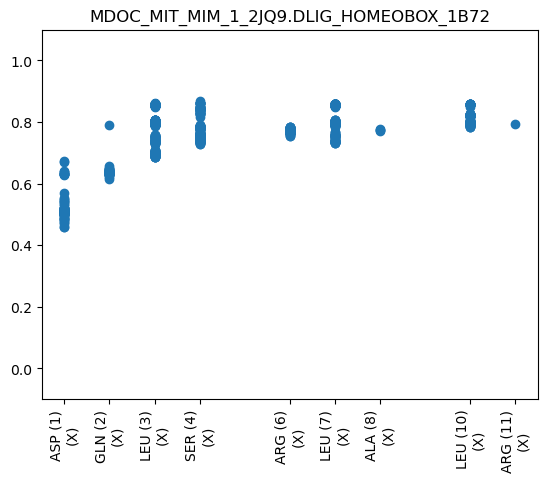

MLIG_AP2alpha_2_1KYU.DLIG_TRAF2_2_1CZY


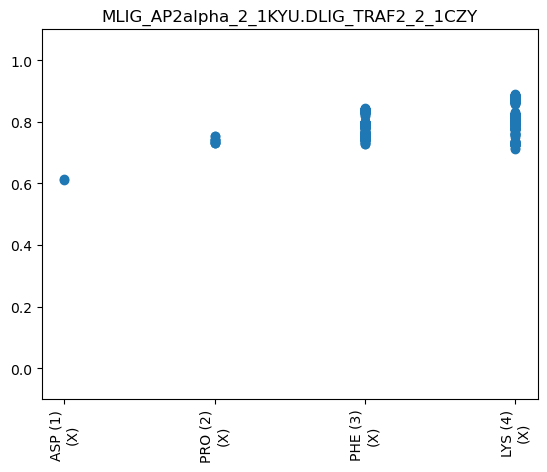

MLIG_SUFU_1_4KMD.DLIG_ActinCP_CPI_1_3AA1


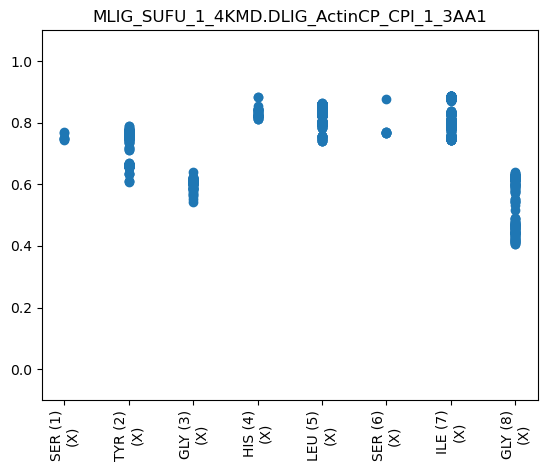

MLIG_TRAF2_1_1CA9.DLIG_BIR_III_3_1JD5


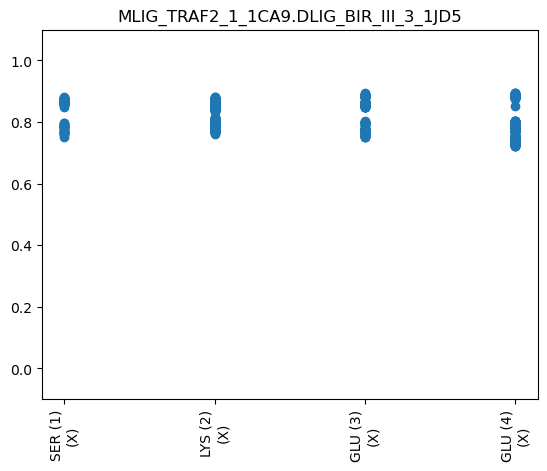

MLIG_TRAF2_2_1CZY.DLIG_WD40_WDR5_WIN_1_3UVK


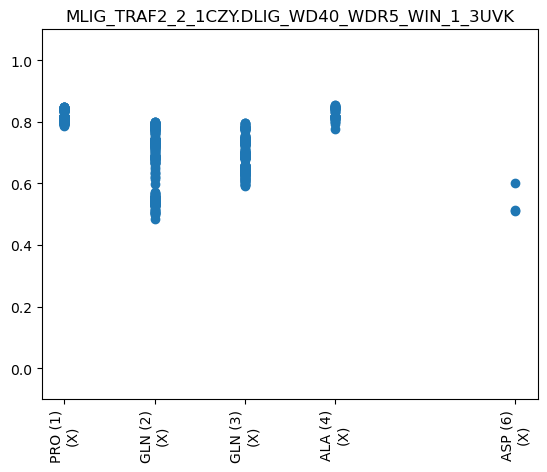

MLIG_UFM1_UFIM_1_5HKH.DLIG_KLC1_Yacidic_2_6FUZ


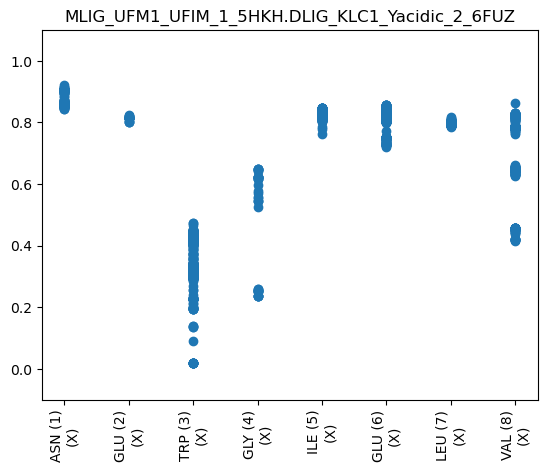

MTRG_DiLeu_BaEn_1_4NEE.DLIG_14-3-3_ChREBP_3_5F74


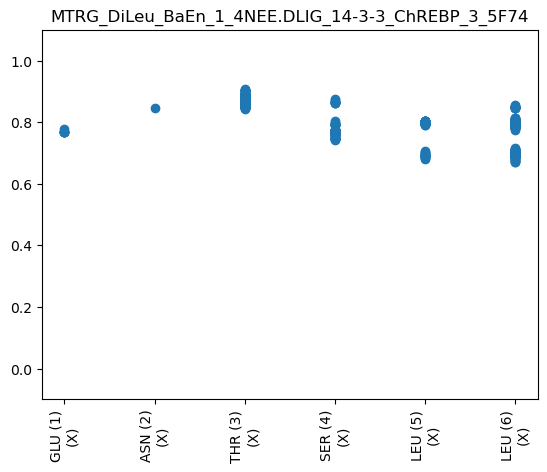

TRG_DiLeu_BaEn_1_4NEE


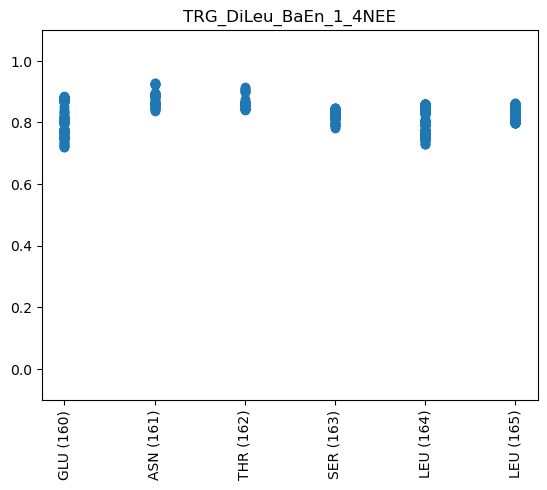

TRG_PTS1_2C0L


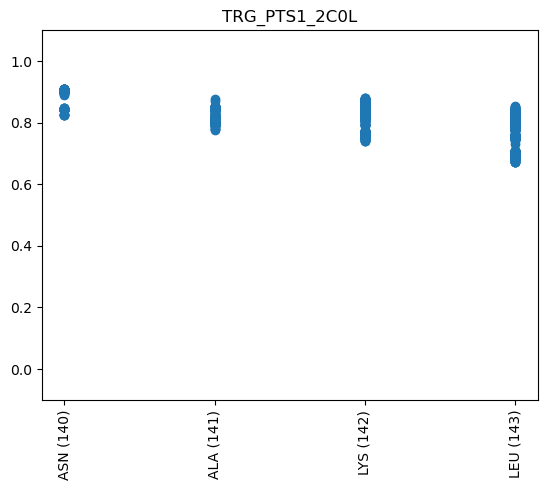

DEG_Kelch_Keap1_1_2FLU_DEETGE.DEETWE


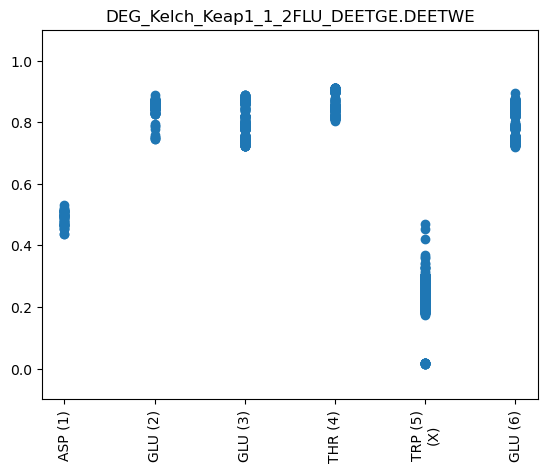

DEG_Kelch_Keap1_1_2FLU_DEETGE.DEEWWE


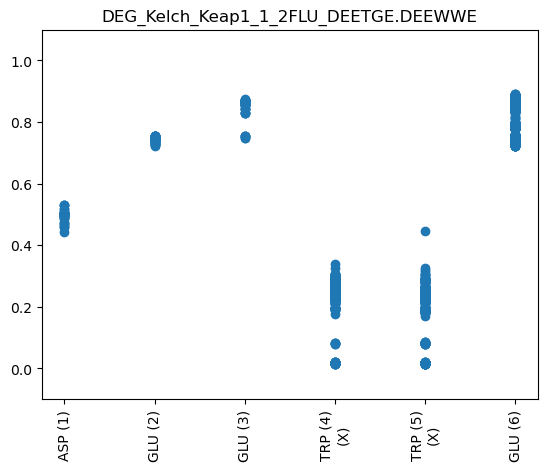

DEG_Kelch_Keap1_2_3WN7_QDIDLGV.WDIDDGV


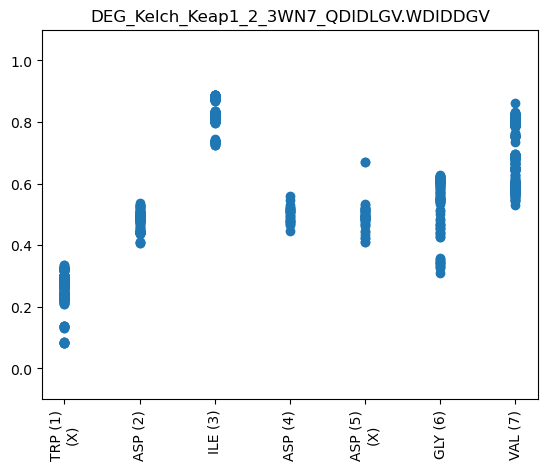

DEG_Kelch_Keap1_2_3WN7_QDIDLGV.WDIDLGV


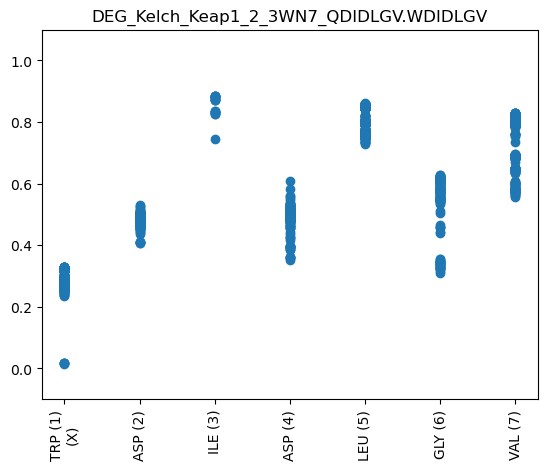

DEG_SCF_TIR1_1_2P1Q_QVVGWPPVRNYRK.QVDGWPPDRNYRK


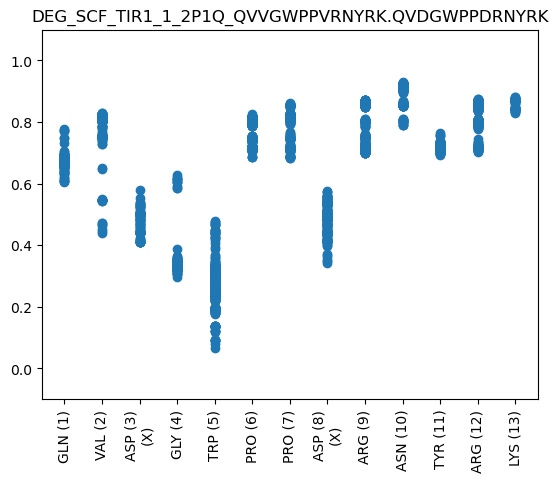

DEG_SCF_TIR1_1_2P1Q_QVVGWPPVRNYRK.QVDGWPPVRNYRK


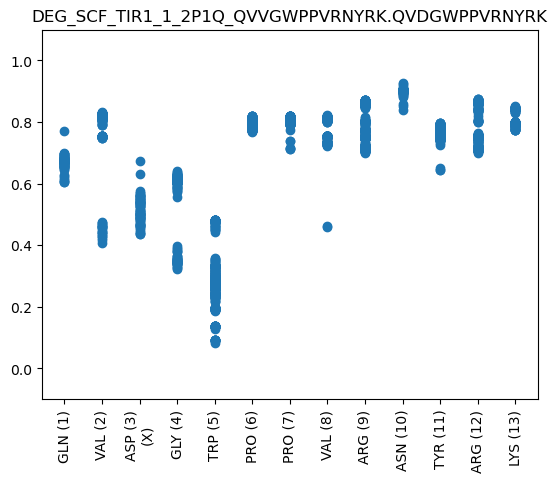

DEG_SIAH_1_2A25_KPAAVVAPI.KPAWVVAPI


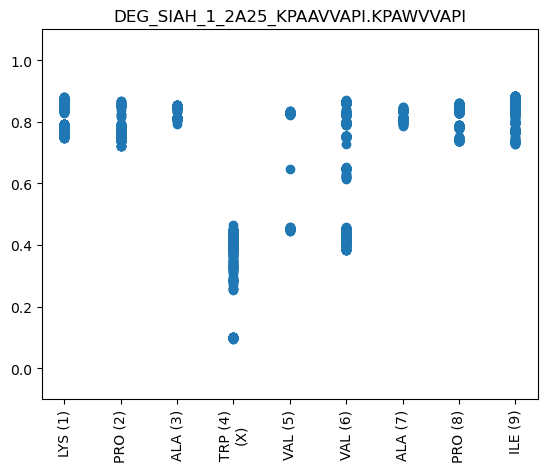

DEG_SIAH_1_2A25_KPAAVVAPI.KPAWVVAWI


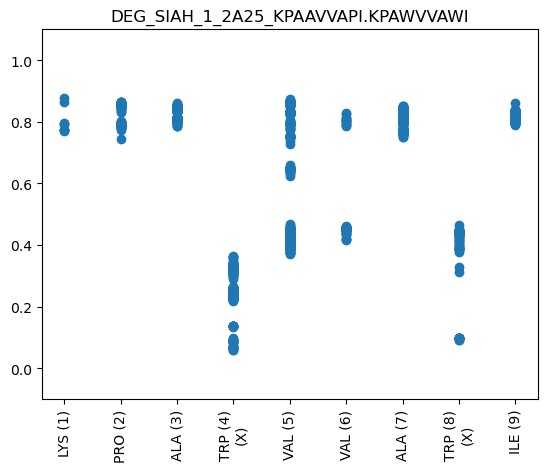

DOC_MAPK_NFAT4_5_2XS0_RDHLYLPLE.GDHLYDPLE


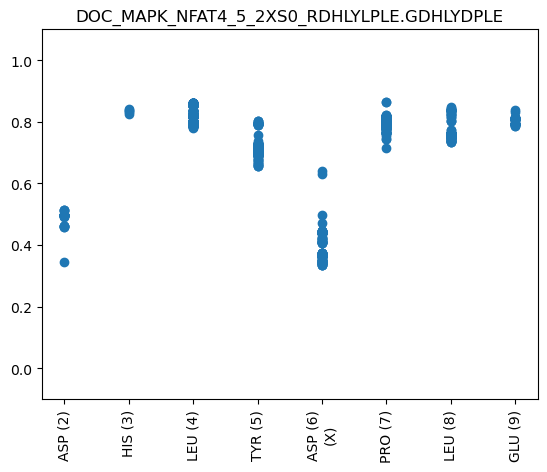

DOC_MAPK_NFAT4_5_2XS0_RDHLYLPLE.RDHLYDPLE


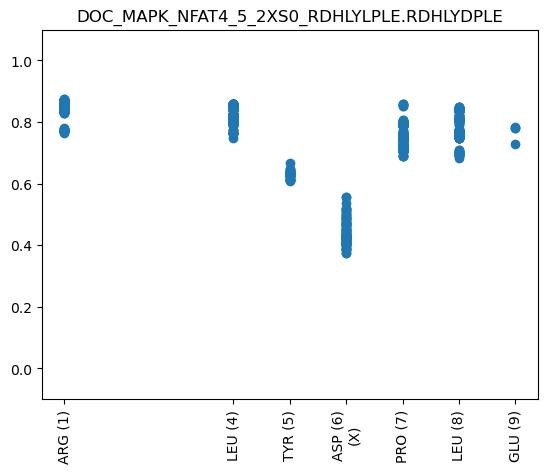

DOC_MIT_MIM_1_2JQ9_DQLSRRLAALR.DQLSRRDAALG


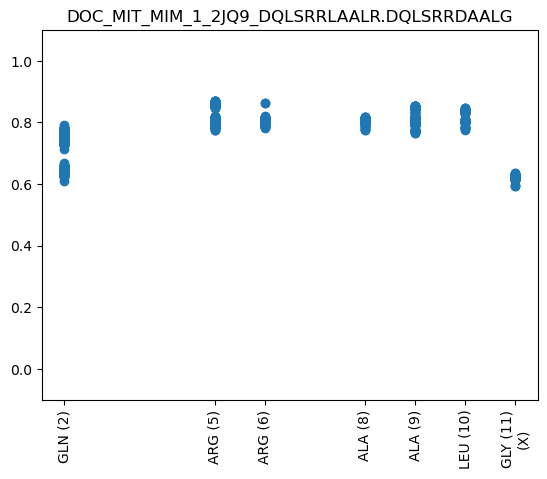

DOC_MIT_MIM_1_2JQ9_DQLSRRLAALR.DQLSRRLAALG


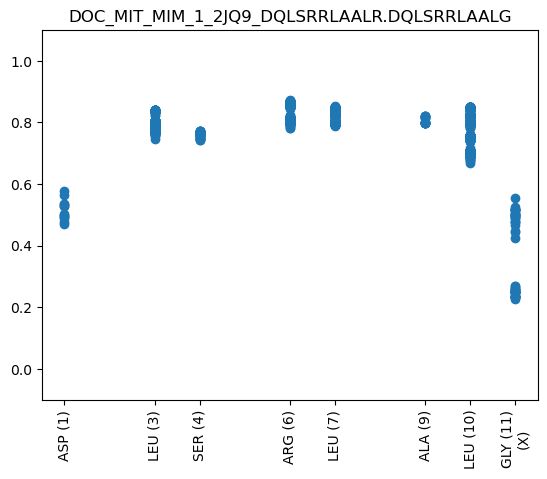

DOC_SPAK_OSR1_1_2V3S_RFQVT.GDQVT


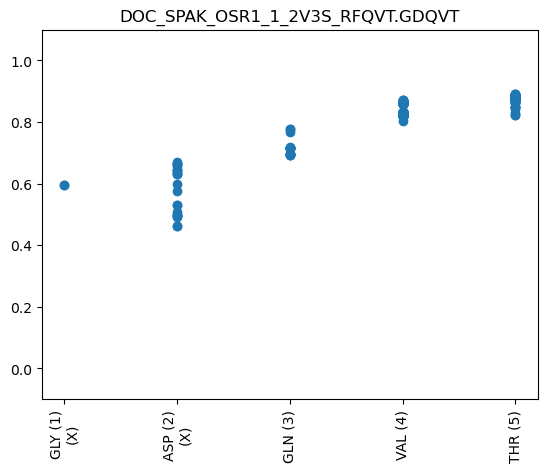

DOC_SPAK_OSR1_1_2V3S_RFQVT.GFQVT


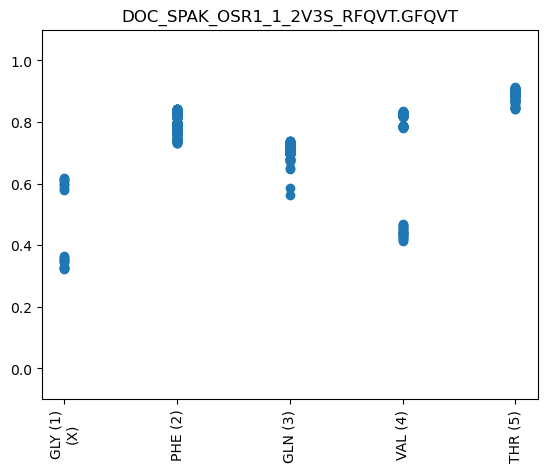

LIG_14-3-3_ChREBP_3_5F74_IRLNNAIWRAWYIQYV.IRLNNAIWRAWYDQYD


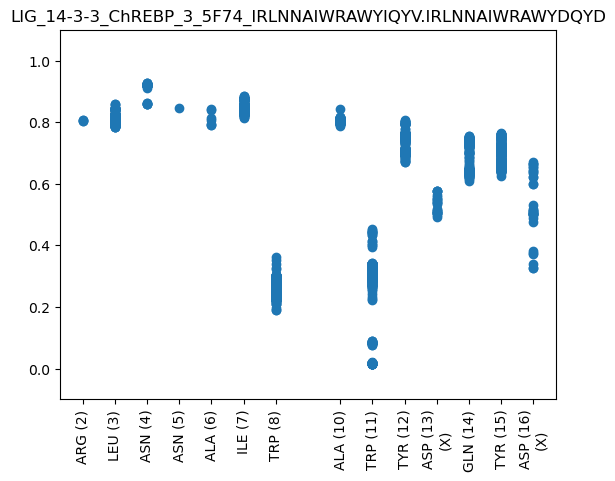

LIG_14-3-3_ChREBP_3_5F74_IRLNNAIWRAWYIQYV.IRLNNAIWRAWYIQYD


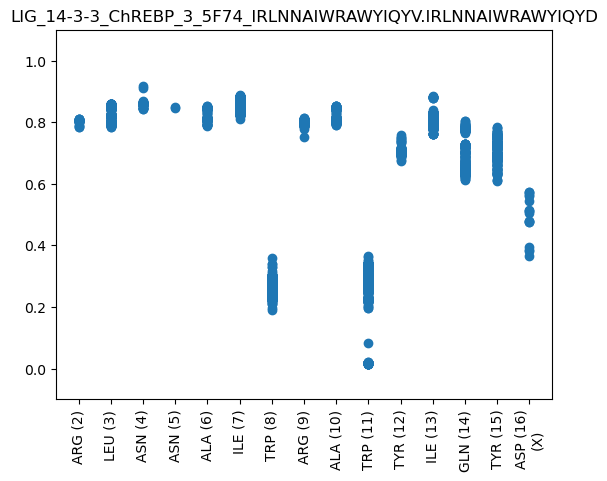

LIG_ActinCP_CPI_1_3AA1_LAHPTRDRAKIQHSRRPPT.DAHPTRDRAKIQHSRRPPT


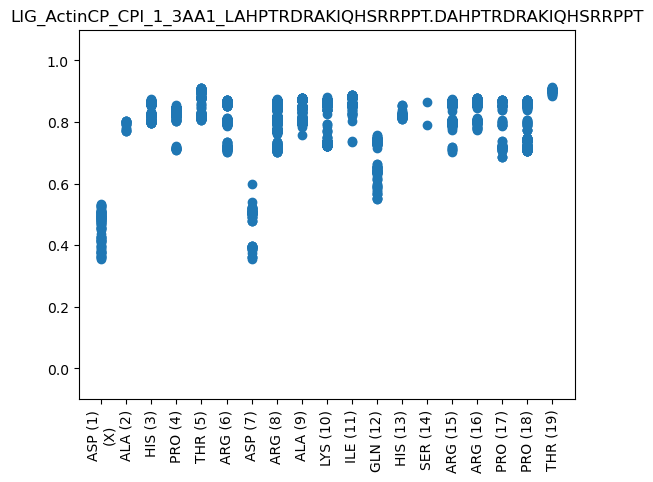

LIG_ActinCP_CPI_1_3AA1_LAHPTRDRAKIQHSRRPPT.DAHPTRDRAKIQHSRRPWT


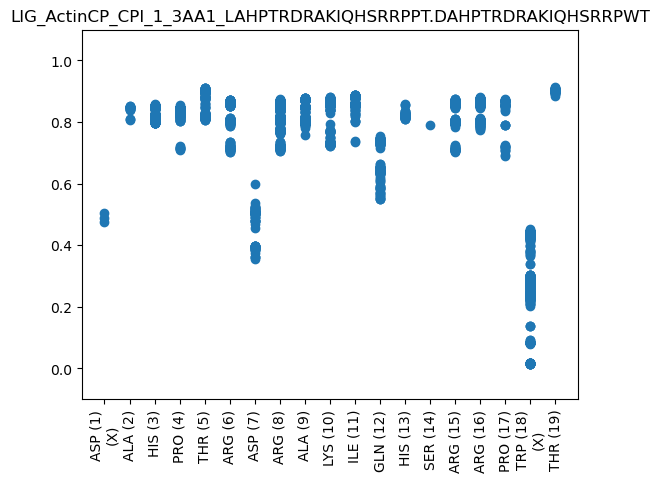

LIG_Actin_RPEL_3_2V52_LKRKIRSRPERAELVRMHIL.LKRKIRSGPERAELVRMHDL


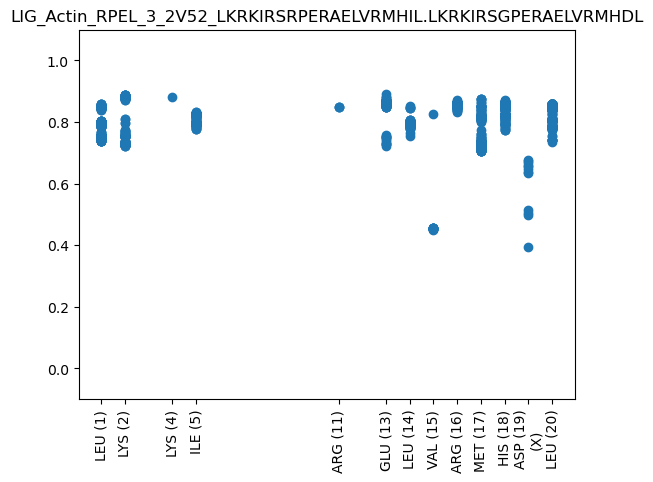

LIG_Actin_RPEL_3_2V52_LKRKIRSRPERAELVRMHIL.LKRKIRSGPERAELVRMHIL


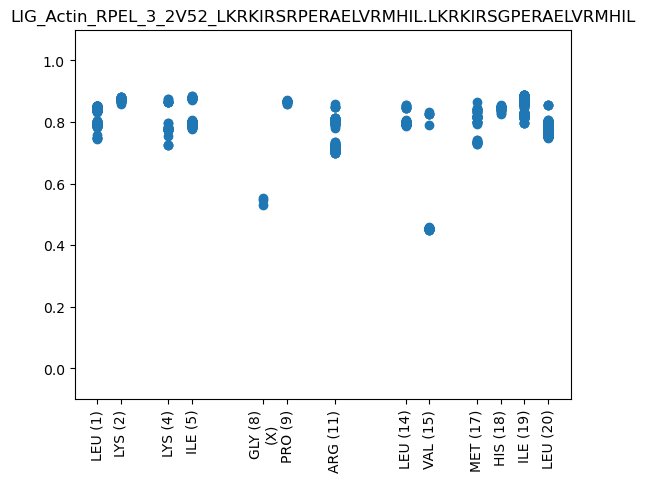

LIG_AP2alpha_2_1KYU_DPFK.DWFK


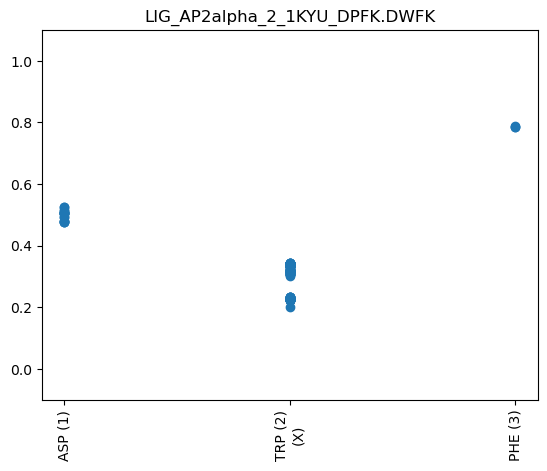

LIG_AP2alpha_2_1KYU_DPFK.WWFK


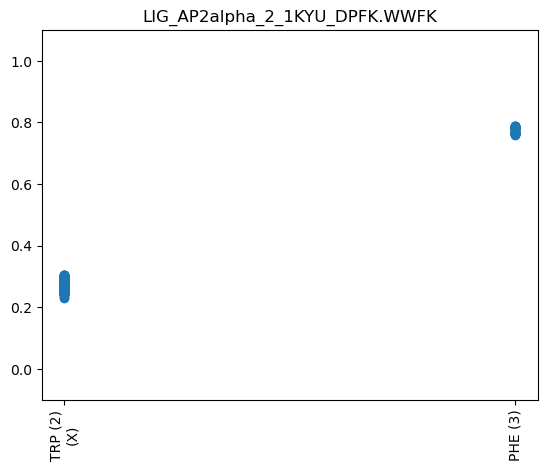

LIG_ARL_BART_1_4ZI2_LLSILRKL.DLSIDRKL


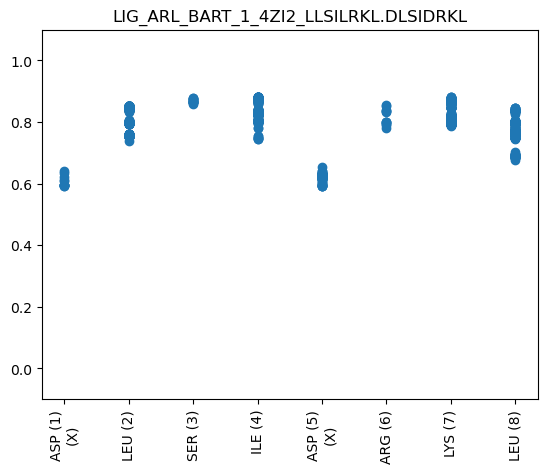

LIG_ARL_BART_1_4ZI2_LLSILRKL.LLSIDRKL


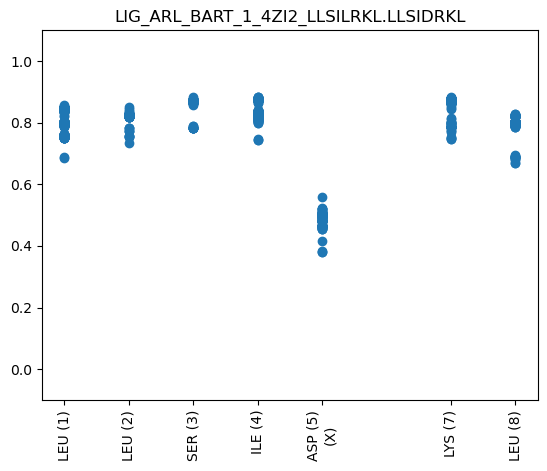

LIG_BIR_III_3_1JD5_AIAY.AIWY


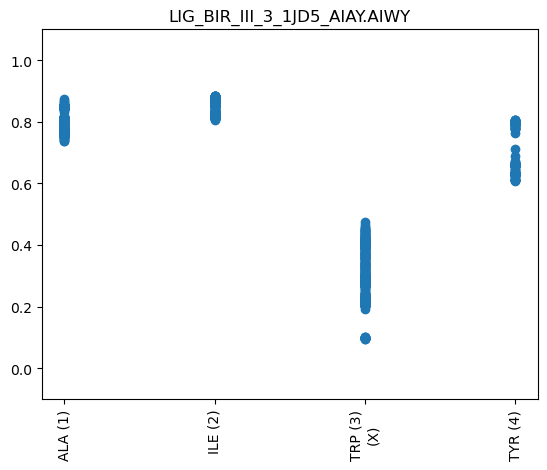

LIG_BIR_III_3_1JD5_AIAY.WIWY


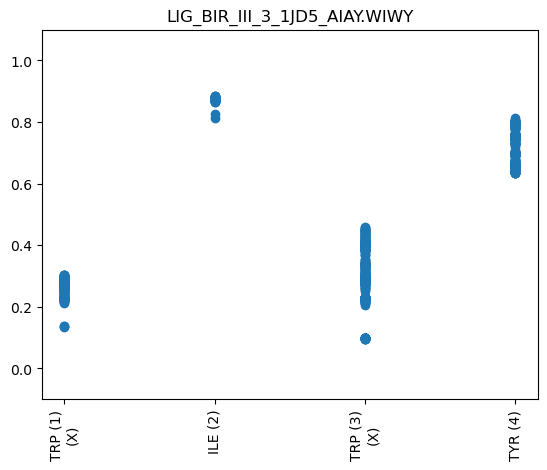

LIG_HOMEOBOX_1B72_FDWM.FDWD


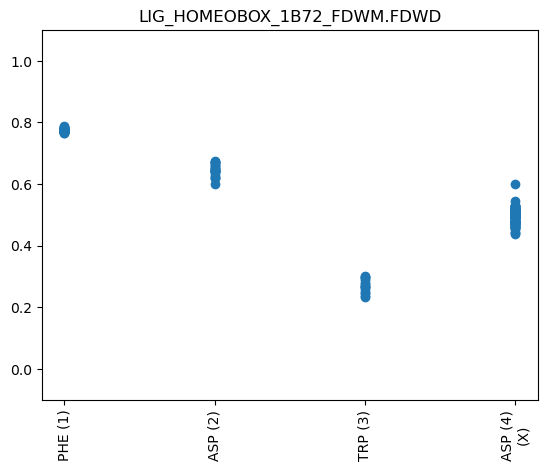

LIG_HOMEOBOX_1B72_FDWM.FWWD


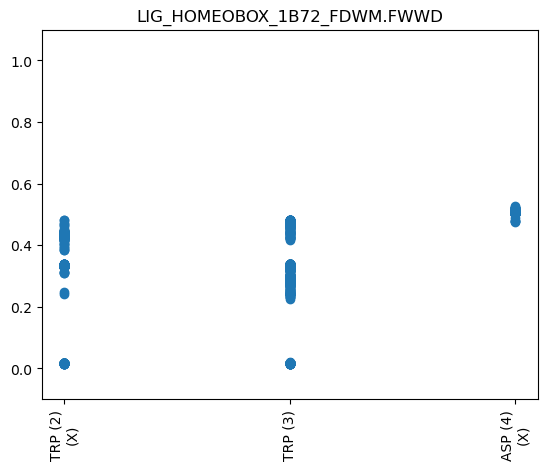

LIG_KLC1_Yacidic_2_6FUZ_DIYLE.DDGLE


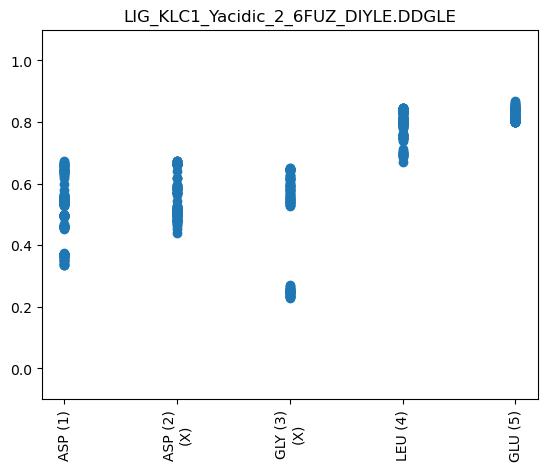

LIG_KLC1_Yacidic_2_6FUZ_DIYLE.DIGLE


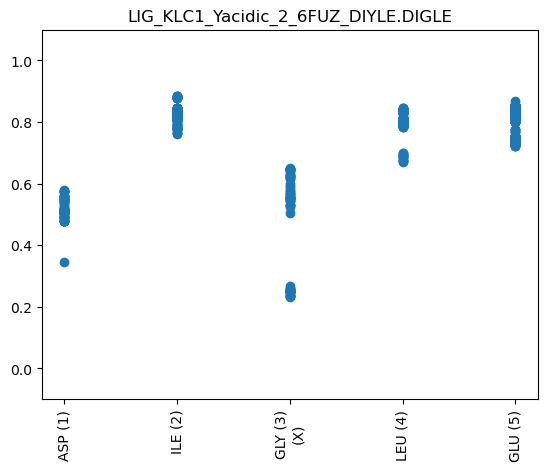

LIG_LSD1_SNAG_1_2Y48_PRSFLVRKP.PRSDDVRKP


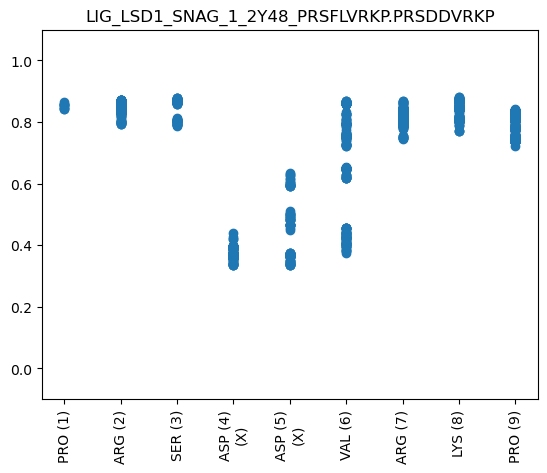

LIG_LSD1_SNAG_1_2Y48_PRSFLVRKP.PRSDLVRKP


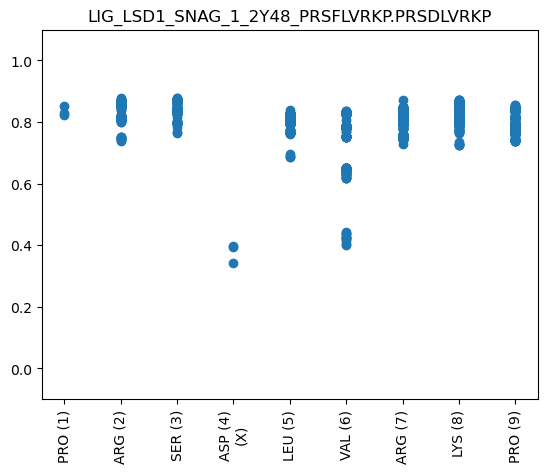

LIG_LYPXL_L_2_2R02_LYPLTSLRSL.DYPLTSLRSL


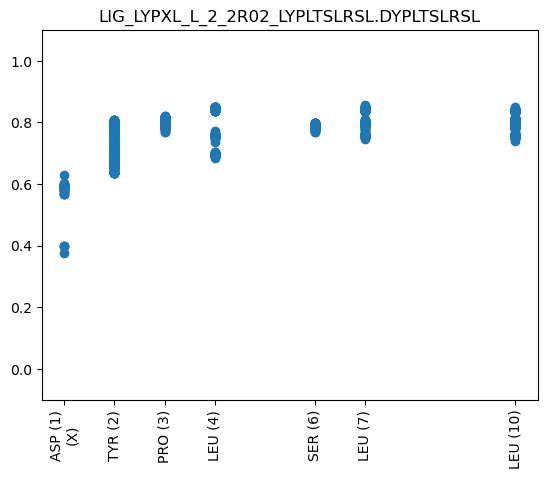

LIG_LYPXL_L_2_2R02_LYPLTSLRSL.DYWLTSLRSL


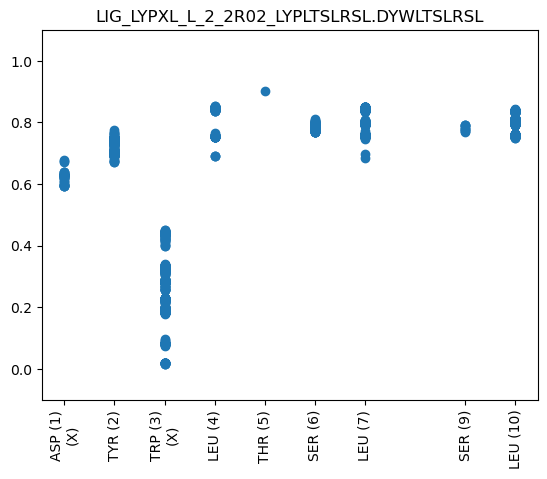

LIG_PAM2_1_1JGN_SNLNPNAKEFVPG.SNLNWNAKEFVPG


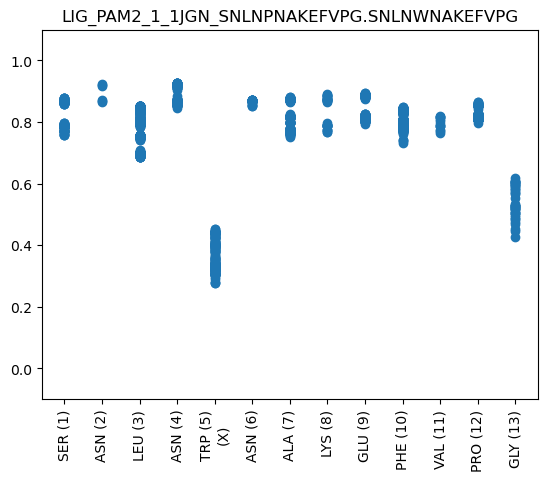

LIG_PAM2_1_1JGN_SNLNPNAKEFVPG.SNLNWNWKEFVPG


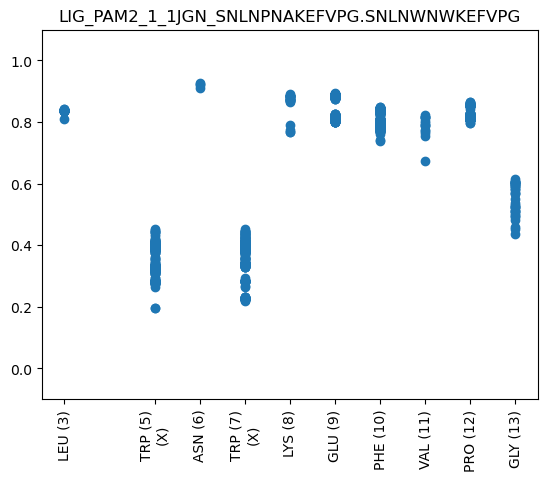

LIG_Pex14_1_2W84_WAQEF.GAQED


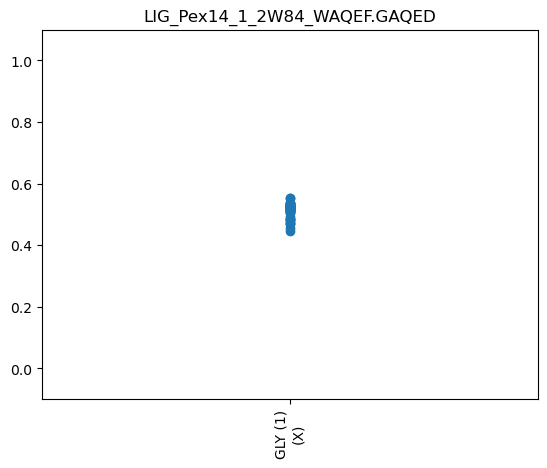

LIG_Pex14_1_2W84_WAQEF.GAQEF


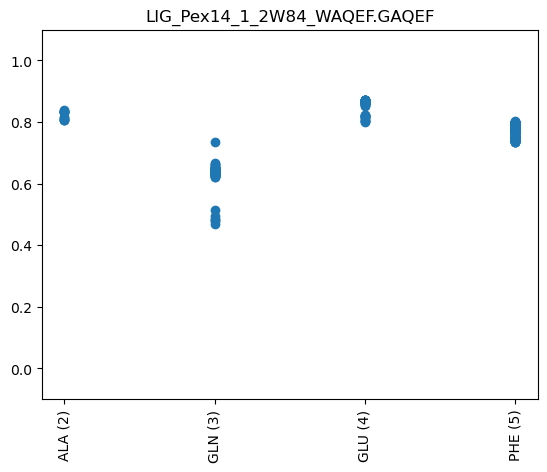

LIG_SUFU_1_4KMD_SYGHLSIG.SYGWLSDG


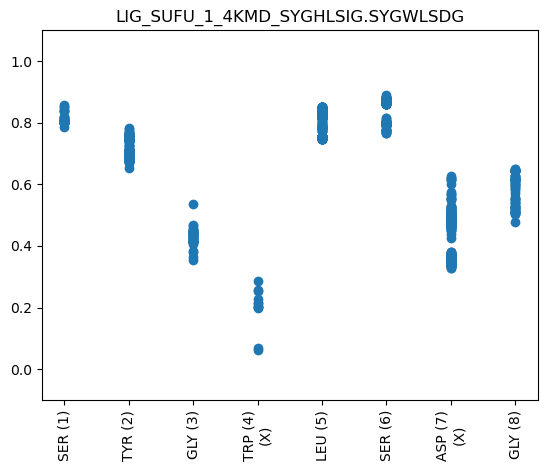

LIG_SUFU_1_4KMD_SYGHLSIG.SYGWLSIG


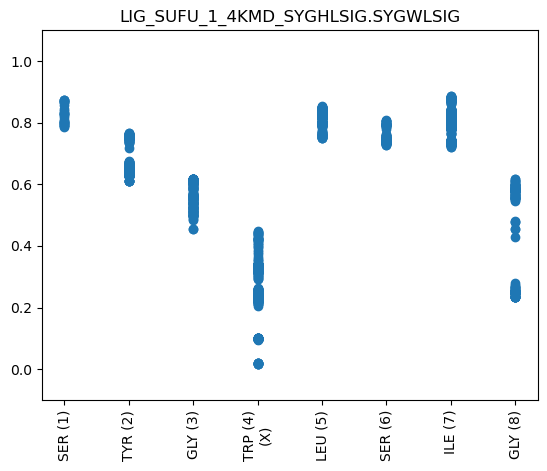

LIG_SUMO_SIM_anti_2_2KQS_EIIVLSDSD.EIDVLSDWD


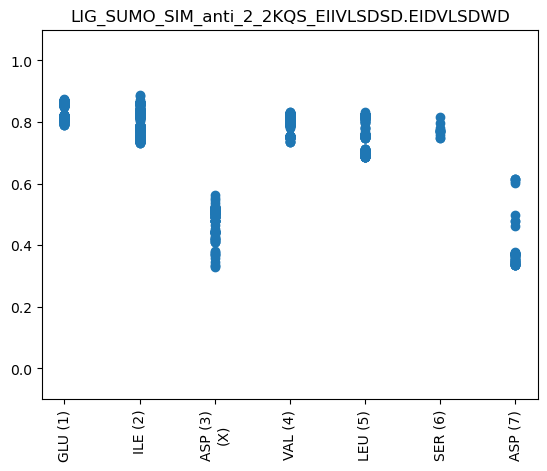

LIG_SUMO_SIM_anti_2_2KQS_EIIVLSDSD.EIIVLSDWD


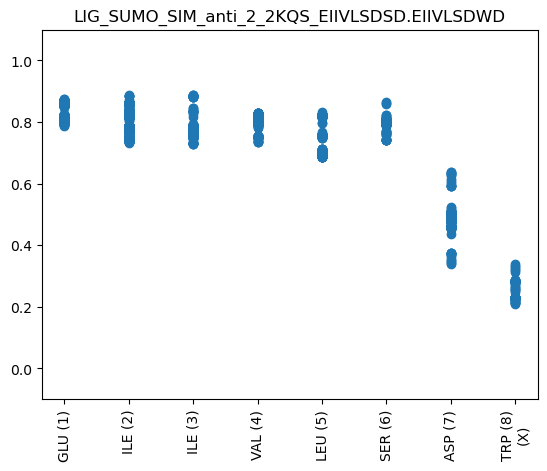

LIG_TRAF2_1_1CA9_SKEE.SKWE


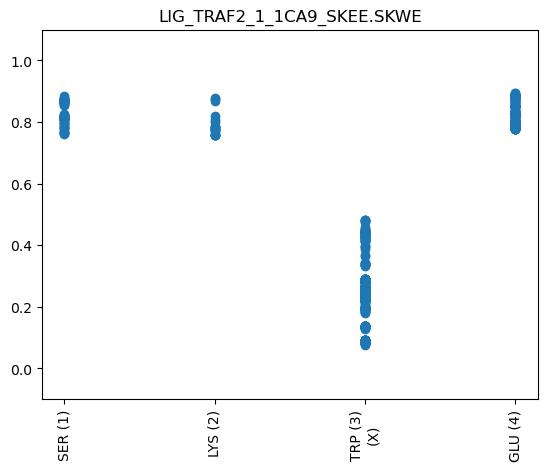

LIG_TRAF2_1_1CA9_SKEE.SKWW


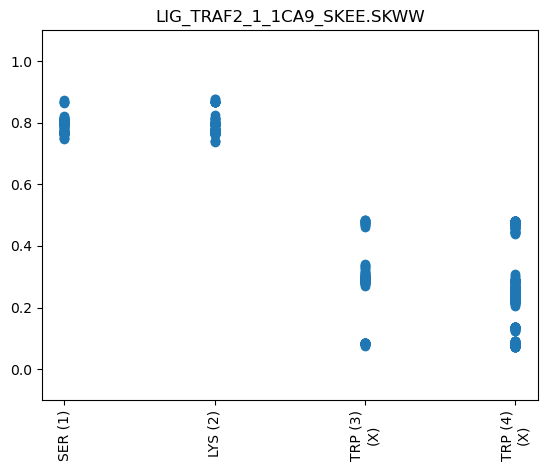

LIG_TRAF2_2_1CZY_PQQATD.WQQATD


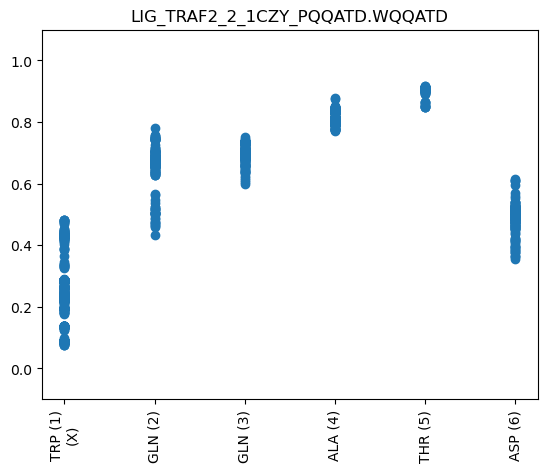

LIG_TRAF2_2_1CZY_PQQATD.WQQATW


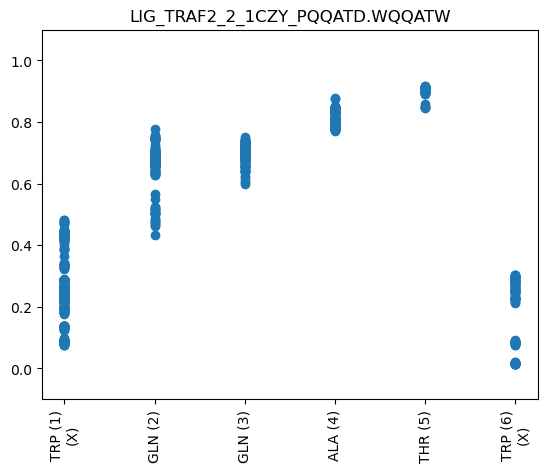

LIG_UFM1_UFIM_1_5HKH_NEWGIELV.NEWGIEDD


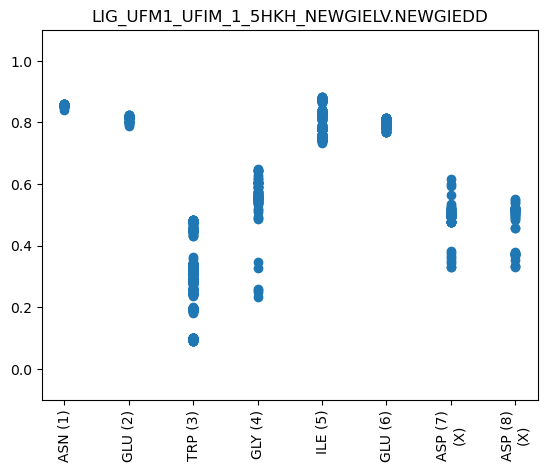

LIG_UFM1_UFIM_1_5HKH_NEWGIELV.NEWGIEDV


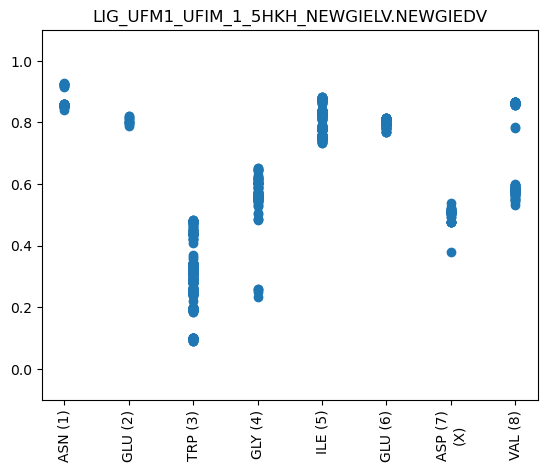

LIG_WD40_WDR5_WIN_1_3UVK_CARSEPK.CARSWPK


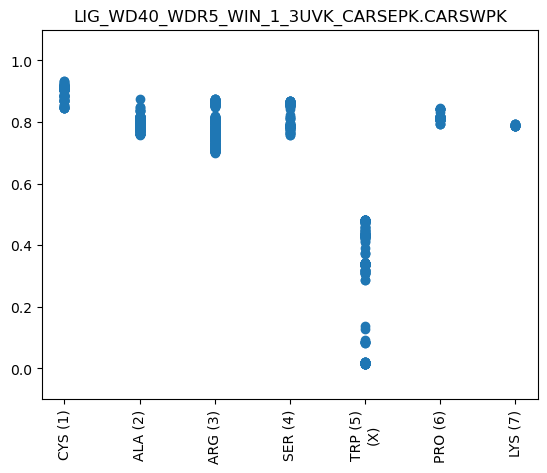

LIG_WD40_WDR5_WIN_1_3UVK_CARSEPK.CARWWPK


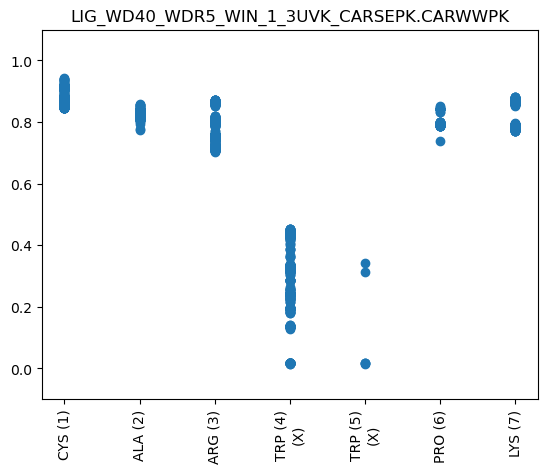

TRG_DiLeu_BaEn_1_4NEE_ENTSLL.WNTSLD


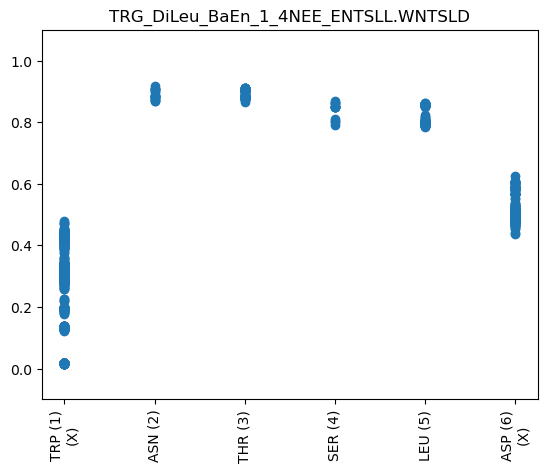

TRG_DiLeu_BaEn_1_4NEE_ENTSLL.WNTSLL


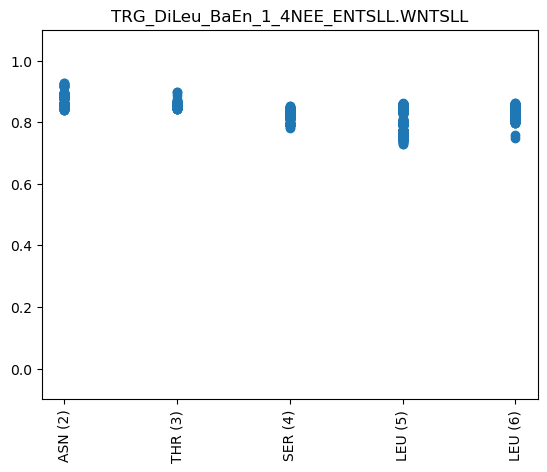

TRG_PTS1_2C0L_NAKL.NAGD


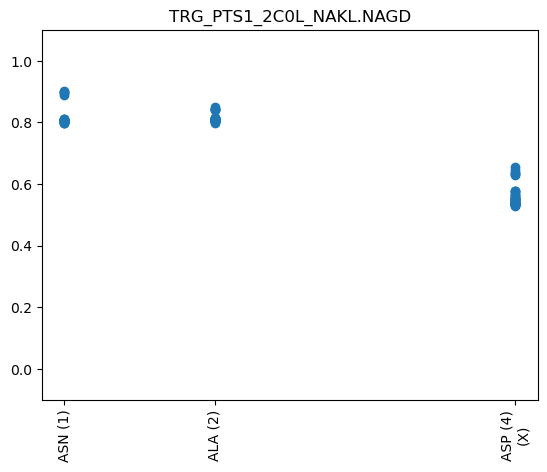

TRG_PTS1_2C0L_NAKL.NAKD


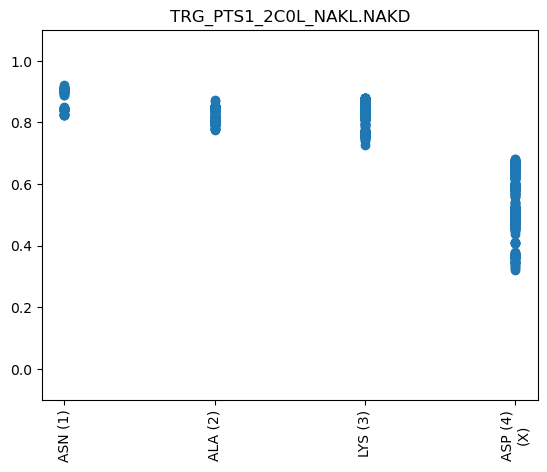

In [190]:
for i, row in dataAF_test.iterrows():
    structure_name = row["structure_name"]

    visualize_interface(structure_name)

Medians, Means